# Kazakhstan urbanization review

In support of Giuseppe Rossitti and Tom Farole, we need to generate a set of standard urban analyses

1. EC urban clusters using WorldPop 2020
   - need to name the clusters as well
2. Nighttime Lights for #1
3. GHSL for #1
4. Flood risk
5. Variation in precipitation and temperature
6. Air quality (PM 2.5)

In [5]:
import sys
import os
import importlib
import json
import boto3
import rasterio
import folium

import pandas as pd
import geopandas as gpd
import numpy as np
import skimage.graph as graph

from botocore.config import Config
from botocore import UNSIGNED
from shapely.geometry import Point, mapping
from scipy import ndimage

sys.path.insert(0, "/home/wb411133/Code/GOSTNets_Raster/src")
import GOSTNetsRaster.market_access as ma
# import GOSTNetsRaster.conversion_tables as speed_tables

sys.path.insert(0, "/home/wb411133/Code/gostrocks/src")
import GOSTRocks.rasterMisc as rMisc
import GOSTRocks.ntlMisc as ntl
from GOSTRocks.misc import tPrint

sys.path.append("../../../src")
import GOST_Urban.UrbanRaster as urban
import GOST_Urban.urban_helper as clippy

%load_ext autoreload
%autoreload 2

# read in local important parameters
local_json = "/home/wb411133/Code/urbanParameters.json"
with open(local_json, "r") as inJ:
    important_vars = json.load(inJ)

s3 = boto3.client("s3", config=Config(signature_version=UNSIGNED))

ModuleNotFoundError: No module named 'GOSTRocks.ntlMisc'

In [91]:
# Define input data
iso3 = "KAZ"
global_population_file = (
    "/home/public/Data/GLOBAL/Population/WorldPop_PPP_2020/ppp_2020_1km_Aggregated.tif"
)
global_population_ghs_file = "/home/public/Data/GLOBAL/Population/GHS/2022_1km/GHS_POP_E2020_GLOBE_R2022A_54009_1000_V1_0.tif"
global_ghsl_folder = "/home/public/Data/GLOBAL/GHSL/v2022/"
global_friction_surface = "/home/public/Data/GLOBAL/INFRA/FRICTION_2020/2020_motorized_friction_surface.geotiff"
admin_bounds = "/home/public/Data/COUNTRY/KAZ/ADMIN/kaz_districts.shp"

output_folder = "/home/wb411133/projects/KAZ_SCADR_Urbanization"
output_data = os.path.join(output_folder, "DATA")
worldpop_urban = os.path.join(output_data, "WorldPop_Urban")
ghspop_urban = os.path.join(output_data, "GHS_Urban")
ghsl_folder = os.path.join(output_data, "GHSL")
ma_folder = os.path.join(output_data, "MARKET_ACCESS")

if not os.path.exists(ma_folder):
    os.makedirs(ma_folder)

# Define output files
local_population = os.path.join(output_data, f"{iso3}_ppp_2020_1km_aggregated.tif")
local_ghs_population = os.path.join(output_data, f"{iso3}_ghs_pop_2020.tif")
local_friction = os.path.join(output_data, f"{iso3}_2020_motorized_travel.tif")
urban_tt_result = os.path.join(output_data, "urban_travel_time.csv")

"""
urban_extents_file        = os.path.join(worldpop_urban, f"{iso3}_urban_extents.geojson")
urban_extents_raster_file = os.path.join(worldpop_urban, f"{iso3}_urban_extents.tif")
urban_extents_hd_file     = os.path.join(worldpop_urban, f"{iso3}_urban_extents_hd.geojson")
urban_extents_hd_raster_file = os.path.join(worldpop_urban, f"{iso3}_urban_extents_hd.tif")
admin_urban_summary       = os.path.join(worldpop_urban, "adm2_urban_summary.shp")
urban_admin_summary       = os.path.join(worldpop_urban, f"{iso3}_ADM2_urban_summary.csv")
"""
urban_extents_file = os.path.join(ghspop_urban, f"{iso3}_urban_extents.geojson")
urban_extents_raster_file = os.path.join(ghspop_urban, f"{iso3}_urban_extents.tif")
urban_extents_hd_file = os.path.join(ghspop_urban, f"{iso3}_urban_extents_hd.geojson")
urban_extents_hd_raster_file = os.path.join(
    ghspop_urban, f"{iso3}_urban_extents_hd.tif"
)
admin_urban_summary = os.path.join(ghspop_urban, "adm2_urban_summary.shp")
urban_admin_summary = os.path.join(ghspop_urban, f"{iso3}_ADM2_urban_summary.csv")

urban_viirs_summary = os.path.join(output_folder, f"{iso3}_urban_viirs_summary.csv")
urban_hd_viirs_summary = os.path.join(
    output_folder, f"{iso3}_urban_hd_viirs_summary.csv"
)
admin_viirs_summary = os.path.join(output_folder, f"{iso3}_admin_viirs_summary.csv")

urban_ghsl_summary = os.path.join(output_folder, f"{iso3}_urban_ghsl_summary.csv")
urban_hd_ghsl_summary = os.path.join(output_folder, f"{iso3}_urban_hd_ghsl_summary.csv")
admin_ghsl_summary = os.path.join(output_folder, f"{iso3}_admin_ghsl_summary.csv")

admin_final = os.path.join(output_folder, "admin_summarized.shp")
urban_final = os.path.join(output_folder, "urban_summarized.shp")
urban_hd_final = os.path.join(output_folder, "urban_hd_summarized.shp")
focal_cities = os.path.join(output_folder, "FOCAL_AOIs.shp")

# Define market access output
all_routes_file = os.path.join(ma_folder, "all_routes.shp")
time_matrix = os.path.join(ma_folder, "all_routes_time_minutes.csv")
dist_matrix = os.path.join(ma_folder, "all_routes_distance_km.csv")
dist_all_routes_file = os.path.join(ma_folder, "all_routes.shp")
dist_time_matrix = os.path.join(ma_folder, "district_routes_time_minutes.csv")
dist_dist_matrix = os.path.join(ma_folder, "district_routes_distance_km.csv")

In [36]:
inAdmin = gpd.read_file(admin_bounds)

if not os.path.exists(local_population):
    globalP = rasterio.open(global_population_file)
    rMisc.clipRaster(globalP, inAdmin, local_population)

if not os.path.exists(local_ghs_population):
    globalP = rasterio.open(global_population_ghs_file)
    rMisc.clipRaster(globalP, inAdmin, local_ghs_population)

inP = rasterio.open(local_population)
inP_ghs = rasterio.open(local_ghs_population)

# Run urbanization analysis
1. Create urban extents  
2. Calculate urban population in admin bounds  
3. Summarize nighttime lights in extents and admin
4. Summarize GHSL in extents and admin

In [ ]:
# 1. Create urban extents for WorldPop
if not os.path.exists(urban_extents_file):
    urban_calculator = urban.urbanGriddedPop(inP)
    urban_extents = urban_calculator.calculateUrban(
        densVal=300,
        totalPopThresh=5000,
        smooth=False,
        queen=False,
        verbose=True,
        raster=urban_extents_raster_file,
    )
    urban_extents_hd = urban_calculator.calculateUrban(
        densVal=1500,
        totalPopThresh=50000,
        smooth=True,
        queen=False,
        verbose=True,
        raster=urban_extents_hd_raster_file,
    )
    # Name urban extents
    urban_extents = urban.geocode_cities(urban_extents)
    urban_extents_hd = urban.geocode_cities(urban_extents_hd)
    urban_extents.to_file(urban_extents_file, driver="GeoJSON")
    urban_extents_hd.to_file(urban_extents_hd_file, driver="GeoJSON")
else:
    urban_extents = gpd.read_file(urban_extents_file)
    urban_extents_hd = gpd.read_file(urban_extents_hd_file)

In [ ]:
# 1b. Create urban extents for GHS_Pop
if not os.path.exists(urban_extents_file):
    urban_calculator = urban.urbanGriddedPop(inP_ghs)
    urban_extents = urban_calculator.calculateUrban(
        densVal=300,
        totalPopThresh=5000,
        smooth=False,
        queen=False,
        verbose=True,
        raster=urban_extents_raster_file,
    )
    if urban_extents.crs.to_epsg() != 4326:
        urban_extents = urban_extents.to_crs(4326)
    urban_extents = urban.geocode_cities(urban_extents)
    urban_extents.to_file(urban_extents_file, driver="GeoJSON")
if not os.path.exists(urban_extents_hd_file):
    urban_extents_hd = urban_calculator.calculateUrban(
        densVal=1500,
        totalPopThresh=50000,
        smooth=True,
        queen=False,
        verbose=True,
        raster=urban_extents_hd_raster_file,
    )
    if urban_extents_hd.crs.to_epsg() != 4326:
        urban_extents_hd = urban_extents_hd.to_crs(4326)
    # Name urban extents
    urban_extents_hd = urban.geocode_cities(urban_extents_hd)
    urban_extents_hd.to_file(urban_extents_hd_file, driver="GeoJSON")
else:
    urban_extents = gpd.read_file(urban_extents_file)
    urban_extents_hd = gpd.read_file(urban_extents_hd_file)

In [ ]:
# 2. Calculate urban population in admin areas
if not os.path.exists(urban_admin_summary):
    pop_worker = clippy.summarize_population(
        local_ghs_population,
        inAdmin,
        urban_extents_raster_file,
        urban_extents_hd_raster_file,
    )
    summarized_urban = pop_worker.calculate_zonal()
    urban_res = summarized_urban.loc[
        :, [x for x in summarized_urban.columns if "SUM" in x]
    ]
    urban_res.columns = ["TOTAL_POP", "URBAN_POP", "URBAN_HD_POP"]
    urban_res["district_c"] = inAdmin["district_c"]
    urban_res["district"] = inAdmin["district"]
    urban_res.to_csv(urban_admin_summary)

In [ ]:
# 3. summarize nighttime lights
ntl_files = ntl.aws_search_ntl()

viirs_folder = os.path.join(output_data, "NTL_ZONAL_RES")
if not os.path.exists(viirs_folder):
    os.makedirs(viirs_folder)

urbanD = gpd.read_file(urban_extents_file)
urbanHD = gpd.read_file(urban_extents_hd_file)

for ntl_file in ntl_files:
    name = ntl_file.split("/")[-1].split("_")[2][:8]
    inR = rasterio.open(ntl_file)
    tPrint("Processing %s" % name)
    urban_res_file = os.path.join(viirs_folder, f"URBAN_{name}.csv")
    urban_hd_res_file = os.path.join(viirs_folder, f"HD_URBAN_{name}.csv")
    admin_res_file = os.path.join(viirs_folder, f"ADMIN_{name}.csv")

    # Urban Summary
    if not os.path.exists(urban_res_file):
        urban_res = rMisc.zonalStats(urbanD, inR, minVal=0.1)
        col_names = [f"URBAN_{name}_{x}" for x in ["SUM", "MIN", "MAX", "MEAN"]]
        urban_df = pd.DataFrame(urban_res, columns=col_names)
        urban_df.to_csv(urban_res_file)
    # HD Urban Summary
    if not os.path.exists(urban_hd_res_file):
        hd_urban_res = rMisc.zonalStats(urbanHD, inR, minVal=0.1)
        col_names = [f"HD_URBAN_{name}_{x}" for x in ["SUM", "MIN", "MAX", "MEAN"]]
        hd_urban_df = pd.DataFrame(hd_urban_res, columns=col_names)
        hd_urban_df.to_csv(urban_hd_res_file)
    # admin Summary
    if not os.path.exists(admin_res_file):
        admin_res = rMisc.zonalStats(inAdmin, inR, minVal=0.1)
        col_names = [f"ADM_URBAN_{name}_{x}" for x in ["SUM", "MIN", "MAX", "MEAN"]]
        admin_df = pd.DataFrame(admin_res, columns=col_names)
        admin_df.to_csv(admin_res_file)

In [ ]:
# Compile VIIRS results
urb_files = [x for x in os.listdir(viirs_folder) if x.startswith("URBAN")]
for x in urb_files:
    tempD = pd.read_csv(os.path.join(viirs_folder, x), index_col=0)
    urbanD[x[:-4]] = tempD.iloc[:, 0]

hd_urb_files = [x for x in os.listdir(viirs_folder) if x.startswith("HD_URBAN")]
for x in hd_urb_files:
    tempD = pd.read_csv(os.path.join(viirs_folder, x), index_col=0)
    urbanHD[x[:-4]] = tempD.iloc[:, 0]

admin_urb_files = [x for x in os.listdir(viirs_folder) if x.startswith("ADMIN")]
for x in admin_urb_files:
    tempD = pd.read_csv(os.path.join(viirs_folder, x), index_col=0)
    inAdmin[x[:-4]] = tempD.iloc[:, 0]

urbanD.drop(["geometry"], axis=1).to_csv(urban_viirs_summary)
urbanHD.drop(["geometry"], axis=1).to_csv(urban_hd_viirs_summary)
inAdmin.drop(["geometry"], axis=1).to_csv(admin_viirs_summary)

# Summarize GHSL

In [ ]:
# List all files in ghsl folder
ghsl_files = [
    os.path.join(global_ghsl_folder, x)
    for x in os.listdir(global_ghsl_folder)
    if x.endswith(".tif")
]

for file_def in [
    # [admin_bounds, admin_ghsl_summary],
    [urban_extents_file, urban_ghsl_summary],
    [urban_extents_file, urban_ghsl_summary],
]:
    resG = gpd.read_file(file_def[0])

    for ghsl_file in ghsl_files:
        date = os.path.basename(ghsl_file).split("_")[3]
        inR = rasterio.open(ghsl_file)
        if resG.crs != inR.crs:
            resG = resG.to_crs(inR.crs)
        local_file = os.path.join(ghsl_folder, os.path.basename(ghsl_file))
        if not os.path.exists(local_file):
            rMisc.clipRaster(inR, resG, local_file)
        res = rMisc.zonalStats(resG, inR, minVal=0)
        res = pd.DataFrame(res, columns=["SUM", "MIN", "MAX", "MEAN"])
        resG[f"ghsl_{date}"] = res["SUM"]
        print(date)
    pd.DataFrame(resG.drop(["geometry"], axis=1)).to_csv(file_def[1])

# Join urban clusters and districts

In [ ]:
inUrban = gpd.read_file(urban_extents_file)
inHD = gpd.read_file(urban_extents_hd_file)
inAdmin = gpd.read_file(admin_bounds)
inAdmin = inAdmin.to_crs(inUrban.crs)

ntl_files = ntl.aws_search_ntl()

In [ ]:
def get_majority_polygon(
    shp, shp2, pop_layer, area_name="zz_area", zonal_sum_name="zz_sum"
):
    """Intersect shp(single polygon) with shp2(GeoDataFrame) to determine which row in shp2 has
        the highest zonal sum (ie - population)

    Args:
        shp: shapely polygon
        shp2: GeoDataFrame
        pop_layer: rasterio reader
    returns
        shp2 GeoDataFrame with two additional columns: area and zonal_sum
    """
    temp_shp = shp2.copy()
    for idx, row in temp_shp.iterrows():
        # Convert geometry in shp2 to the intersection with shp1
        xx = row["geometry"].intersection(shp.buffer(0)).buffer(0)
        temp_shp.loc[[idx], "geometry"] = gpd.GeoDataFrame(
            geometry=[xx]
        ).geometry.values

    # Run zonal analysis on pop_layer
    res = rMisc.zonalStats(temp_shp, pop_layer, reProj=True)
    res = pd.DataFrame(res, columns=["SUM", "MIN", "MAX", "MEAN"])

    shp2[zonal_sum_name] = res["SUM"].values
    shp2[area_name] = temp_shp["geometry"].apply(lambda x: x.area)

    return shp2.sort_values(zonal_sum_name, ascending=False)

In [ ]:
inUrban["HD_ID"] = ""
inUrban["Admin1_ID"] = ""
inUrban["Admin1_Pop"] = 0
inUrban["Admin2_ID"] = ""
inUrban["Admin2_Pop"] = 0


for idx, row in inUrban.iterrows():
    tPrint(idx)
    # Identify intersecting HD urban areas
    selHD = inHD.loc[inHD.intersects(row["geometry"])]
    if selHD.shape[0] == 1:
        inUrban.loc[idx, "HD_ID"] = selHD["ID"].iloc[0]
    elif selHD.shape[0] > 1:
        selHD = get_majority_polygon(row["geometry"], selHD, inP_ghs)
        inUrban.loc[idx, "HD_ID"] = selHD["ID"].iloc[0]

    # Identify intersecting admin areas
    selAdmin = inAdmin.loc[inAdmin.intersects(row["geometry"])]
    if selAdmin.shape[0] == 1:
        inUrban.loc[idx, "Admin1_ID"] = selAdmin["district_c"].iloc[0]
    elif selAdmin.shape[0] > 1:
        selAdmin = get_majority_polygon(row["geometry"], selAdmin, inP_ghs)
        inUrban.loc[idx, "Admin1_ID"] = selAdmin["district_c"].iloc[0]
        inUrban.loc[idx, "Admin1_Pop"] = selAdmin["zz_sum"].iloc[0]
        inUrban.loc[idx, "Admin2_ID"] = selAdmin["district_c"].iloc[1]
        inUrban.loc[idx, "Admin2_Pop"] = selAdmin["zz_sum"].iloc[1]

In [ ]:
inUrban.to_file()

In [ ]:
pd.DataFrame(inUrban.drop(["geometry"], axis=1)).to_csv(
    urban_extents_file.replace(".geojson", "_named.csv")
)

# Calculate admin centroids

In [ ]:
inAdmin_centroids = inAdmin.copy()
for idx, row in inAdmin.iterrows():
    # create numpy array of intersecting population layer
    curP, transform = mask(inR, [row.geometry], crop=True)
    curP[curP < 0] = 0
    centroid_coords = ndimage.center_of_mass(curP)

    b = row.geometry.bounds
    x_range = b[2] - b[0]
    y_range = b[3] - b[1]

    x_coord = b[0] + x_range * (centroid_coords[1] / curP.shape[1])
    y_coord = b[1] + y_range * (centroid_coords[2] / curP.shape[2])
    final_geom = Point(x_coord, y_coord)
    inAdmin_centroids.loc[idx, "geometry"] = final_geom
inAdmin_centroids.to_file(admin_final.replace(".shp", "_centroids.shp"))

# Calculate travel time

In [37]:
if not os.path.exists(local_friction):
    globalP = rasterio.open(global_friction_surface)
    rMisc.clipRaster(globalP, inAdmin, local_friction)

dests = gpd.read_file(urban_extents_file)
dests["geometry"] = dests["geometry"].apply(lambda x: x.centroid)
inR = rasterio.open(local_friction)
frictionD = inR.read()[0, :, :]
frictionD = frictionD * 1000
mcp = graph.MCP_Geometric(frictionD)

In [42]:
dests.head()

ID            Pop                   City                    State  \
0  3052  130655.017539              Petropavl  North Kazakhstan Region   
1  3053   19007.643360  Бескөл ауылдық округі  North Kazakhstan Region   
2  3054    6238.582276                                                   
3  3055    6369.063403                                                   
4  3056    8071.832339                                                   

      Country                   geometry  
0  Kazakhstan  POINT (69.14525 54.88136)  
1  Kazakhstan  POINT (69.10092 54.77176)  
2              POINT (69.76201 53.84654)  
3              POINT (64.17300 53.80176)  
4              POINT (64.03258 53.45855)

In [ ]:
importlib.reload(ma)
# Calculate travel time between all urban areas
all_rts = ma.get_linear_routes(inR, frictionD, dests, dests, "ID", "ID", verbose=True)
all_rts = all_rts.to_crs(3857)
all_rts["length_km"] = all_rts["geometry"].apply(lambda x: x.length / 1000)

14:28:27	Processing origin 0 of 287


287it [09:51,  2.06s/it]


14:38:18	Processing origin 1 of 287


287it [09:52,  2.07s/it]


14:48:11	Processing origin 2 of 287


287it [09:46,  2.04s/it]


14:57:58	Processing origin 3 of 287


287it [10:34,  2.21s/it]


15:08:33	Processing origin 4 of 287


287it [10:32,  2.20s/it]


15:19:05	Processing origin 5 of 287


287it [10:41,  2.24s/it]


15:29:47	Processing origin 6 of 287


287it [10:01,  2.09s/it]


15:39:48	Processing origin 7 of 287


287it [10:25,  2.18s/it]


15:50:14	Processing origin 8 of 287


287it [11:08,  2.33s/it]


16:01:22	Processing origin 9 of 287


287it [10:11,  2.13s/it]


16:11:33	Processing origin 10 of 287


287it [10:42,  2.24s/it]


16:22:16	Processing origin 11 of 287


287it [10:50,  2.27s/it]


16:33:06	Processing origin 12 of 287


287it [10:55,  2.28s/it]


16:44:01	Processing origin 13 of 287


287it [10:52,  2.27s/it]


16:54:54	Processing origin 14 of 287


287it [10:07,  2.12s/it]


17:05:01	Processing origin 15 of 287


287it [09:59,  2.09s/it]


17:15:00	Processing origin 16 of 287


287it [09:55,  2.08s/it]


17:24:56	Processing origin 17 of 287


287it [09:46,  2.04s/it]


17:34:42	Processing origin 18 of 287


287it [09:21,  1.96s/it]


17:44:03	Processing origin 19 of 287


287it [08:59,  1.88s/it]


17:53:03	Processing origin 20 of 287


287it [08:56,  1.87s/it]


18:01:59	Processing origin 21 of 287


287it [09:42,  2.03s/it]


18:11:41	Processing origin 22 of 287


287it [08:57,  1.87s/it]


18:20:38	Processing origin 23 of 287


287it [09:42,  2.03s/it]


18:30:21	Processing origin 24 of 287


287it [08:57,  1.87s/it]


18:39:18	Processing origin 25 of 287


287it [08:59,  1.88s/it]


18:48:18	Processing origin 26 of 287


287it [09:00,  1.88s/it]


18:57:18	Processing origin 27 of 287


287it [10:44,  2.25s/it]


19:08:03	Processing origin 28 of 287


287it [09:25,  1.97s/it]


19:17:28	Processing origin 29 of 287


287it [09:23,  1.96s/it]


19:26:51	Processing origin 30 of 287


287it [09:55,  2.07s/it]


19:36:47	Processing origin 31 of 287


287it [09:23,  1.96s/it]


19:46:10	Processing origin 32 of 287


287it [09:16,  1.94s/it]


19:55:26	Processing origin 33 of 287


287it [09:19,  1.95s/it]


20:04:46	Processing origin 34 of 287


287it [09:07,  1.91s/it]


20:13:53	Processing origin 35 of 287


287it [09:09,  1.91s/it]


20:23:03	Processing origin 36 of 287


287it [09:39,  2.02s/it]


20:32:43	Processing origin 37 of 287


287it [09:13,  1.93s/it]


20:41:56	Processing origin 38 of 287


287it [09:08,  1.91s/it]


20:51:04	Processing origin 39 of 287


287it [09:07,  1.91s/it]


21:00:12	Processing origin 40 of 287


287it [09:04,  1.90s/it]


21:09:17	Processing origin 41 of 287


287it [09:02,  1.89s/it]


21:18:20	Processing origin 42 of 287


287it [09:01,  1.89s/it]


21:27:21	Processing origin 43 of 287


287it [09:01,  1.89s/it]


21:36:22	Processing origin 44 of 287


287it [09:41,  2.03s/it]


21:46:04	Processing origin 45 of 287


287it [09:09,  1.92s/it]


21:55:14	Processing origin 46 of 287


287it [09:40,  2.02s/it]


22:04:54	Processing origin 47 of 287


287it [09:37,  2.01s/it]


22:14:31	Processing origin 48 of 287


287it [09:38,  2.02s/it]


22:24:10	Processing origin 49 of 287


287it [09:05,  1.90s/it]


22:33:16	Processing origin 50 of 287


287it [09:34,  2.00s/it]


22:42:50	Processing origin 51 of 287


287it [08:58,  1.87s/it]


22:51:48	Processing origin 52 of 287


287it [09:06,  1.90s/it]


23:00:55	Processing origin 53 of 287


287it [09:20,  1.95s/it]


23:10:15	Processing origin 54 of 287


287it [09:21,  1.96s/it]


23:19:37	Processing origin 55 of 287


287it [09:20,  1.95s/it]


23:28:58	Processing origin 56 of 287


287it [09:10,  1.92s/it]


23:38:08	Processing origin 57 of 287


287it [09:04,  1.90s/it]


23:47:13	Processing origin 58 of 287


287it [08:57,  1.87s/it]


23:56:10	Processing origin 59 of 287


287it [09:40,  2.02s/it]


00:05:51	Processing origin 60 of 287


287it [08:56,  1.87s/it]


00:14:47	Processing origin 61 of 287


287it [08:36,  1.80s/it]


00:23:24	Processing origin 62 of 287


287it [08:50,  1.85s/it]


00:32:14	Processing origin 63 of 287


287it [08:41,  1.82s/it]


00:40:56	Processing origin 64 of 287


287it [09:39,  2.02s/it]


00:50:36	Processing origin 65 of 287


287it [08:41,  1.82s/it]


00:59:17	Processing origin 66 of 287


287it [08:41,  1.82s/it]


01:07:58	Processing origin 67 of 287


287it [09:41,  2.03s/it]


01:17:40	Processing origin 68 of 287


287it [08:26,  1.76s/it]


01:26:06	Processing origin 69 of 287


287it [09:30,  1.99s/it]


01:35:37	Processing origin 70 of 287


287it [09:39,  2.02s/it]


01:45:16	Processing origin 71 of 287


287it [09:40,  2.02s/it]


01:54:57	Processing origin 72 of 287


287it [08:50,  1.85s/it]


02:03:48	Processing origin 73 of 287


287it [09:32,  2.00s/it]


02:13:21	Processing origin 74 of 287


287it [09:57,  2.08s/it]


02:23:18	Processing origin 75 of 287


287it [08:32,  1.79s/it]


02:31:51	Processing origin 76 of 287


287it [08:48,  1.84s/it]


02:40:40	Processing origin 77 of 287


287it [08:46,  1.83s/it]


02:49:26	Processing origin 78 of 287


287it [08:55,  1.87s/it]


02:58:22	Processing origin 79 of 287


287it [08:47,  1.84s/it]


03:07:09	Processing origin 80 of 287


287it [08:48,  1.84s/it]


03:15:58	Processing origin 81 of 287


287it [09:37,  2.01s/it]


03:25:35	Processing origin 82 of 287


287it [08:23,  1.75s/it]


03:33:59	Processing origin 83 of 287


287it [08:45,  1.83s/it]


03:42:44	Processing origin 84 of 287


287it [08:50,  1.85s/it]


03:51:35	Processing origin 85 of 287


287it [08:41,  1.82s/it]


04:00:17	Processing origin 86 of 287


287it [10:36,  2.22s/it]


04:10:54	Processing origin 87 of 287


287it [08:52,  1.85s/it]


04:19:46	Processing origin 88 of 287


287it [08:55,  1.87s/it]


04:28:41	Processing origin 89 of 287


287it [09:37,  2.01s/it]


04:38:18	Processing origin 90 of 287


287it [08:52,  1.85s/it]


04:47:11	Processing origin 91 of 287


287it [08:54,  1.86s/it]


04:56:05	Processing origin 92 of 287


287it [08:52,  1.85s/it]


05:04:57	Processing origin 93 of 287


287it [08:29,  1.78s/it]


05:13:27	Processing origin 94 of 287


287it [08:51,  1.85s/it]


05:22:19	Processing origin 95 of 287


287it [08:54,  1.86s/it]


05:31:13	Processing origin 96 of 287


287it [08:47,  1.84s/it]


05:40:01	Processing origin 97 of 287


287it [08:37,  1.80s/it]


05:48:39	Processing origin 98 of 287


287it [08:53,  1.86s/it]


05:57:32	Processing origin 99 of 287


287it [09:48,  2.05s/it]


06:07:21	Processing origin 100 of 287


287it [09:39,  2.02s/it]


06:17:01	Processing origin 101 of 287


287it [09:02,  1.89s/it]


06:26:04	Processing origin 102 of 287


287it [08:54,  1.86s/it]


06:34:59	Processing origin 103 of 287


287it [09:43,  2.03s/it]


06:44:42	Processing origin 104 of 287


287it [09:52,  2.07s/it]


06:54:35	Processing origin 105 of 287


287it [09:51,  2.06s/it]


07:04:26	Processing origin 106 of 287


287it [09:53,  2.07s/it]


07:14:20	Processing origin 107 of 287


287it [09:46,  2.04s/it]


07:24:07	Processing origin 108 of 287


287it [08:48,  1.84s/it]


07:32:55	Processing origin 109 of 287


287it [09:50,  2.06s/it]


07:42:46	Processing origin 110 of 287


287it [08:38,  1.81s/it]


07:51:25	Processing origin 111 of 287


287it [09:51,  2.06s/it]


08:01:16	Processing origin 112 of 287


287it [08:57,  1.87s/it]


08:10:13	Processing origin 113 of 287


287it [08:51,  1.85s/it]


08:19:04	Processing origin 114 of 287


287it [08:43,  1.82s/it]


08:27:47	Processing origin 115 of 287


287it [09:28,  1.98s/it]


08:37:15	Processing origin 116 of 287


287it [10:13,  2.14s/it]


08:47:29	Processing origin 117 of 287


287it [09:28,  1.98s/it]


08:56:58	Processing origin 118 of 287


287it [10:14,  2.14s/it]


09:07:13	Processing origin 119 of 287


287it [10:15,  2.15s/it]


09:17:28	Processing origin 120 of 287


287it [08:56,  1.87s/it]


09:26:25	Processing origin 121 of 287


287it [10:15,  2.14s/it]


09:36:40	Processing origin 122 of 287


287it [10:21,  2.16s/it]


09:47:02	Processing origin 123 of 287


287it [08:51,  1.85s/it]


09:55:53	Processing origin 124 of 287


287it [10:09,  2.12s/it]


10:06:02	Processing origin 125 of 287


287it [10:26,  2.18s/it]


10:16:29	Processing origin 126 of 287


287it [10:25,  2.18s/it]


10:26:55	Processing origin 127 of 287


287it [08:47,  1.84s/it]


10:35:43	Processing origin 128 of 287


287it [10:27,  2.19s/it]


10:46:10	Processing origin 129 of 287


287it [08:57,  1.87s/it]


10:55:08	Processing origin 130 of 287


287it [10:06,  2.11s/it]


11:05:14	Processing origin 131 of 287


287it [08:57,  1.87s/it]


11:14:12	Processing origin 132 of 287


287it [08:35,  1.80s/it]


11:22:47	Processing origin 133 of 287


287it [10:10,  2.13s/it]


11:32:58	Processing origin 134 of 287


287it [10:38,  2.23s/it]


11:43:37	Processing origin 135 of 287


287it [10:32,  2.20s/it]


11:54:10	Processing origin 136 of 287


287it [08:44,  1.83s/it]


12:02:54	Processing origin 137 of 287


287it [09:16,  1.94s/it]


12:12:11	Processing origin 138 of 287


287it [09:37,  2.01s/it]


12:21:49	Processing origin 139 of 287


287it [09:35,  2.01s/it]


12:31:24	Processing origin 140 of 287


287it [09:14,  1.93s/it]


12:40:39	Processing origin 141 of 287


287it [08:56,  1.87s/it]


12:49:35	Processing origin 142 of 287


287it [08:35,  1.80s/it]


12:58:11	Processing origin 143 of 287


287it [08:34,  1.79s/it]


13:06:45	Processing origin 144 of 287


287it [10:19,  2.16s/it]


13:17:04	Processing origin 145 of 287


287it [08:26,  1.76s/it]


13:25:31	Processing origin 146 of 287


287it [08:48,  1.84s/it]


13:34:19	Processing origin 147 of 287


287it [07:31,  1.57s/it]


13:41:51	Processing origin 148 of 287


287it [08:25,  1.76s/it]


13:50:16	Processing origin 149 of 287


287it [07:15,  1.52s/it]


13:57:31	Processing origin 150 of 287


287it [07:14,  1.51s/it]


14:04:45	Processing origin 151 of 287


287it [06:47,  1.42s/it]


14:11:33	Processing origin 152 of 287


287it [06:48,  1.42s/it]


14:18:21	Processing origin 153 of 287


287it [06:49,  1.43s/it]


14:25:11	Processing origin 154 of 287


287it [06:50,  1.43s/it]


14:32:01	Processing origin 155 of 287


287it [07:13,  1.51s/it]


14:39:15	Processing origin 156 of 287


287it [07:59,  1.67s/it]


14:47:14	Processing origin 157 of 287


287it [07:20,  1.53s/it]


14:54:35	Processing origin 158 of 287


287it [07:20,  1.53s/it]


15:01:55	Processing origin 159 of 287


287it [07:19,  1.53s/it]


15:09:15	Processing origin 160 of 287


287it [07:39,  1.60s/it]


15:16:55	Processing origin 161 of 287


287it [07:20,  1.53s/it]


15:24:15	Processing origin 162 of 287


287it [09:15,  1.94s/it]


15:33:30	Processing origin 163 of 287


287it [07:15,  1.52s/it]


15:40:46	Processing origin 164 of 287


287it [07:29,  1.57s/it]


15:48:15	Processing origin 165 of 287


287it [07:12,  1.51s/it]


15:55:28	Processing origin 166 of 287


287it [06:44,  1.41s/it]


16:02:12	Processing origin 167 of 287


287it [10:36,  2.22s/it]


16:12:48	Processing origin 168 of 287


287it [06:40,  1.39s/it]


16:19:29	Processing origin 169 of 287


287it [06:39,  1.39s/it]


16:26:08	Processing origin 170 of 287


287it [06:48,  1.42s/it]


16:32:56	Processing origin 171 of 287


287it [06:43,  1.41s/it]


16:39:40	Processing origin 172 of 287


287it [08:41,  1.82s/it]


16:48:21	Processing origin 173 of 287


287it [08:42,  1.82s/it]


16:57:04	Processing origin 174 of 287


287it [06:27,  1.35s/it]


17:03:32	Processing origin 175 of 287


287it [06:43,  1.40s/it]


17:10:15	Processing origin 176 of 287


287it [08:42,  1.82s/it]


17:18:57	Processing origin 177 of 287


287it [06:42,  1.40s/it]


17:25:40	Processing origin 178 of 287


287it [06:42,  1.40s/it]


17:32:23	Processing origin 179 of 287


287it [06:39,  1.39s/it]


17:39:02	Processing origin 180 of 287


287it [06:42,  1.40s/it]


17:45:44	Processing origin 181 of 287


287it [06:43,  1.40s/it]


17:52:27	Processing origin 182 of 287


287it [06:45,  1.41s/it]


17:59:13	Processing origin 183 of 287


287it [06:42,  1.40s/it]


18:05:56	Processing origin 184 of 287


287it [06:43,  1.41s/it]


18:12:39	Processing origin 185 of 287


287it [06:43,  1.41s/it]


18:19:22	Processing origin 186 of 287


287it [06:47,  1.42s/it]


18:26:10	Processing origin 187 of 287


287it [06:46,  1.42s/it]


18:32:56	Processing origin 188 of 287


287it [06:48,  1.42s/it]


18:39:45	Processing origin 189 of 287


287it [06:48,  1.42s/it]


18:46:34	Processing origin 190 of 287


287it [06:46,  1.42s/it]


18:53:21	Processing origin 191 of 287


287it [08:54,  1.86s/it]


19:02:15	Processing origin 192 of 287


287it [07:03,  1.47s/it]


19:09:18	Processing origin 193 of 287


287it [06:50,  1.43s/it]


19:16:08	Processing origin 194 of 287


287it [06:52,  1.44s/it]


19:23:01	Processing origin 195 of 287


287it [06:53,  1.44s/it]


19:29:55	Processing origin 196 of 287


287it [07:15,  1.52s/it]


19:37:10	Processing origin 197 of 287


287it [08:59,  1.88s/it]


19:46:10	Processing origin 198 of 287


287it [07:01,  1.47s/it]


19:53:11	Processing origin 199 of 287


287it [06:52,  1.44s/it]


20:00:03	Processing origin 200 of 287


287it [06:56,  1.45s/it]


20:06:59	Processing origin 201 of 287


287it [06:59,  1.46s/it]


20:13:58	Processing origin 202 of 287


287it [07:03,  1.47s/it]


20:21:01	Processing origin 203 of 287


287it [07:44,  1.62s/it]


20:28:46	Processing origin 204 of 287


287it [06:56,  1.45s/it]


20:35:43	Processing origin 205 of 287


287it [06:56,  1.45s/it]


20:42:39	Processing origin 206 of 287


287it [06:50,  1.43s/it]


20:49:30	Processing origin 207 of 287


287it [06:55,  1.45s/it]


20:56:26	Processing origin 208 of 287


287it [07:03,  1.48s/it]


21:03:30	Processing origin 209 of 287


287it [06:51,  1.43s/it]


21:10:21	Processing origin 210 of 287


287it [08:56,  1.87s/it]


21:19:18	Processing origin 211 of 287


287it [06:54,  1.44s/it]


21:26:12	Processing origin 212 of 287


287it [06:47,  1.42s/it]


21:33:00	Processing origin 213 of 287


287it [06:54,  1.44s/it]


21:39:54	Processing origin 214 of 287


287it [06:38,  1.39s/it]


21:46:33	Processing origin 215 of 287


81it [02:23,  1.33s/it]

In [93]:
# all_rts.to_file(all_routes_file)
pd.pivot_table(all_rts, "cost", "origin", "destination").to_csv(time_matrix)
pd.pivot_table(all_rts, "length_km", "origin", "destination").to_csv(dist_matrix)

In [79]:
inAdmin_centroids

country country_co     district district_c  \
0    Republic of Kazakhstan         KZ        Akkol   KZ113200   
1    Republic of Kazakhstan         KZ      Arshaly   KZ113400   
2    Republic of Kazakhstan         KZ    Astrakhan   KZ113600   
3    Republic of Kazakhstan         KZ      Atbasar   KZ113800   
4    Republic of Kazakhstan         KZ  Birzhan sal   KZ114500   
..                      ...        ...          ...        ...   
211  Republic of Kazakhstan         KZ      Taskala   KZ276000   
212  Republic of Kazakhstan         KZ      Terekti   KZ276200   
213  Republic of Kazakhstan         KZ       Uralsk   KZ271000   
214  Republic of Kazakhstan         KZ    Zhanakala   KZ274000   
215  Republic of Kazakhstan         KZ     Zhanybek   KZ274200   

              region region_cod    Shape_Leng    Shape_Area  \
0             Akmola       KZ11  1.301150e+06  2.458421e+10   
1             Akmola       KZ11  7.766808e+05  1.522217e+10   
2             Akmola       KZ11  8.281231e+05  1.876494e+10   
3             Akmola       KZ11  1.001539e+06  2.783360e+10   
4             Akmola       KZ11  1.149534e+06  2.932692e+10   
..               ...        ...           ...           ...   
211  West Kazakhstan       KZ27  7.436122e+05  2.105312e+10   
212  West Kazakhstan       KZ27  1.038464e+06  2.182121e+10   
213  West Kazakhstan       KZ27  1.835492e+05  6.242755e+08   
214  West Kazakhstan       KZ27  1.151754e+06  4.941769e+10   
215  West Kazakhstan       KZ27  8.157793e+05  2.013093e+10   

                      geometry  
0    POINT (71.72694 52.19832)  
1    POINT (72.38920 50.84320)  
2    POINT (69.77404 51.52113)  
3    POINT (68.49621 51.34473)  
4    POINT (71.77130 52.79155)  
..                         ...  
211  POINT (49.88110 50.73325)  
212  POINT (51.73242 50.61508)  
213  POINT (51.40729 51.10625)  
214  POINT (50.25561 48.81281)  
215  POINT (47.54079 49.73544)  

[216 rows x 9 columns]

In [83]:
importlib.reload(ma)
# Calculate travel time between all urban areas and district centroids
inAdmin_centroids = gpd.read_file(admin_final.replace(".shp", "_centroids.shp"))
dist_all_rts = ma.get_linear_routes_mp(
    inR, frictionD, dests, inAdmin_centroids, "ID", "district_c", verbose=True
)
dist_all_rts = dist_all_rts.to_crs(3857)
dist_all_rts["length_km"] = dist_all_rts["geometry"].apply(lambda x: x.length / 1000)

11:55:52	Completed 3052 to KZ113200: 534.7885936969452
11:55:53	Completed 3055 to KZ395600: 32.94981367877145
11:55:53	Completed 3052 to KZ113400: 613.239156900617
11:55:54	Completed 3063 to KZ392000: 601.9773229763892
11:55:54	Completed 3055 to KZ395800: 752.5391948617191
11:55:55	Completed 3077 to KZ391000: 132.6104256346442
11:55:55	Completed 3052 to KZ113600: 538.5034350034537
11:55:55	Completed 3054 to KZ634400: 1670.8151003572132
11:55:55	Completed 3078 to KZ711310: 536.7817559926016
11:55:55	Completed 3071 to KZ395400: 929.1874736929086
11:55:55	Completed 3072 to KZ555200: 876.0965490715658
11:55:55	Completed 3056 to KZ553200: 1590.5948987960387
11:55:55	Completed 3063 to KZ395600: 479.13067226746597
11:55:55	Completed 3088 to KZ711210: 537.1434575255128
11:55:56	Completed 3077 to KZ395400: 180.47797866772262
11:55:56	Completed 3053 to KZ194800: 2303.9786381759864
11:55:56	Completed 3052 to KZ113800: 559.3759603852685
11:55:56	Completed 3066 to KZ551600: 1507.1444666740988
11:55

11:56:15	Completed 3088 to KZ556800: 291.7237297173525
11:56:15	Completed 3136 to KZ636400: 1136.512682844823
11:56:15	Completed 3052 to KZ111810: 536.1324230468946
11:56:16	Completed 3137 to KZ395000: 933.5344403084218
11:56:16	Completed 3053 to KZ196000: 2165.337626441519
11:56:16	Completed 3131 to KZ273600: 3932.9821461355714
11:56:16	Completed 3094 to KZ554600: 481.0675814348833
11:56:16	Completed 3124 to KZ274000: 1424.2165460764795
11:56:16	Completed 3055 to KZ431900: 1665.3427225229268
11:56:16	Completed 3058 to KZ116400: 160.8997223893549
11:56:16	Completed 3112 to KZ191600: 1508.7611418503777
11:56:16	Completed 3099 to KZ392000: 1155.3667856832326
11:56:16	Completed 3056 to KZ555600: 2053.351144075833
11:56:16	Completed 3117 to KZ551600: 547.6453033929117
11:56:16	Completed 3123 to KZ553600: 604.4430987242771
11:56:16	Completed 3059 to KZ195600: 2489.12525489842811:56:16	Completed 3122 to KZ396800: 1242.3992208071993

11:56:16	Completed 3126 to KZ195200: 1433.2502873533015
11:

11:56:36	Completed 3053 to KZ196600: 2358.2602338945953
11:56:36	Completed 3118 to KZ276000: 3188.873571330096
11:56:36	Completed 3058 to KZ153200: 1946.6832319452662
11:56:36	Completed 3091 to KZ196200: 1812.72782830385
11:56:36	Completed 3077 to KZ431000: 1556.7946830071173
11:56:36	Completed 3104 to KZ195800: 1937.6695127395292
11:56:36	Completed 3089 to KZ274000: 3936.4608466852105
11:56:36	Completed 3066 to KZ554800: 1790.184359455468
11:56:36	Completed 3055 to KZ435200: 1862.600520137421
11:56:36	Completed 3117 to KZ556800: 833.0302549432068
11:56:36	Completed 3133 to KZ194000: 3236.9111953531906
11:56:36	Completed 3074 to KZ114000: 816.721744126024
11:56:36	Completed 3071 to KZ431900: 1897.4562479167087
11:56:36	Completed 3125 to KZ116400: 466.41849697698086
11:56:36	Completed 3123 to KZ791110: 1628.4306593526342
11:56:37	Completed 3083 to KZ195800: 2031.6555993415946
11:56:37	Completed 3070 to KZ314800: 1695.6285774626283
11:56:37	Completed 3061 to KZ315600: 1761.178904842344
1

11:56:58	Completed 3133 to KZ191600: 3164.0216758477063
11:56:58	Completed 3071 to KZ435200: 1691.1980926797366
11:56:58	Completed 3137 to KZ434800: 1025.1630946696405
11:56:58	Completed 3118 to KZ274000: 3589.640429949614
11:56:58	Completed 3126 to KZ751910: 1421.5766118060644
11:56:58	Completed 3058 to KZ156000: 1710.1851554394984
11:56:58	Completed 3072 to KZ611600: 1820.1833577935893
11:56:58	Completed 3125 to KZ153200: 2214.446586542612
11:56:58	Completed 3093 to KZ431900: 1791.75804567881
11:56:58	Completed 3097 to KZ196000: 1700.202045410094
11:56:58	Completed 3109 to KZ556800: 3756.2812741471344
11:56:58	Completed 3095 to KZ274200: 3724.813578627165
11:56:59	Completed 3066 to KZ791310: 2277.1227068682692
11:56:59	Completed 3068 to KZ115600: 844.3392228429703
11:56:59	Completed 3129 to KZ553200: 2780.808118524148
11:56:59	Completed 3080 to KZ116400: 928.9423308154145
11:56:59	Completed 3086 to KZ316600: 1842.9452339889312
11:56:59	Completed 3088 to KZ613600: 2070.4258733746237
1

11:57:19	Completed 3092 to KZ353200: 439.9471248960883
11:57:19	Completed 3055 to KZ474200: 2903.6576285846213
11:57:20	Completed 3128 to KZ394200: 2370.565770416656
11:57:20	Completed 3133 to KZ194400: 3371.201729064138
11:57:20	Completed 3100 to KZ614400: 1906.3638482431638
11:57:20	Completed 3126 to KZ234200: 4851.811841129006
11:57:20	Completed 3119 to KZ114800: 776.7023638071894
11:57:20	Completed 3054 to KZ354000: 571.2192856005985
11:57:20	Completed 3088 to KZ612000: 1995.8474358815192
11:57:20	Completed 3136 to KZ355200: 1917.2325908085932
11:57:20	Completed 3116 to KZ434600: 1831.3542669228304
11:57:20	Completed 3091 to KZ751510: 1739.7523508363915
11:57:21	Completed 3053 to KZ231000: 2846.7688385370607
11:57:21	Completed 3087 to KZ474600: 2242.4334142960142
11:57:21	Completed 3103 to KZ111810: 200.9524173702785
11:57:21	Completed 3070 to KZ353200: 555.4983330938408
11:57:21	Completed 3138 to KZ555600: 3055.6171416525926
11:57:21	Completed 3083 to KZ751310: 1750.4532843633278


11:57:43	Completed 3097 to KZ751310: 1502.4126751266263
11:57:43	Completed 3094 to KZ614600: 1612.7032974760298
11:57:43	Completed 3111 to KZ115200: 2269.356511043454
11:57:43	Completed 3087 to KZ471800: 2453.2151816691153
11:57:43	Completed 3138 to KZ554800: 2763.2744153640974
11:57:43	Completed 3063 to KZ475200: 3133.094065201387
11:57:43	Completed 3106 to KZ353600: 3919.044441196189
11:57:43	Completed 3096 to KZ111010: 2710.8579070598407
11:57:43	Completed 3129 to KZ556800: 2947.245076667731
11:57:43	Completed 3070 to KZ352200: 501.17351822895915
11:57:44	Completed 3133 to KZ195600: 3726.6149148778422
11:57:44	Completed 3136 to KZ356000: 2421.743256972414
11:57:44	Completed 3061 to KZ352300: 1084.1487769180055
11:57:44	Completed 3109 to KZ613900: 3249.9793180054608
11:57:44	Completed 3127 to KZ354000: 122.96640611446843
11:57:44	Completed 3092 to KZ352800: 411.89523949661003
11:57:44	Completed 3122 to KZ434800: 1459.412878031697311:57:44	Completed 3126 to KZ235600: 4243.361128786434

11:58:05	Completed 3111 to KZ154800: 990.1184148718014
11:58:05	Completed 3090 to KZ154600: 1846.8703638212387
11:58:05	Completed 3132 to KZ151000: 3161.4580991060493
11:58:05	Completed 3077 to KZ593400: 1068.1510570499045
11:58:05	Completed 3137 to KZ595000: 857.3057617094942
11:58:05	Completed 3098 to KZ354800: 770.6433555880194
11:58:05	Completed 3091 to KZ235600: 3327.226619654624
11:58:06	Completed 3100 to KZ616000: 1714.297392818053
11:58:06	Completed 3127 to KZ356000: 1043.7959949320036
11:58:06	Completed 3128 to KZ434800: 2446.8153547771512
11:58:06	Completed 3121 to KZ355200: 467.9060785842081
11:58:06	Completed 3133 to KZ191000: 3418.8933897408665
11:58:06	Completed 3119 to KZ154000: 2115.8982276097254
11:58:06	Completed 3072 to KZ615800: 1799.8244686885876
11:58:06	Completed 3063 to KZ595600: 240.02076414018114
11:58:06	Completed 3126 to KZ632400: 264.9358931622802
11:58:06	Completed 3092 to KZ391600: 1198.5794927137365
11:58:06	Completed 3108 to KZ471800: 3317.318285022103


11:58:27	Completed 3121 to KZ356000: 972.4167447480444
11:58:27	Completed 3092 to KZ394800: 1614.1904400567937
11:58:27	Completed 3052 to KZ194800: 2319.049705987852
11:58:27	Completed 3136 to KZ396800: 2659.825232433361
11:58:27	Completed 3126 to KZ314000: 2287.571294434345
11:58:27	Completed 3103 to KZ154600: 2242.322272487795
11:58:27	Completed 3120 to KZ751810: 1523.7512572699336
11:58:28	Completed 3091 to KZ633800: 853.9358906870101
11:58:28	Completed 3122 to KZ474600: 3169.3232950713123
11:58:28	Completed 3133 to KZ196600: 3503.552868824832
11:58:28	Completed 3099 to KZ596600: 631.0109410665972
11:58:28	Completed 3077 to KZ596200: 557.1414021376057
11:58:28	Completed 3076 to KZ395800: 2042.919094219768
11:58:28	Completed 3090 to KZ156400: 1999.7704360493017
11:58:28	Completed 3106 to KZ352200: 3137.4184260713732
11:58:28	Completed 3137 to KZ711110: 867.2885700290061
11:58:28	Completed 3080 to KZ154800: 2696.757023640236
11:58:28	Completed 3056 to KZ615600: 2538.960620851694
11:58

11:58:50	Completed 3116 to KZ595800: 602.0871723922461
11:58:50	Completed 3072 to KZ275400: 3548.5219523227966
11:58:50	Completed 3109 to KZ276000: 203.9003732407079
11:58:50	Completed 3052 to KZ191000: 2058.898501017979
11:58:50	Completed 3106 to KZ356000: 2478.1747785684115
11:58:50	Completed 3053 to KZ632200: 1262.2702652598716
11:58:51	Completed 3071 to KZ552200: 592.7492096227927
11:58:51	Completed 3125 to KZ195200: 1591.7146700683481
11:58:51	Completed 3054 to KZ396200: 675.0787925944022
11:58:51	Completed 3086 to KZ394000: 1973.0479635489278
11:58:51	Completed 3061 to KZ394200: 1214.4280138516094
11:58:51	Completed 3075 to KZ235600: 3541.0606067044073
11:58:51	Completed 3108 to KZ553600: 595.7997438272234
11:58:51	Completed 3136 to KZ395400: 2537.4898851818125
11:58:51	Completed 3091 to KZ632800: 949.6720567356966
11:58:51	Completed 3099 to KZ711310: 82.04640348821333
11:58:51	Completed 3109 to KZ276200: 218.4241945068946
11:58:51	Completed 3068 to KZ191600: 2537.6527508979566
1

11:59:12	Completed 3126 to KZ351600: 1271.0844002456545
11:59:12	Completed 3059 to KZ633600: 1287.4543803896129
11:59:13	Completed 3083 to KZ633600: 372.40455865924235
11:59:13	Completed 3123 to KZ271000: 2970.895380745209
11:59:13	Completed 3093 to KZ595600: 679.9990636501466
11:59:13	Completed 3138 to KZ615600: 2270.066105410303
11:59:13	Completed 3121 to KZ395200: 876.3472675119451
11:59:13	Completed 3122 to KZ595600: 762.1477888456415
11:59:13	Completed 3106 to KZ396400: 1770.166931253786
11:59:13	Completed 3119 to KZ193600: 1453.2404377333162
11:59:13	Completed 3080 to KZ193600: 1887.4049991071504
11:59:13	Completed 3108 to KZ554200: 949.4941012540365
11:59:13	Completed 3096 to KZ196400: 4493.699879672363
11:59:13	Completed 3128 to KZ593200: 1460.1571237515936
11:59:13	Completed 3058 to KZ751210: 1772.0964524709227
11:59:13	Completed 3104 to KZ635200: 1721.4981397065928
11:59:13	Completed 3071 to KZ554200: 1022.6037555255743
11:59:13	Completed 3052 to KZ194200: 1875.2810438790077


11:59:35	Completed 3116 to KZ554600: 542.251780789278411:59:35	Completed 3075 to KZ636800: 809.4124929577648

11:59:36	Completed 3066 to KZ274800: 2300.9634491391616
11:59:36	Completed 3106 to KZ392000: 1756.3778131046638
11:59:36	Completed 3083 to KZ632400: 1018.7418277873956
11:59:36	Completed 3097 to KZ633200: 1193.5532114555465
11:59:36	Completed 3128 to KZ593600: 1603.1958860521022
11:59:36	Completed 3132 to KZ191600: 1252.2350355864128
11:59:36	Completed 3108 to KZ791710: 1647.404815349213811:59:36	Completed 3110 to KZ114600: 3341.9471389889545

11:59:36	Completed 3127 to KZ433200: 2258.5531626782504
11:59:36	Completed 3112 to KZ632800: 1275.9613444342058
11:59:36	Completed 3119 to KZ195200: 1530.5830902108632
11:59:37	Completed 3122 to KZ553600: 596.000457989474111:59:37	Completed 3087 to KZ556800: 2140.1061134733454

11:59:37	Completed 3121 to KZ395800: 1411.8785467240223
11:59:37	Completed 3117 to KZ275800: 2768.6569009197324
11:59:37	Completed 3054 to KZ431000: 1810.037569405

11:59:56	Completed 3102 to KZ114000: 252.75136966574195
11:59:56	Completed 3093 to KZ554800: 815.6483973596908
11:59:56	Completed 3079 to KZ113600: 779.9638315296712
11:59:56	Completed 3055 to KZ791310: 2376.710845201445
11:59:56	Completed 3098 to KZ394200: 1326.077342810552
11:59:57	Completed 3066 to KZ271000: 1923.456467562947611:59:57	Completed 3114 to KZ395400: 2092.7839232442448

11:59:57	Completed 3053 to KZ315400: 1839.232606684899
11:59:57	Completed 3083 to KZ634600: 1318.5577055504568
11:59:57	Completed 3132 to KZ196000: 907.6745245994011
11:59:57	Completed 3112 to KZ631000: 1373.703511647906
11:59:57	Completed 3069 to KZ632400: 2601.5108552974375
11:59:57	Completed 3110 to KZ116800: 2944.6514530383665
11:59:57	Completed 3090 to KZ194600: 2113.3595886314542
11:59:57	Completed 3102 to KZ117000: 175.38371311234584
11:59:57	Completed 3106 to KZ433200: 2069.58937004962
11:59:57	Completed 3096 to KZ194800: 4473.468924766196
11:59:57	Completed 3133 to KZ633200: 3328.7544257781005
11

12:00:18	Completed 3128 to KZ553600: 811.2620836838211
12:00:18	Completed 3086 to KZ434600: 2315.782112204426
12:00:18	Completed 3139 to KZ114500: 2240.129268543799
12:00:18	Completed 3120 to KZ635200: 1740.6255567045623
12:00:18	Completed 3090 to KZ195800: 2337.5788047712845
12:00:18	Completed 3070 to KZ474200: 3234.6705193655403
12:00:18	Completed 3133 to KZ633600: 2999.29831074713
12:00:18	Completed 3059 to KZ636400: 2239.7244210284102
12:00:18	Completed 3099 to KZ614800: 2033.6374830802379
12:00:18	Completed 3110 to KZ153200: 834.783314961311
12:00:18	Completed 3102 to KZ115400: 730.8380930666831
12:00:18	Completed 3103 to KZ195800: 1962.4195127395296
12:00:18	Completed 3098 to KZ434600: 1784.6650319548328
12:00:18	Completed 3108 to KZ615400: 1871.0163868256927
12:00:18	Completed 3112 to KZ314800: 1431.5676970628363
12:00:18	Completed 3104 to KZ316000: 1495.674360562645
12:00:19	Completed 3119 to KZ196200: 1594.8436397612686
12:00:19	Completed 3067 to KZ113800: 758.1395028844363
12

12:00:39	Completed 3054 to KZ475000: 3436.239783201896
12:00:39	Completed 3057 to KZ115400: 764.6134784054886
12:00:39	Completed 3098 to KZ434800: 1459.7653962165639
12:00:39	Completed 3093 to KZ614000: 1719.4264124883
12:00:39	Completed 3053 to KZ354000: 691.3741196919054
12:00:39	Completed 3120 to KZ636200: 1426.8186198211042
12:00:39	Completed 3128 to KZ791110: 2319.9801423213034
12:00:39	Completed 3112 to KZ316200: 1760.264908437195
12:00:39	Completed 3103 to KZ192600: 1666.3936377297453
12:00:39	Completed 3076 to KZ596600: 1317.9998184282906
12:00:39	Completed 3095 to KZ113400: 138.46504733050025
12:00:39	Completed 3114 to KZ434800: 2450.2699776824757
12:00:39	Completed 3080 to KZ751210: 1798.7429814165707
12:00:39	Completed 3139 to KZ114800: 1507.6262130990797
12:00:39	Completed 3075 to KZ311000: 2045.3175472043858
12:00:39	Completed 3071 to KZ616400: 2608.8726784128976
12:00:40	Completed 3073 to KZ116800: 746.3431812303885
12:00:40	Completed 3068 to KZ194200: 2443.9840235735046


12:00:59	Completed 3053 to KZ352800: 682.9140425115005
12:00:59	Completed 3095 to KZ116800: 194.1339537528041
12:00:59	Completed 3080 to KZ751710: 1837.8760028925606
12:00:59	Completed 3075 to KZ351600: 1082.184036961523612:00:59	Completed 3054 to KZ595800: 221.1463404117896

12:00:59	Completed 3063 to KZ613800: 2314.5635650148606
12:00:59	Completed 3124 to KZ156800: 989.8862614947159
12:00:59	Completed 3119 to KZ751810: 1528.4409545871322
12:00:59	Completed 3061 to KZ596600: 386.2922327370552
12:00:59	Completed 3118 to KZ151000: 2151.476697831826
12:00:59	Completed 3059 to KZ315400: 1797.4543096185355
12:00:59	Completed 3103 to KZ751110: 1533.2438979570532
12:01:00	Completed 3102 to KZ156000: 1929.7422010078708
12:01:00	Completed 3071 to KZ616000: 1836.3426578820809
12:01:00	Completed 3112 to KZ351600: 673.7675732072687
12:01:00	Completed 3073 to KZ151000: 2731.543085827166
12:01:00	Completed 3076 to KZ596400: 927.3835090190084
12:01:00	Completed 3070 to KZ595000: 290.4904472761378
12

12:01:19	Completed 3128 to KZ612000: 2416.7069601648736
12:01:19	Completed 3092 to KZ593600: 833.7309910654833
12:01:19	Completed 3120 to KZ315600: 1516.6420360075028
12:01:19	Completed 3068 to KZ751710: 2602.7058765854154
12:01:20	Completed 3114 to KZ594200: 2810.0402529993057
12:01:20	Completed 3054 to KZ594600: 446.8292021684242
12:01:20	Completed 3136 to KZ595000: 1943.47174785584712:01:20	Completed 3073 to KZ153600: 3148.007067816453
12:01:20	Completed 3118 to KZ153600: 2567.940679821128

12:01:20	Completed 3096 to KZ751810: 3915.663917313104
12:01:20	Completed 3059 to KZ316600: 1848.3778013930178
12:01:20	Completed 3091 to KZ391000: 1356.7066868669529
12:01:20	Completed 3126 to KZ394200: 2604.1054422469538
12:01:20	Completed 3112 to KZ356400: 554.8759694328297
12:01:20	Completed 3139 to KZ151000: 20.72670278803522
12:01:21	Completed 3079 to KZ156800: 1043.7839965205733
12:01:21	Completed 3104 to KZ393200: 1010.5364687724667
12:01:21	Completed 3053 to KZ391600: 962.1217867230613
1

12:01:41	Completed 3096 to KZ234800: 796.704860920369412:01:41	Completed 3136 to KZ596200: 2209.3882660899208

12:01:41	Completed 3093 to KZ615800: 1715.8625993675114
12:01:41	Completed 3127 to KZ551600: 559.7272085504677
12:01:41	Completed 3091 to KZ396200: 1231.141713570177
12:01:41	Completed 3125 to KZ634000: 1505.2726624261456
12:01:41	Completed 3120 to KZ315000: 1743.5980933489286
12:01:41	Completed 3054 to KZ554600: 744.9660930236538
12:01:42	Completed 3070 to KZ556000: 852.6808223420294
12:01:42	Completed 3075 to KZ351800: 1406.2722315280416
12:01:42	Completed 3052 to KZ632800: 1736.1499737873048
12:01:42	Completed 3053 to KZ395400: 827.1912358962619
12:01:42	Completed 3103 to KZ234000: 3147.237530227519
12:01:42	Completed 3137 to KZ275000: 2109.867823395993
12:01:42	Completed 3092 to KZ555200: 511.86720016490057
12:01:42	Completed 3119 to KZ234800: 2894.6535682267063
12:01:42	Completed 3132 to KZ632200: 223.6073773074395
12:01:42	Completed 3079 to KZ193600: 2400.869004272072
12

12:02:03	Completed 3059 to KZ352000: 970.9327346876238
12:02:03	Completed 3057 to KZ195200: 2584.599215598974
12:02:03	Completed 3069 to KZ353200: 1367.2138380525184
12:02:04	Completed 3126 to KZ433600: 2863.868866207878
12:02:04	Completed 3074 to KZ634000: 967.860323223858
12:02:04	Completed 3067 to KZ194000: 2640.522550244203
12:02:04	Completed 3119 to KZ233600: 3043.0931704106033
12:02:04	Completed 3106 to KZ553200: 3523.1766969127934
12:02:04	Completed 3073 to KZ156400: 2992.6204847471727
12:02:04	Completed 3136 to KZ551600: 1039.926809119824
12:02:04	Completed 3070 to KZ791310: 1929.6544426798134
12:02:04	Completed 3054 to KZ554200: 1124.9519199703832
12:02:05	Completed 3086 to KZ594200: 1067.4614002673175
12:02:05	Completed 3104 to KZ395800: 1364.6654180032958
12:02:05	Completed 3097 to KZ351600: 653.749553717071
12:02:05	Completed 3075 to KZ396400: 1758.2126091673967
12:02:05	Completed 3103 to KZ234800: 2847.0549110221255
12:02:05	Completed 3121 to KZ591000: 523.6137557143123
12

12:02:27	Completed 3059 to KZ356000: 997.1486812549589
12:02:27	Completed 3103 to KZ233600: 2995.4945132060225
12:02:28	Completed 3075 to KZ395000: 1842.8698944826492
12:02:28	Completed 3121 to KZ553200: 640.3510131450942
12:02:28	Completed 3083 to KZ396800: 1692.0559720450453
12:02:28	Completed 3132 to KZ316600: 1827.9421304126517
12:02:28	Completed 3087 to KZ273600: 1591.349097173005
12:02:28	Completed 3080 to KZ633200: 848.3172277353607
12:02:28	Completed 3070 to KZ613600: 1833.429587845287
12:02:28	Completed 3096 to KZ634000: 4370.721033768281
12:02:28	Completed 3126 to KZ474200: 4688.289073257831
12:02:28	Completed 3073 to KZ193600: 1917.20470321415
12:02:29	Completed 3098 to KZ552200: 505.66144832277445
12:02:29	Completed 3114 to KZ551600: 3537.540687692206
12:02:29	Completed 3058 to KZ315600: 1779.349972678052
12:02:29	Completed 3097 to KZ356400: 534.8579499426321
12:02:29	Completed 3127 to KZ791710: 1563.930408096372
12:02:29	Completed 3128 to KZ613800: 2545.0258132122494
12:02

12:02:51	Completed 3131 to KZ156800: 2835.9596498933806
12:02:51	Completed 3069 to KZ356000: 1115.5244350081273
12:02:51	Completed 3057 to KZ195800: 3004.875335444818
12:02:51	Completed 3079 to KZ194800: 2807.257262456678
12:02:51	Completed 3070 to KZ614400: 2165.126748968011
12:02:51	Completed 3052 to KZ316000: 1968.7673009967725
12:02:51	Completed 3097 to KZ391600: 991.3674634068037
12:02:52	Completed 3072 to KZ113400: 258.65743936965214
12:02:52	Completed 3073 to KZ195200: 1830.0307163593595
12:02:52	Completed 3104 to KZ435200: 1552.292450914590312:02:52	Completed 3086 to KZ554600: 418.72141461463724

12:02:52	Completed 3092 to KZ613900: 2189.7962707638762
12:02:52	Completed 3066 to KZ114400: 912.7047584253016
12:02:52	Completed 3083 to KZ391000: 1526.356729868172
12:02:52	Completed 3059 to KZ394800: 988.9170550372462
12:02:52	Completed 3100 to KZ114000: 254.25571690980138
12:02:52	Completed 3119 to KZ632800: 1276.7289637173947
12:02:52	Completed 3106 to KZ554800: 3693.590215904097


12:03:11	Completed 3122 to KZ274000: 3626.1404299496126
12:03:11	Completed 3058 to KZ355200: 723.329099520756
12:03:11	Completed 3059 to KZ396600: 490.2287951168863
12:03:12	Completed 3104 to KZ471000: 3412.6388855156824
12:03:12	Completed 3074 to KZ316600: 1911.8414894940347
12:03:12	Completed 3075 to KZ394200: 1901.8049201649362
12:03:12	Completed 3124 to KZ194200: 3260.001917615891
12:03:12	Completed 3097 to KZ394800: 1406.978410749861
12:03:12	Completed 3053 to KZ474200: 3447.6351266971956
12:03:12	Completed 3079 to KZ196000: 2668.6162507222125
12:03:12	Completed 3114 to KZ556800: 3822.925639242486
12:03:12	Completed 3052 to KZ315000: 2207.7088007360385
12:03:12	Completed 3069 to KZ395400: 108.9792847113416
12:03:12	Completed 3086 to KZ791310: 2164.4613136660546
12:03:12	Completed 3100 to KZ115200: 565.3667775389772
12:03:13	Completed 3131 to KZ195200: 1364.0593095261245
12:03:13	Completed 3120 to KZ395800: 1401.9465662086827
12:03:13	Completed 3132 to KZ352100: 1279.9499269370604


12:03:33	Completed 3059 to KZ434600: 1918.9578023920803
12:03:33	Completed 3074 to KZ314200: 2098.5285212875638
12:03:33	Completed 3068 to KZ635000: 2496.3639939999507
12:03:33	Completed 3119 to KZ314000: 1732.2163200536813
12:03:33	Completed 3114 to KZ791110: 3071.6387617817854
12:03:33	Completed 3110 to KZ235200: 886.1455603074356
12:03:33	Completed 3089 to KZ195000: 1707.321496077831
12:03:33	Completed 3078 to KZ114000: 744.4397022309776
12:03:33	Completed 3117 to KZ114000: 279.5433381496344
12:03:33	Completed 3136 to KZ616400: 3441.6771883854753
12:03:33	Completed 3058 to KZ351800: 1109.2548735962573
12:03:33	Completed 3131 to KZ191000: 1049.9089538633937
12:03:33	Completed 3126 to KZ596200: 1988.1034718321985
12:03:33	Completed 3057 to KZ196600: 2967.926417024657
12:03:34	Completed 3052 to KZ354800: 1194.1045679193064
12:03:34	Completed 3056 to KZ113200: 1042.323954469292
12:03:34	Completed 3123 to KZ114800: 795.0337343495399
12:03:34	Completed 3066 to KZ156000: 962.67595630731251

12:03:53	Completed 3109 to KZ156000: 1046.8133878027518
12:03:53	Completed 3089 to KZ194800: 1962.357258041656
12:03:53	Completed 3053 to KZ593600: 362.2964849230511
12:03:53	Completed 3083 to KZ434600: 2288.697663140141
12:03:53	Completed 3117 to KZ115600: 397.17228429254754
12:03:53	Completed 3088 to KZ115600: 867.6438493069242
12:03:53	Completed 3106 to KZ614800: 3076.330725744829
12:03:53	Completed 3074 to KZ355600: 757.1889727502298
12:03:53	Completed 3098 to KZ614800: 1998.4421511700343
12:03:53	Completed 3104 to KZ471800: 3328.2454871142804
12:03:53	Completed 3126 to KZ551600: 818.6420148620981
12:03:53	Completed 3058 to KZ394800: 1139.5699558598726
12:03:54	Completed 3078 to KZ111810: 598.006242620688
12:03:54	Completed 3100 to KZ154200: 2411.594424977606
12:03:54	Completed 3073 to KZ751210: 1833.3876603279589
12:03:54	Completed 3066 to KZ156800: 1177.6953890892757
12:03:54	Completed 3094 to KZ113600: 283.77131848187025
12:03:54	Completed 3053 to KZ595200: 127.44112549695424
12

12:04:14	Completed 3075 to KZ434000: 2402.467042698775
12:04:14	Completed 3104 to KZ596000: 353.1032294624177
12:04:14	Completed 3053 to KZ551600: 949.0404768051188
12:04:14	Completed 3126 to KZ554200: 1194.35584149786212:04:14	Completed 3058 to KZ396200: 632.9628551483137

12:04:14	Completed 3112 to KZ593200: 471.25533488712784
12:04:14	Completed 3124 to KZ235200: 982.8151313323957
12:04:14	Completed 3091 to KZ551600: 173.1583425556231
12:04:14	Completed 3121 to KZ615600: 1620.1021510059334
12:04:14	Completed 3056 to KZ115600: 783.1716039207977
12:04:14	Completed 3133 to KZ352100: 2914.111871639245
12:04:14	Completed 3131 to KZ231000: 4072.1646796056034
12:04:15	Completed 3103 to KZ315600: 1532.892036007503
12:04:15	Completed 3089 to KZ196000: 1522.9512561252707
12:04:15	Completed 3094 to KZ111810: 163.23489909580002
12:04:15	Completed 3074 to KZ354400: 1476.7288770621574
12:04:15	Completed 3072 to KZ154800: 2051.586404964769
12:04:15	Completed 3125 to KZ393200: 1113.638894152537
12:0

12:04:35	Completed 3139 to KZ751810: 3103.7417241303633
12:04:36	Completed 3133 to KZ356400: 2501.5668003731553
12:04:36	Completed 3080 to KZ355600: 725.3182008313648
12:04:36	Completed 3131 to KZ234600: 4846.891161932358
12:04:36	Completed 3056 to KZ154200: 1450.1685636221514
12:04:36	Completed 3109 to KZ196400: 4521.855514529329
12:04:36	Completed 3075 to KZ474200: 3985.9885511757852
12:04:36	Completed 3106 to KZ275000: 417.13738765324507
12:04:36	Completed 3057 to KZ751510: 2575.8842876819217
12:04:37	Completed 3124 to KZ633400: 3356.831638304344
12:04:37	Completed 3123 to KZ156000: 2010.114869489612
12:04:37	Completed 3136 to KZ275000: 4232.497925401286
12:04:37	Completed 3079 to KZ751510: 2469.4967288325315
12:04:37	Completed 3052 to KZ392400: 845.7087119918307
12:04:37	Completed 3094 to KZ153200: 2240.7366629232893
12:04:37	Completed 3072 to KZ155600: 2230.494941544628
12:04:37	Completed 3098 to KZ616000: 1738.1187134970921
12:04:37	Completed 3112 to KZ596400: 560.7285887461169
1

12:04:57	Completed 3114 to KZ273200: 375.9999923383208
12:04:57	Completed 3098 to KZ274400: 2931.8973333944027
12:04:58	Completed 3117 to KZ154800: 2122.710373217791
12:04:58	Completed 3100 to KZ194000: 1620.7666843700133
12:04:58	Completed 3103 to KZ355200: 424.2454176937836
12:04:58	Completed 3119 to KZ391600: 962.307536737334
12:04:58	Completed 3069 to KZ596000: 933.1459427185716
12:04:58	Completed 3091 to KZ613600: 1871.5019667660292
12:04:58	Completed 3078 to KZ154600: 2773.1650734120935
12:04:58	Completed 3139 to KZ234600: 1710.7566274574638
12:04:58	Completed 3133 to KZ393400: 1351.8117783171429
12:04:58	Completed 3129 to KZ116800: 2194.9397288992177
12:04:58	Completed 3126 to KZ614400: 2683.014024344616
12:04:58	Completed 3114 to KZ274400: 98.33711045196272
12:04:59	Completed 3053 to KZ791510: 2109.2516489675
12:04:59	Completed 3074 to KZ395200: 1426.6311699285868
12:04:59	Completed 3108 to KZ114800: 723.8043161924265
12:04:59	Completed 3067 to KZ751910: 2522.6335683026523
12:0

12:05:19	Completed 3078 to KZ156400: 2922.409510663996
12:05:19	Completed 3139 to KZ634800: 3884.3237834499196
12:05:19	Completed 3103 to KZ354400: 913.6846754691541
12:05:19	Completed 3052 to KZ435200: 1961.5064266258316
12:05:19	Completed 3138 to KZ194400: 3226.0085219339285
12:05:19	Completed 3098 to KZ276600: 2856.8702710329376
12:05:19	Completed 3059 to KZ596000: 262.61563322553195
12:05:19	Completed 3077 to KZ115400: 583.3026342853227
12:05:19	Completed 3133 to KZ395200: 1324.406450241515812:05:19	Completed 3066 to KZ194800: 2862.082628044944

12:05:19	Completed 3091 to KZ614400: 2203.199127888751
12:05:20	Completed 3097 to KZ474600: 3155.247916315918
12:05:20	Completed 3072 to KZ195200: 1635.4223827498088
12:05:20	Completed 3109 to KZ194800: 4501.624559623163
12:05:20	Completed 3102 to KZ635400: 1970.4378039819246
12:05:20	Completed 3131 to KZ632800: 559.7402352179806
12:05:20	Completed 3056 to KZ193600: 2420.1968085755693
12:05:20	Completed 3129 to KZ153200: 89.02295815008715
1

12:05:40	Completed 3079 to KZ633400: 2061.68664232515
12:05:40	Completed 3126 to KZ616000: 2338.838824093402
12:05:40	Completed 3133 to KZ396200: 1510.484769884327312:05:40	Completed 3137 to KZ114600: 1253.014614409404

12:05:40	Completed 3103 to KZ396400: 1225.3051462594149
12:05:40	Completed 3100 to KZ195600: 2060.051675911861
12:05:41	Completed 3102 to KZ632800: 1302.7319071349991
12:05:41	Completed 3128 to KZ114000: 1233.6858338569455
12:05:41	Completed 3096 to KZ352100: 3737.746449282823512:05:41	Completed 3089 to KZ234200: 3965.991040496162

12:05:41	Completed 3063 to KZ114400: 557.0669768845977
12:05:41	Completed 3073 to KZ635000: 1002.7743167787189
12:05:41	Completed 3088 to KZ194000: 1808.2102571262292
12:05:41	Completed 3095 to KZ234600: 3762.198082716423
12:05:41	Completed 3124 to KZ632800: 3519.502526235355
12:05:41	Completed 3120 to KZ552200: 472.95408884300065
12:05:41	Completed 3072 to KZ194800: 1964.4679884568884
12:05:41	Completed 3116 to KZ115600: 389.3252186001338
12

12:06:01	Completed 3100 to KZ196200: 1568.3417059663727
12:06:01	Completed 3074 to KZ434600: 2384.678367709526
12:06:01	Completed 3063 to KZ115200: 258.2546610309401
12:06:01	Completed 3096 to KZ356400: 3325.201378016734
12:06:01	Completed 3088 to KZ195200: 1713.717704123437
12:06:01	Completed 3103 to KZ395200: 823.5063271092167
12:06:01	Completed 3057 to KZ634000: 2486.6870059636326
12:06:01	Completed 3104 to KZ614800: 1956.4185397350316
12:06:01	Completed 3075 to KZ551000: 38.362341339613714
12:06:01	Completed 3118 to KZ633800: 1166.9422381683298
12:06:01	Completed 3111 to KZ352000: 2793.2427888558695
12:06:02	Completed 3097 to KZ593600: 626.5189617585505
12:06:02	Completed 3139 to KZ635000: 3594.3679642455168
12:06:02	Completed 3058 to KZ593400: 334.981345560461812:06:02	Completed 3091 to KZ612600: 1826.465664992023

12:06:02	Completed 3090 to KZ351000: 597.7801389478475
12:06:02	Completed 3116 to KZ153400: 1822.4536187688736
12:06:02	Completed 3072 to KZ196000: 1825.8269767224258
1

12:06:23	Completed 3109 to KZ751110: 3945.991125045317
12:06:23	Completed 3097 to KZ711310: 49.35096332501892
12:06:23	Completed 3095 to KZ634800: 1708.116832201135
12:06:23	Completed 3103 to KZ392400: 1119.0234504718992
12:06:23	Completed 3072 to KZ196600: 2018.749584175507
12:06:23	Completed 3089 to KZ633200: 997.7499224844768
12:06:23	Completed 3090 to KZ356400: 942.36318343059
12:06:23	Completed 3125 to KZ474200: 3466.0277919319674
12:06:23	Completed 3068 to KZ353600: 2047.6302620016418
12:06:23	Completed 3118 to KZ635200: 1715.3192075184581
12:06:23	Completed 3122 to KZ114000: 271.0842883187887
12:06:23	Completed 3123 to KZ195600: 2104.8849802491077
12:06:23	Completed 3133 to KZ473600: 1177.5225408910303
12:06:23	Completed 3066 to KZ751210: 2516.5321452445573
12:06:23	Completed 3058 to KZ711310: 285.4606366647811
12:06:24	Completed 3096 to KZ393400: 2175.446355960755
12:06:24	Completed 3137 to KZ154200: 1733.836009579326
12:06:24	Completed 3099 to KZ113600: 141.28023847918314
12:0

12:06:44	Completed 3123 to KZ196200: 1613.1750103036195
12:06:44	Completed 3138 to KZ751110: 2949.0077054146022
12:06:45	Completed 3058 to KZ556000: 847.405800578777
12:06:45	Completed 3089 to KZ635000: 1160.0925885549607
12:06:45	Completed 3072 to KZ751410: 1643.7052255297183
12:06:45	Completed 3099 to KZ116600: 1356.4578262370499
12:06:45	Completed 3097 to KZ556800: 739.796879258322
12:06:45	Completed 3104 to KZ613800: 1919.600132568336412:06:45	Completed 3118 to KZ636200: 1401.512270635

12:06:45	Completed 3139 to KZ635800: 3877.2527529532003
12:06:45	Completed 3109 to KZ751710: 3997.575708093113
12:06:45	Completed 3129 to KZ194400: 3413.955744085284
12:06:45	Completed 3080 to KZ431900: 2319.1430253642848
12:06:45	Completed 3108 to KZ193400: 1604.7628507001305
12:06:45	Completed 3128 to KZ153600: 3567.042225359217
12:06:45	Completed 3075 to KZ611600: 2230.5436923417687
12:06:45	Completed 3133 to KZ593200: 1747.9458259341036
12:06:45	Completed 3088 to KZ196200: 1755.7852787225886
12:

12:07:06	Completed 3058 to KZ791310: 1924.379420916561
12:07:07	Completed 3104 to KZ275400: 3637.1130720892347
12:07:07	Completed 3132 to KZ593600: 1614.0757417882169
12:07:07	Completed 3111 to KZ393400: 2003.3003350643203
12:07:07	Completed 3117 to KZ196600: 1948.5664313644816
12:07:07	Completed 3109 to KZ234200: 1213.8642587645675
12:07:07	Completed 3137 to KZ193400: 2404.7289217664033
12:07:07	Completed 3073 to KZ314200: 2096.4574534756985
12:07:07	Completed 3068 to KZ356000: 1068.6396586972774
12:07:07	Completed 3126 to KZ274200: 4929.597635477893
12:07:07	Completed 3059 to KZ613900: 2377.8723336032817
12:07:08	Completed 3095 to KZ636800: 1251.5435540071892
12:07:08	Completed 3087 to KZ114600: 1785.0964516553934
12:07:08	Completed 3097 to KZ791510: 1672.1852597547968
12:07:08	Completed 3080 to KZ435200: 2112.884870127331
12:07:08	Completed 3103 to KZ434400: 2106.429149375436
12:07:08	Completed 3099 to KZ153400: 1705.7713001944453
12:07:08	Completed 3138 to KZ751810: 2946.8361325393

12:07:29	Completed 3087 to KZ116600: 2226.6627757666565
12:07:29	Completed 3132 to KZ594600: 1744.7174868652733
12:07:29	Completed 3053 to KZ274800: 3073.772160797192
12:07:29	Completed 3108 to KZ194800: 1877.2588471392874
12:07:29	Completed 3131 to KZ396400: 2340.422153614672
12:07:29	Completed 3116 to KZ196400: 1790.4963982683855
12:07:29	Completed 3068 to KZ395200: 312.8611943123425
12:07:29	Completed 3123 to KZ751810: 1546.772325129483
12:07:29	Completed 3078 to KZ751710: 1813.1772222374093
12:07:29	Completed 3069 to KZ616400: 3017.065962771536
12:07:30	Completed 3079 to KZ314000: 2453.114433595604
12:07:30	Completed 3074 to KZ593400: 874.3572399960786
12:07:30	Completed 3138 to KZ234200: 1739.627959579725
12:07:30	Completed 3111 to KZ395000: 1897.6942742541198
12:07:30	Completed 3075 to KZ614800: 2485.290097186385
12:07:30	Completed 3095 to KZ631000: 1316.0935105743574
12:07:30	Completed 3127 to KZ111810: 286.3878202795328
12:07:30	Completed 3119 to KZ471800: 3370.216332636866
12:

12:07:50	Completed 3128 to KZ194000: 1430.39668565081
12:07:50	Completed 3095 to KZ314000: 1716.8632205534745
12:07:50	Completed 3074 to KZ596000: 950.6002605997866
12:07:50	Completed 3138 to KZ633200: 3183.5612186479043
12:07:50	Completed 3118 to KZ315000: 1720.877530600451
12:07:50	Completed 3068 to KZ431900: 1524.833559570594
12:07:50	Completed 3117 to KZ751510: 1556.5243020217304
12:07:50	Completed 3116 to KZ194400: 1714.9351833350395
12:07:50	Completed 3092 to KZ114000: 464.22093887032685
12:07:51	Completed 3110 to KZ352400: 3095.7142254139562
12:07:51	Completed 3088 to KZ234000: 3683.6555320848247
12:07:51	Completed 3132 to KZ551000: 510.6706348476169
12:07:51	Completed 3071 to KZ196800: 1584.114980523323
12:07:51	Completed 3072 to KZ235200: 2820.77821061049
12:07:51	Completed 3119 to KZ596200: 782.0735246561819
12:07:51	Completed 3073 to KZ354400: 1474.6578092502918
12:07:51	Completed 3087 to KZ154800: 1093.067483928556
12:07:51	Completed 3097 to KZ614600: 1596.061561057919
12:0

12:08:12	Completed 3074 to KZ554600: 464.62292942163833
12:08:13	Completed 3131 to KZ395800: 2492.5752330671476
12:08:13	Completed 3068 to KZ433600: 1713.3402085488613
12:08:13	Completed 3128 to KZ194800: 1353.4426584925907
12:08:13	Completed 3108 to KZ751210: 1531.7083643389167
12:08:13	Completed 3054 to KZ113200: 399.56269179377273
12:08:13	Completed 3057 to KZ316000: 2371.0868888862306
12:08:13	Completed 3092 to KZ115200: 775.3319994995023
12:08:13	Completed 3129 to KZ751310: 3130.126500441212
12:08:13	Completed 3089 to KZ314200: 1880.6910850364343
12:08:13	Completed 3078 to KZ234600: 4244.196336110781
12:08:13	Completed 3124 to KZ355600: 2522.6052414676105
12:08:13	Completed 3094 to KZ751510: 1517.724259938535
12:08:13	Completed 3102 to KZ394800: 1349.1237617583174
12:08:13	Completed 3110 to KZ393600: 1943.6751990915097
12:08:13	Completed 3132 to KZ791510: 2249.7671969131975
12:08:14	Completed 3139 to KZ315000: 2758.31530799847
12:08:14	Completed 3097 to KZ616400: 2489.580606002462

12:08:35	Completed 3125 to KZ612000: 1476.304692782226
12:08:35	Completed 3110 to KZ392000: 1763.7209588551714
12:08:35	Completed 3103 to KZ596600: 667.9172486540815
12:08:35	Completed 3052 to KZ615400: 2320.4153623420807
12:08:35	Completed 3059 to KZ274400: 2571.6442413244267
12:08:35	Completed 3089 to KZ352200: 504.4760762915748
12:08:35	Completed 3132 to KZ613900: 2583.2622247354734
12:08:35	Completed 3080 to KZ595200: 1151.8111574595519
12:08:35	Completed 3094 to KZ234200: 3658.236981423299
12:08:35	Completed 3111 to KZ474200: 1841.4834913183645
12:08:35	Completed 3069 to KZ275800: 1695.4654505535364
12:08:35	Completed 3109 to KZ636800: 4267.828333295755
12:08:35	Completed 3120 to KZ276000: 3210.7951442053495
12:08:35	Completed 3058 to KZ616000: 1967.7852717796593
12:08:36	Completed 3063 to KZ196000: 2293.9129442408093
12:08:36	Completed 3127 to KZ154800: 2244.7372737732912
12:08:36	Completed 3118 to KZ393200: 1025.8960441025997
12:08:36	Completed 3095 to KZ351600: 659.182092990250

12:08:56	Completed 3055 to KZ195800: 2967.411122098721
12:08:56	Completed 3139 to KZ354800: 2860.811517859409
12:08:56	Completed 3080 to KZ711410: 558.4963401287149
12:08:57	Completed 3078 to KZ633800: 668.054833912079
12:08:57	Completed 3110 to KZ433200: 2076.9325158001275
12:08:57	Completed 3095 to KZ352400: 173.47981120421858
12:08:57	Completed 3090 to KZ593200: 260.06151558869595
12:08:57	Completed 3123 to KZ633800: 1215.2696552139826
12:08:57	Completed 3067 to KZ316200: 2580.0153905001466
12:08:57	Completed 3124 to KZ393400: 1480.1697652859325
12:08:57	Completed 3057 to KZ353600: 2073.522397625373
12:08:57	Completed 3108 to KZ234000: 3141.9381398173446
12:08:57	Completed 3089 to KZ393200: 1372.7164608382118
12:08:57	Completed 3100 to KZ634400: 1302.008007764246712:08:57	Completed 3103 to KZ711210: 41.63452401926904

12:08:57	Completed 3131 to KZ434400: 3211.7841597312217
12:08:57	Completed 3125 to KZ615400: 1841.7411558188335
12:08:57	Completed 3114 to KZ117000: 2939.360764163521


12:09:17	Completed 3070 to KZ116000: 529.1798223659742
12:09:17	Completed 3068 to KZ593400: 1105.287096019225412:09:17	Completed 3116 to KZ231000: 2996.7264240103905

12:09:17	Completed 3093 to KZ192600: 1675.7107582648096
12:09:17	Completed 3106 to KZ116600: 2843.814579382212
12:09:17	Completed 3108 to KZ234800: 2841.755520611951
12:09:18	Completed 3133 to KZ791110: 2153.204184185926412:09:18	Completed 3121 to KZ113800: 433.42104759065626

12:09:18	Completed 3090 to KZ596200: 492.64434618018197
12:09:18	Completed 3071 to KZ751110: 1648.2592207300165
12:09:18	Completed 3054 to KZ156000: 1808.5552127669569
12:09:18	Completed 3139 to KZ352300: 1701.366667205974
12:09:18	Completed 3089 to KZ394000: 1806.6271799824074
12:09:18	Completed 3124 to KZ391000: 1264.3309484184376
12:09:18	Completed 3057 to KZ355600: 1333.847804337752
12:09:18	Completed 3128 to KZ234200: 4618.2721692986715
12:09:18	Completed 3103 to KZ556000: 604.475930325353
12:09:19	Completed 3080 to KZ554200: 499.1904661905606


12:09:38	Completed 3106 to KZ154200: 537.368578388674312:09:38	Completed 3137 to KZ751910: 2128.829022492864

12:09:38	Completed 3079 to KZ395400: 187.32894555409663
12:09:38	Completed 3083 to KZ271000: 3412.1094912482304
12:09:38	Completed 3095 to KZ395000: 1340.3863597140069
12:09:38	Completed 3114 to KZ115200: 2536.302531892201
12:09:38	Completed 3092 to KZ193400: 1426.3788185237497
12:09:38	Completed 3129 to KZ633800: 3342.6376732487875
12:09:38	Completed 3132 to KZ273200: 4057.199216725031
12:09:38	Completed 3124 to KZ394200: 1327.024494958624
12:09:38	Completed 3068 to KZ594600: 585.4573513708871
12:09:39	Completed 3108 to KZ233600: 2990.19512279584812:09:39	Completed 3116 to KZ234600: 3771.4529063370687

12:09:39	Completed 3089 to KZ391000: 1387.020395365937512:09:39	Completed 3063 to KZ751810: 2101.3662146444794

12:09:39	Completed 3117 to KZ632400: 1569.4568580680227
12:09:39	Completed 3128 to KZ235200: 3914.783690935705
12:09:39	Completed 3056 to KZ634800: 2725.1521942821823


12:09:58	Completed 3118 to KZ434600: 1792.0991370815746
12:09:58	Completed 3121 to KZ153200: 2233.523858651166
12:09:58	Completed 3139 to KZ394000: 1064.4578486315563
12:09:58	Completed 3114 to KZ155200: 744.366291507091
12:09:59	Completed 3096 to KZ556800: 3728.1256392901746
12:09:59	Completed 3068 to KZ553200: 1651.7625177182115
12:09:59	Completed 3089 to KZ392400: 1453.0323360953798
12:09:59	Completed 3094 to KZ635200: 1666.5625767946342
12:09:59	Completed 3079 to KZ434600: 1483.0968358956677
12:09:59	Completed 3124 to KZ434800: 1660.1933870553523
12:09:59	Completed 3128 to KZ634000: 408.53384432505095
12:09:59	Completed 3054 to KZ193200: 2186.1388585663944
12:09:59	Completed 3086 to KZ113800: 942.0627484909787
12:09:59	Completed 3116 to KZ235600: 3047.8318955564573
12:09:59	Completed 3129 to KZ635000: 3625.4095948058575
12:09:59	Completed 3057 to KZ395400: 84.3481662204593
12:09:59	Completed 3061 to KZ117000: 119.67270566607665
12:10:00	Completed 3078 to KZ315600: 1915.085024722354

12:10:19	Completed 3128 to KZ634400: 323.89889364669034
12:10:19	Completed 3078 to KZ311000: 2024.832265830147
12:10:19	Completed 3137 to KZ234800: 2161.781941987433
12:10:19	Completed 3122 to KZ751710: 1584.4706166285812
12:10:19	Completed 3099 to KZ751710: 1645.7370164698611
12:10:19	Completed 3119 to KZ274400: 3003.895485654808
12:10:19	Completed 3076 to KZ116800: 829.170894121359
12:10:20	Completed 3116 to KZ633600: 878.7844593183718
12:10:20	Completed 3131 to KZ594200: 1666.7704396989072
12:10:20	Completed 3088 to KZ353200: 725.7410891897736
12:10:20	Completed 3089 to KZ433200: 2566.72073163589
12:10:20	Completed 3067 to KZ393600: 161.58136126977917
12:10:20	Completed 3127 to KZ192600: 1530.7755637275525
12:10:20	Completed 3139 to KZ395800: 1551.6919219053316
12:10:20	Completed 3061 to KZ115400: 609.231909786722212:10:20	Completed 3086 to KZ116800: 679.5179935371508

12:10:20	Completed 3103 to KZ614400: 1905.785673866383
12:10:20	Completed 3074 to KZ273200: 3629.355271258013
12:10

12:10:40	Completed 3066 to KZ316200: 2586.066357434204
12:10:40	Completed 3119 to KZ276600: 2928.868423293343
12:10:40	Completed 3109 to KZ352000: 2993.544444609267
12:10:40	Completed 3092 to KZ196000: 1571.7086154381518
12:10:40	Completed 3098 to KZ111010: 302.301973313387712:10:40	Completed 3093 to KZ234800: 2822.3935728387696

12:10:40	Completed 3071 to KZ235600: 2921.709492360118
12:10:40	Completed 3111 to KZ555600: 3852.2989055299395
12:10:41	Completed 3114 to KZ196800: 4056.6582773834803
12:10:41	Completed 3067 to KZ394400: 428.3440981177467
12:10:41	Completed 3127 to KZ751310: 1399.1405425806204
12:10:41	Completed 3054 to KZ194400: 2105.7542600425977
12:10:41	Completed 3057 to KZ433600: 1791.6563124971408
12:10:41	Completed 3124 to KZ593400: 2346.621745642767
12:10:41	Completed 3080 to KZ616400: 3017.422668646196
12:10:41	Completed 3103 to KZ615200: 1644.4293930711572
12:10:41	Completed 3094 to KZ313600: 1869.7157818467924
12:10:41	Completed 3098 to KZ116000: 246.69704833795967


12:11:02	Completed 3129 to KZ631000: 3523.3420923834965
12:11:02	Completed 3137 to KZ633600: 1702.831525327922
12:11:02	Completed 3099 to KZ234600: 3654.7705877626554
12:11:02	Completed 3072 to KZ354400: 1014.5717819931477
12:11:02	Completed 3131 to KZ711310: 1139.476581814134
12:11:02	Completed 3098 to KZ151000: 2106.0898157638726
12:11:02	Completed 3071 to KZ633600: 1011.4583606536968
12:11:02	Completed 3102 to KZ553600: 604.172536023483612:11:02	Completed 3103 to KZ612600: 1529.052210969641

12:11:02	Completed 3108 to KZ313600: 1891.4898354234122
12:11:02	Completed 3092 to KZ194200: 1546.874164666588
12:11:02	Completed 3079 to KZ475200: 2834.3698689660228
12:11:02	Completed 3117 to KZ315000: 1782.9439303940474
12:11:02	Completed 3096 to KZ614600: 2875.132704720943
12:11:03	Completed 3123 to KZ351000: 229.39191477562719
12:11:03	Completed 3053 to KZ114400: 615.4720565775301
12:11:03	Completed 3133 to KZ274800: 1175.1347049465253
12:11:03	Completed 3080 to KZ616000: 2217.6484110865704

12:11:22	Completed 3117 to KZ355200: 391.5191153234908
12:11:23	Completed 3066 to KZ354800: 1737.1374899764212
12:11:23	Completed 3111 to KZ791310: 2782.411191972647
12:11:23	Completed 3077 to KZ634600: 2779.201663533786
12:11:23	Completed 3108 to KZ316000: 1519.3683254803705
12:11:23	Completed 3118 to KZ593200: 461.05557821343643
12:11:23	Completed 3129 to KZ313600: 2703.23131546526
12:11:23	Completed 3131 to KZ556400: 798.1070744081205
12:11:23	Completed 3128 to KZ354800: 814.6053427397145
12:11:23	Completed 3067 to KZ471000: 2770.3691282738137
12:11:23	Completed 3096 to KZ616400: 3628.4534559599615
12:11:23	Completed 3123 to KZ356000: 972.9673536175303
12:11:23	Completed 3121 to KZ193600: 1458.4827209314572
12:11:24	Completed 3136 to KZ113600: 1698.630972445348
12:11:24	Completed 3073 to KZ593600: 1184.160728509314812:11:24	Completed 3126 to KZ117000: 1389.857849133862412:11:24	Completed 3100 to KZ396600: 942.2252747157621


12:11:24	Completed 3109 to KZ356000: 2544.842397659172
12:

12:11:43	Completed 3054 to KZ751110: 1845.8787034409904
12:11:43	Completed 3094 to KZ352100: 893.6700503704687
12:11:43	Completed 3139 to KZ595000: 1929.902070093079
12:11:43	Completed 3111 to KZ614000: 2812.7576650823485
12:11:43	Completed 3131 to KZ791710: 2348.9030008061172
12:11:44	Completed 3073 to KZ711110: 589.9626892811199
12:11:44	Completed 3103 to KZ273600: 2799.4445193897714
12:11:44	Completed 3093 to KZ635200: 1754.7224752464551
12:11:44	Completed 3057 to KZ593400: 1131.1792316429564
12:11:44	Completed 3123 to KZ396400: 1272.8145546157723
12:11:44	Completed 3106 to KZ192600: 4242.959738179331
12:11:44	Completed 3120 to KZ117000: 179.13820464064617
12:11:44	Completed 3109 to KZ393600: 2002.9996724317623
12:11:44	Completed 3066 to KZ352400: 1191.2868428314498
12:11:44	Completed 3096 to KZ613800: 3181.463582217483
12:11:44	Completed 3128 to KZ352400: 1064.5584255376932
12:11:44	Completed 3094 to KZ352200: 233.7363547570815
12:11:44	Completed 3070 to KZ195600: 2349.846870823357

12:12:02	Completed 3075 to KZ113800: 959.1622434752742
12:12:02	Completed 3131 to KZ613900: 2684.1742089454256
12:12:02	Completed 3096 to KZ274200: 903.7289448565572
12:12:02	Completed 3066 to KZ396800: 175.06345578692947
12:12:02	Completed 3076 to KZ193600: 2000.0324161051208
12:12:02	Completed 3139 to KZ596000: 2010.9502135232929
12:12:02	Completed 3087 to KZ235200: 1803.441295623305
12:12:02	Completed 3089 to KZ593400: 707.4937575643934
12:12:02	Completed 3073 to KZ556800: 264.16860009236785
12:12:03	Completed 3116 to KZ315000: 1681.663822125308
12:12:03	Completed 3133 to KZ111810: 2191.7165149245566
12:12:03	Completed 3057 to KZ596400: 1386.003747071267
12:12:03	Completed 3120 to KZ115600: 374.1348073369554
12:12:03	Completed 3123 to KZ395200: 889.4363548561548
12:12:03	Completed 3137 to KZ635800: 2569.0735830732183
12:12:03	Completed 3118 to KZ553600: 556.1156816786238
12:12:03	Completed 3095 to KZ593400: 402.2196114194591
12:12:03	Completed 3093 to KZ635800: 1772.002216161130312:

12:12:21	Completed 3097 to KZ116400: 401.1002681716495
12:12:21	Completed 3057 to KZ551600: 1558.706659935235
12:12:21	Completed 3059 to KZ196800: 1860.1110002592404
12:12:21	Completed 3129 to KZ314200: 2382.1602953549295
12:12:21	Completed 3066 to KZ394400: 422.1700866958475
12:12:21	Completed 3116 to KZ355200: 492.1199342029131
12:12:21	Completed 3080 to KZ276200: 3458.5264684845347
12:12:21	Completed 3089 to KZ596000: 715.283221528163
12:12:21	Completed 3056 to KZ316200: 2634.583218761291
12:12:21	Completed 3109 to KZ396600: 2273.9801145323627
12:12:22	Completed 3114 to KZ751110: 4012.6354901406703
12:12:22	Completed 3108 to KZ393200: 1044.7774237532742
12:12:22	Completed 3095 to KZ596200: 783.3194149815149
12:12:22	Completed 3133 to KZ153200: 76.82041493395427
12:12:22	Completed 3136 to KZ151000: 3605.402709457953
12:12:22	Completed 3075 to KZ116800: 696.6174885214463
12:12:22	Completed 3139 to KZ275800: 617.989606873562
12:12:22	Completed 3063 to KZ636400: 2410.078035894074
12:12:

12:12:41	Completed 3109 to KZ431000: 2371.2475834737884
12:12:41	Completed 3089 to KZ552200: 194.61978326916054
12:12:41	Completed 3121 to KZ192600: 1660.0756182450843
12:12:41	Completed 3099 to KZ636200: 1494.7213112110828
12:12:41	Completed 3137 to KZ313600: 2153.804995027212
12:12:41	Completed 3095 to KZ554600: 498.27106543001827
12:12:42	Completed 3140 to KZ114000: 384.64297792685994
12:12:42	Completed 3079 to KZ791310: 2141.126033020708
12:12:42	Completed 3077 to KZ353200: 1246.5047062324948
12:12:42	Completed 3071 to KZ316000: 1635.9219163826365
12:12:42	Completed 3067 to KZ555200: 1764.5111886119603
12:12:42	Completed 3056 to KZ314200: 2534.123213303612
12:12:42	Completed 3059 to KZ194400: 2184.130797067541
12:12:42	Completed 3092 to KZ633400: 1109.2616404360003
12:12:42	Completed 3075 to KZ151000: 2681.817393118228
12:12:42	Completed 3141 to KZ193400: 4553.497152980394
12:12:42	Completed 3139 to KZ551600: 2630.818494557110612:12:42	Completed 3098 to KZ196400: 1893.0801645478277

12:13:02	Completed 3109 to KZ474200: 1819.2103854984996
12:13:02	Completed 3077 to KZ354800: 1688.983192104653
12:13:02	Completed 3090 to KZ275800: 2356.6032498963664
12:13:02	Completed 3072 to KZ471000: 3333.094526058669
12:13:02	Completed 3140 to KZ115600: 502.27192406977304
12:13:02	Completed 3117 to KZ431900: 1697.088877617028
12:13:02	Completed 3087 to KZ635400: 3290.9374215231073
12:13:02	Completed 3121 to KZ751110: 1526.9258784723925
12:13:02	Completed 3056 to KZ352000: 1429.4842776796897
12:13:02	Completed 3076 to KZ196200: 1886.280819610747
12:13:02	Completed 3137 to KZ315600: 2120.7811195942195
12:13:02	Completed 3079 to KZ613600: 2126.113667457837
12:13:02	Completed 3106 to KZ633200: 4113.877019187894
12:13:02	Completed 3120 to KZ154800: 2168.4119126271676
12:13:02	Completed 3114 to KZ234600: 1390.2647087356306
12:13:02	Completed 3071 to KZ315000: 1874.8634161218922
12:13:02	Completed 3092 to KZ635200: 1474.4549956608696
12:13:02	Completed 3145 to KZ273200: 3189.080884665539

12:13:22	Completed 3147 to KZ156800: 1866.365832846657712:13:22	Completed 3137 to KZ311000: 1827.2587439815427

12:13:22	Completed 3094 to KZ431900: 1807.9426991386529
12:13:22	Completed 3087 to KZ635200: 3083.875679404491
12:13:22	Completed 3112 to KZ116400: 388.875403600735
12:13:22	Completed 3067 to KZ556400: 1725.758779912608
12:13:22	Completed 3148 to KZ635400: 1910.841647359696
12:13:22	Completed 3099 to KZ315400: 1466.0377940756807
12:13:23	Completed 3110 to KZ616000: 3002.0406107153117
12:13:23	Completed 3076 to KZ751110: 1841.1719133169056
12:13:23	Completed 3071 to KZ355200: 591.8864856231714
12:13:23	Completed 3144 to KZ554800: 857.3264517924533
12:13:23	Completed 3057 to KZ791510: 2339.1428781213976
12:13:23	Completed 3109 to KZ593400: 3070.0539711745246
12:13:23	Completed 3117 to KZ435200: 1490.830722380056
12:13:23	Completed 3104 to KZ115200: 530.3357736178313
12:13:24	Completed 3079 to KZ614400: 2336.593827287978
12:13:24	Completed 3090 to KZ271000: 2509.513444331713
12:

12:13:45	Completed 3140 to KZ154200: 2541.9816859946577
12:13:45	Completed 3071 to KZ354400: 1036.3081149099671
12:13:45	Completed 3079 to KZ615200: 2113.4007239161815
12:13:45	Completed 3117 to KZ471000: 3404.2184943116913
12:13:45	Completed 3061 to KZ751910: 1769.2268077409974
12:13:45	Completed 3104 to KZ153400: 1769.9820593003087
12:13:45	Completed 3056 to KZ396400: 259.43240424659353
12:13:45	Completed 3123 to KZ473600: 3053.9663355576754
12:13:45	Completed 3137 to KZ351600: 1349.6682589378058
12:13:45	Completed 3095 to KZ612000: 1508.2739815540956
12:13:45	Completed 3083 to KZ153400: 2271.4983858682735
12:13:45	Completed 3076 to KZ751910: 1832.5395694643582
12:13:46	Completed 3152 to KZ596400: 1611.325944218465
12:13:46	Completed 3093 to KZ352200: 258.7576803302228
12:13:46	Completed 3109 to KZ591000: 2760.7268498056114
12:13:46	Completed 3121 to KZ234000: 3200.07847063024
12:13:46	Completed 3077 to KZ395200: 164.2905089475025
12:13:46	Completed 3091 to KZ113600: 561.211669055779

12:14:05	Completed 3147 to KZ194400: 1592.5554619874417
12:14:05	Completed 3153 to KZ275400: 3843.8046598107185
12:14:05	Completed 3091 to KZ116400: 695.1823551636711
12:14:05	Completed 3137 to KZ352100: 1500.4526788234825
12:14:05	Completed 3066 to KZ595600: 641.7954033371996
12:14:05	Completed 3067 to KZ614000: 2301.4182130439135
12:14:05	Completed 3157 to KZ396400: 1427.6541811458123
12:14:05	Completed 3155 to KZ196800: 1315.7809145225037
12:14:05	Completed 3159 to KZ711110: 175.14658535798355
12:14:05	Completed 3075 to KZ193400: 1223.9752651808394
12:14:05	Completed 3056 to KZ396600: 220.0167748445904
12:14:05	Completed 3069 to KZ117000: 954.8343002237144
12:14:06	Completed 3148 to KZ631000: 1336.1073550256776
12:14:06	Completed 3151 to KZ433200: 1259.6963182236345
12:14:06	Completed 3083 to KZ154200: 2878.0797476244165
12:14:06	Completed 3114 to KZ632200: 3850.7704761469286
12:14:06	Completed 3136 to KZ195600: 1691.9655914440032
12:14:06	Completed 3072 to KZ596000: 237.82703282605

12:14:24	Completed 3162 to KZ155600: 2505.420733422282
12:14:24	Completed 3118 to KZ274400: 2977.2842154623563
12:14:25	Completed 3164 to KZ393200: 2606.0094799712283
12:14:25	Completed 3151 to KZ433600: 1353.5061717891565
12:14:25	Completed 3078 to KZ595800: 1074.830602166003
12:14:25	Completed 3094 to KZ474200: 3494.714213552111
12:14:25	Completed 3129 to KZ391000: 1178.726976470799
12:14:25	Completed 3137 to KZ393400: 218.95368311704243
12:14:25	Completed 3061 to KZ234800: 2671.5224581823322
12:14:25	Completed 3066 to KZ555200: 1773.711188659644
12:14:25	Completed 3124 to KZ613800: 2486.1869915427105
12:14:25	Completed 3099 to KZ356400: 626.7987183648463
12:14:25	Completed 3121 to KZ235600: 3042.573464808619
12:14:25	Completed 3160 to KZ276200: 526.6116376328409
12:14:25	Completed 3122 to KZ351800: 864.5137982810454
12:14:26	Completed 3139 to KZ612000: 1915.7731306315127
12:14:26	Completed 3155 to KZ195800: 1594.633687397285
12:14:26	Completed 3088 to KZ594200: 1069.6508148104078
12

12:14:45	Completed 3165 to KZ711310: 237.15333526744263
12:14:45	Completed 3099 to KZ391600: 877.2611329613238
12:14:45	Completed 3176 to KZ352400: 2655.0288066806866
12:14:45	Completed 3161 to KZ114600: 595.1550907862569
12:14:45	Completed 3140 to KZ194000: 1506.5119414243618
12:14:45	Completed 3143 to KZ434800: 2689.546813205145
12:14:45	Completed 3142 to KZ316600: 3007.0170216598017
12:14:45	Completed 3152 to KZ611600: 2572.535609488152
12:14:45	Completed 3169 to KZ635400: 2001.5817627298738
12:14:45	Completed 3174 to KZ156800: 1885.6551537947923
12:14:45	Completed 3177 to KZ594200: 1935.6332149700509
12:14:45	Completed 3159 to KZ791110: 1583.086990591865
12:14:45	Completed 3156 to KZ314000: 1532.325624382789
12:14:45	Completed 3146 to KZ114800: 987.2482681280115
12:14:45	Completed 3063 to KZ393600: 444.63833808795135
12:14:45	Completed 3088 to KZ596000: 883.8934196377737
12:14:45	Completed 3151 to KZ475000: 1646.7915790809438
12:14:46	Completed 3112 to KZ155200: 2583.62875932736
12

12:15:04	Completed 3183 to KZ593400: 890.3884201914536
12:15:04	Completed 3076 to KZ634000: 918.6358499074468
12:15:04	Completed 3095 to KZ274400: 3005.141375980141
12:15:04	Completed 3181 to KZ633600: 774.4142190388206
12:15:04	Completed 3098 to KZ234200: 3573.783741692637
12:15:04	Completed 3159 to KZ611600: 1607.9469907253815
12:15:05	Completed 3151 to KZ593400: 2272.0680262268256
12:15:05	Completed 3161 to KZ115400: 969.5676473384564
12:15:05	Completed 3061 to KZ633600: 1124.7299067155739
12:15:05	Completed 3112 to KZ156800: 1733.6091668333854
12:15:05	Completed 3070 to KZ636400: 2100.446036953331312:15:05	Completed 3164 to KZ395200: 2424.6071499899926

12:15:05	Completed 3083 to KZ193600: 1823.295066456626
12:15:05	Completed 3152 to KZ612000: 2519.657743380812
12:15:05	Completed 3182 to KZ356400: 3269.5227163786953
12:15:05	Completed 3140 to KZ195000: 1318.3669222957196
12:15:05	Completed 3170 to KZ395200: 1434.9896248797006
12:15:05	Completed 3086 to KZ633600: 350.6704965583263
1

12:15:24	Completed 3181 to KZ634600: 326.4403430640166
12:15:24	Completed 3193 to KZ233600: 709.8904015653447
12:15:24	Completed 3148 to KZ356400: 386.9962479660221
12:15:24	Completed 3055 to KZ352300: 1150.5290938292221
12:15:24	Completed 3086 to KZ632800: 793.8258626579834
12:15:24	Completed 3163 to KZ634400: 1372.0817573375566
12:15:24	Completed 3136 to KZ235200: 4369.608157023722
12:15:24	Completed 3094 to KZ594600: 773.8024432537185
12:15:24	Completed 3151 to KZ595200: 1845.785060735195
12:15:24	Completed 3061 to KZ635000: 1708.0871757532034
12:15:24	Completed 3146 to KZ153400: 2022.4988091437162
12:15:24	Completed 3162 to KZ195600: 1880.107279083537
12:15:24	Completed 3188 to KZ391600: 496.8633213173509
12:15:24	Completed 3175 to KZ635000: 3704.0658425266656
12:15:24	Completed 3177 to KZ596400: 2385.86440528145
12:15:24	Completed 3178 to KZ275800: 966.8069409099638
12:15:24	Completed 3141 to KZ231000: 540.7358572237702
12:15:25	Completed 3170 to KZ396200: 1621.0679445225114
12:15

12:15:44	Completed 3165 to KZ613600: 1403.78523713059712:15:44	Completed 3192 to KZ193200: 4448.55667468393

12:15:44	Completed 3156 to KZ352400: 59.82691229390343
12:15:44	Completed 3197 to KZ594200: 1810.9736885972306
12:15:44	Completed 3202 to KZ235200: 303.1106684646131
12:15:44	Completed 3159 to KZ615400: 1753.5972777429322
12:15:44	Completed 3176 to KZ395800: 1937.9555184358592
12:15:44	Completed 3166 to KZ276000: 3406.4553335077007
12:15:44	Completed 3087 to KZ314200: 2507.3770701279827
12:15:44	Completed 3146 to KZ154200: 2629.080170899859
12:15:44	Completed 3163 to KZ315600: 1337.7422569986575
12:15:44	Completed 3151 to KZ596400: 2526.892541655136512:15:44	Completed 3056 to KZ593200: 573.8015443571654

12:15:44	Completed 3129 to KZ593200: 1790.6998409552534
12:15:44	Completed 3136 to KZ633800: 399.6956961323706
12:15:45	Completed 3179 to KZ114400: 590.0050538857587
12:15:45	Completed 3164 to KZ394200: 2951.5776607471125
12:15:45	Completed 3188 to KZ395000: 1355.5735814932577
1

12:16:03	Completed 3147 to KZ235200: 3094.8897888304036
12:16:04	Completed 3162 to KZ751110: 1315.2372646510314
12:16:04	Completed 3057 to KZ276000: 2235.997356567729
12:16:04	Completed 3183 to KZ555600: 935.919825103436812:16:04	Completed 3148 to KZ394800: 1574.77919989102

12:16:04	Completed 3091 to KZ194000: 1865.1528067074905
12:16:04	Completed 3087 to KZ354000: 1597.05480480984
12:16:04	Completed 3187 to KZ635000: 3219.962722411996
12:16:04	Completed 3155 to KZ632800: 783.2481790655777
12:16:04	Completed 3186 to KZ193600: 1778.1089476358538
12:16:04	Completed 3199 to KZ613800: 3104.0208652393967
12:16:04	Completed 3176 to KZ431900: 1462.579230445615
12:16:04	Completed 3142 to KZ352300: 1726.0407833688855
12:16:05	Completed 3152 to KZ273200: 4383.483001142096
12:16:05	Completed 3157 to KZ473600: 3208.80596208771
12:16:05	Completed 3159 to KZ615800: 1587.5881016203798
12:16:05	Completed 3179 to KZ115200: 909.6096534160887
12:16:05	Completed 3143 to KZ593600: 1862.2562684215734
12:16

12:16:24	Completed 3181 to KZ354800: 1372.1543261398501
12:16:24	Completed 3163 to KZ355600: 248.83962624266974
12:16:24	Completed 3140 to KZ751810: 1387.6842778465848
12:16:24	Completed 3205 to KZ615600: 1631.4042832517864
12:16:24	Completed 3169 to KZ315000: 1556.1691730530865
12:16:24	Completed 3213 to KZ153200: 1027.0737550338495
12:16:24	Completed 3184 to KZ275800: 2770.9307399760596
12:16:25	Completed 3168 to KZ234200: 4774.663121662821
12:16:25	Completed 3207 to KZ156400: 2140.231680275572
12:16:25	Completed 3199 to KZ274000: 887.4429598873205
12:16:25	Completed 3152 to KZ273600: 4156.697092093168
12:16:25	Completed 3098 to KZ635200: 1773.3329161843362
12:16:25	Completed 3167 to KZ113800: 631.6006201888159
12:16:25	Completed 3144 to KZ276200: 3076.5878177509358
12:16:25	Completed 3191 to KZ113600: 1991.0605860091157
12:16:25	Completed 3176 to KZ433600: 1651.0858794238823
12:16:26	Completed 3186 to KZ191600: 1834.3972710361043
12:16:26	Completed 3211 to KZ615400: 1162.09424464033

12:16:45	Completed 3157 to KZ593200: 660.8378454782799
12:16:45	Completed 3200 to KZ113800: 2551.54597340973
12:16:45	Completed 3213 to KZ156400: 975.7261068266471
12:16:45	Completed 3143 to KZ553600: 1064.3372278727015
12:16:45	Completed 3193 to KZ632800: 4290.72013347424
12:16:45	Completed 3201 to KZ194400: 880.5343155256778
12:16:45	Completed 3152 to KZ274800: 4639.724907277957
12:16:45	Completed 3189 to KZ553200: 3315.1843299084335
12:16:46	Completed 3167 to KZ111810: 399.21858737603446
12:16:46	Completed 3173 to KZ114800: 1001.5819982159048
12:16:46	Completed 3161 to KZ196400: 1685.5149525840795
12:16:46	Completed 3181 to KZ356400: 1863.5999987960854
12:16:46	Completed 3176 to KZ475200: 1549.4269970822559
12:16:46	Completed 3163 to KZ393200: 1220.316890970995
12:16:46	Completed 3182 to KZ433600: 2115.434844241995
12:16:46	Completed 3215 to KZ352200: 1558.9954377429335
12:16:46	Completed 3087 to KZ352400: 1538.8635380804049
12:16:46	Completed 3209 to KZ352400: 3037.5484924218813
12

12:17:05	Completed 3185 to KZ113200: 1409.494829637766
12:17:05	Completed 3181 to KZ393200: 2598.875496982319
12:17:05	Completed 3141 to KZ635800: 4717.489246444909
12:17:06	Completed 3210 to KZ595200: 2105.50534505005
12:17:06	Completed 3087 to KZ396800: 393.147239917879
12:17:06	Completed 3170 to KZ595600: 1891.0252982675534
12:17:06	Completed 3155 to KZ351600: 1326.021618731011
12:17:06	Completed 3193 to KZ636200: 4434.029284902006
12:17:06	Completed 3147 to KZ636800: 1284.3941518778777
12:17:06	Completed 3196 to KZ392400: 2578.4588732884463
12:17:06	Completed 3168 to KZ633800: 233.0303066119912
12:17:06	Completed 3182 to KZ471800: 1292.1348429120421
12:17:06	Completed 3211 to KZ273600: 1865.202748029486
12:17:06	Completed 3180 to KZ196000: 3148.8142598981285
12:17:06	Completed 3214 to KZ634800: 3446.9297778401974
12:17:06	Completed 3187 to KZ631000: 3117.895219989635
12:17:06	Completed 3154 to KZ155600: 2492.1195140774357
12:17:06	Completed 3200 to KZ114600: 3325.523732867963
12:17

12:17:27	Completed 3142 to KZ434600: 1233.258304132069
12:17:27	Completed 3175 to KZ316200: 2546.5966825299415
12:17:27	Completed 3213 to KZ196800: 2150.0021668055792
12:17:27	Completed 3192 to KZ191000: 4116.124276323153
12:17:28	Completed 3197 to KZ554600: 2334.4726798855463
12:17:28	Completed 3153 to KZ113400: 157.23617774675162
12:17:28	Completed 3157 to KZ553600: 496.7487175867774
12:17:28	Completed 3170 to KZ711110: 2157.849138474271
12:17:28	Completed 3147 to KZ634600: 1749.7535857167686
12:17:28	Completed 3164 to KZ595800: 2145.0886241224703
12:17:28	Completed 3154 to KZ194000: 1452.1046252820522
12:17:28	Completed 3176 to KZ591000: 2306.9126182963912:17:28	Completed 3183 to KZ615200: 1475.5259375190506

12:17:28	Completed 3182 to KZ595000: 2780.51463144168
12:17:28	Completed 3185 to KZ114600: 1511.7029893775036
12:17:28	Completed 3167 to KZ154000: 2300.3646585351503
12:17:28	Completed 3180 to KZ192600: 2879.3688620338044
12:17:29	Completed 3148 to KZ434800: 1431.6966262688957


12:17:49	Completed 3153 to KZ116400: 570.0076593184036
12:17:49	Completed 3186 to KZ751210: 1838.9467230201099
12:17:49	Completed 3216 to KZ595000: 2169.135262119115
12:17:49	Completed 3174 to KZ235200: 792.4373206162156
12:17:49	Completed 3165 to KZ275800: 2988.0958806994445
12:17:49	Completed 3180 to KZ751210: 2507.9752704961743
12:17:49	Completed 3162 to KZ635400: 1944.0548507952926
12:17:49	Completed 3145 to KZ154000: 2231.1500266320027
12:17:50	Completed 3169 to KZ395400: 1313.1979238596314
12:17:50	Completed 3187 to KZ315600: 2738.012508203236
12:17:50	Completed 3208 to KZ635800: 4584.79641017550612:17:50	Completed 3209 to KZ396200: 2361.626735507127

12:17:50	Completed 3210 to KZ553200: 1482.0118118715925
12:17:50	Completed 3156 to KZ433600: 1618.1541084603998
12:17:50	Completed 3163 to KZ392400: 1300.632766228163
12:17:50	Completed 3153 to KZ116800: 357.60880562637794
12:17:50	Completed 3200 to KZ153400: 1541.137317205533
12:17:50	Completed 3174 to KZ235600: 448.91351002418685


12:18:11	Completed 3202 to KZ315400: 3190.209573871324
12:18:11	Completed 3207 to KZ191000: 4512.593864934005
12:18:11	Completed 3182 to KZ711210: 2967.727198798682
12:18:11	Completed 3187 to KZ311000: 1923.0648227861388
12:18:11	Completed 3209 to KZ431000: 1998.6272504504484
12:18:11	Completed 3146 to KZ751310: 1397.339912584336
12:18:11	Completed 3215 to KZ394200: 1240.2905808152823
12:18:11	Completed 3175 to KZ352000: 2214.991125611102
12:18:11	Completed 3206 to KZ113200: 1706.798018718945
12:18:12	Completed 3163 to KZ433200: 2182.5089658640345
12:18:12	Completed 3176 to KZ555200: 3237.453152508862
12:18:12	Completed 3155 to KZ396400: 2563.9300974622556
12:18:12	Completed 3214 to KZ635200: 3422.5790064288085
12:18:12	Completed 3189 to KZ614000: 2690.225965501065
12:18:12	Completed 3201 to KZ633600: 876.7624695039491
12:18:12	Completed 3167 to KZ155600: 2536.4765774496273
12:18:12	Completed 3168 to KZ353200: 1278.7384881582138
12:18:12	Completed 3171 to KZ273600: 954.3060381451107
12

12:18:31	Completed 3213 to KZ191000: 2430.671856758825
12:18:32	Completed 3209 to KZ475000: 847.5220702680576
12:18:32	Completed 3210 to KZ611600: 1985.5525941625024
12:18:32	Completed 3164 to KZ555600: 1214.0672385958294
12:18:32	Completed 3187 to KZ353600: 2771.2289904137024
12:18:32	Completed 3148 to KZ593200: 651.2809885992014
12:18:32	Completed 3202 to KZ316200: 3034.1321409039924
12:18:32	Completed 3208 to KZ314000: 3111.402897129663
12:18:32	Completed 3163 to KZ431000: 1384.8403181808153
12:18:32	Completed 3141 to KZ314200: 3191.355158286155
12:18:32	Completed 3157 to KZ614400: 1750.3440250713736
12:18:32	Completed 3203 to KZ434800: 1644.2124955369886
12:18:32	Completed 3146 to KZ751510: 1396.0097609781333
12:18:32	Completed 3189 to KZ614800: 2820.164989500913
12:18:32	Completed 3172 to KZ113800: 914.4283438569037
12:18:32	Completed 3160 to KZ114800: 2682.3371546118897
12:18:33	Completed 3166 to KZ114500: 505.2266967025792
12:18:33	Completed 3170 to KZ551000: 2649.422969750281
1

12:18:51	Completed 3209 to KZ594200: 2742.747641026181
12:18:52	Completed 3141 to KZ354000: 3213.388630935504
12:18:52	Completed 3161 to KZ234600: 3937.6404487234536
12:18:52	Completed 3193 to KZ354000: 3261.015347190756
12:18:52	Completed 3201 to KZ315400: 1168.738580266153
12:18:52	Completed 3166 to KZ116600: 1137.0739372441908
12:18:52	Completed 3181 to KZ431000: 3013.0349420237485
12:18:52	Completed 3143 to KZ275400: 4910.634575327013
12:18:52	Completed 3153 to KZ154200: 2583.2550087779455
12:18:52	Completed 3202 to KZ353200: 3019.5701740457384
12:18:52	Completed 3212 to KZ116400: 1651.1284338192368
12:18:52	Completed 3210 to KZ614600: 1780.1476939350732
12:18:52	Completed 3187 to KZ352000: 1730.8880054964145
12:18:52	Completed 3154 to KZ751410: 1343.7019401079158
12:18:52	Completed 3192 to KZ235200: 280.24132501330047
12:18:52	Completed 3148 to KZ595600: 915.8731992314059
12:18:52	Completed 3177 to KZ274800: 1379.96682612047
12:18:52	Completed 3215 to KZ475000: 2302.495516032221
1

12:19:12	Completed 3209 to KZ591000: 2760.078602927839
12:19:12	Completed 3170 to KZ791310: 2076.4904811696024
12:19:12	Completed 3208 to KZ315000: 3415.094784866903
12:19:12	Completed 3197 to KZ613800: 1579.5010538224356
12:19:12	Completed 3185 to KZ155600: 3560.2104695118746
12:19:12	Completed 3156 to KZ596400: 713.0608194016423
12:19:12	Completed 3168 to KZ393400: 2189.490808313638
12:19:12	Completed 3212 to KZ115200: 1440.236532684956712:19:12	Completed 3214 to KZ634600: 3455.715933485136

12:19:12	Completed 3178 to KZ113200: 3674.353197560586
12:19:12	Completed 3160 to KZ153400: 1834.6763506852778
12:19:12	Completed 3153 to KZ154800: 2337.8223521432556
12:19:12	Completed 3164 to KZ613600: 2670.411307522928
12:19:12	Completed 3187 to KZ352100: 2503.245645026949
12:19:12	Completed 3181 to KZ434000: 3125.2144924105905
12:19:12	Completed 3191 to KZ192600: 1269.8134701054944
12:19:12	Completed 3188 to KZ554800: 1639.5348910048829
12:19:12	Completed 3163 to KZ474200: 3650.0687027577846


12:19:31	Completed 3206 to KZ153600: 4100.055462082401
12:19:31	Completed 3178 to KZ114000: 3484.2448869197697
12:19:31	Completed 3152 to KZ113600: 1580.970146510476
12:19:31	Completed 3180 to KZ633400: 2628.8648201461965
12:19:31	Completed 3207 to KZ235200: 676.7109136241198
12:19:32	Completed 3209 to KZ594600: 2549.5759796484313
12:19:32	Completed 3189 to KZ274200: 1208.2508927589595
12:19:32	Completed 3173 to KZ196000: 1502.5260232347082
12:19:32	Completed 3162 to KZ354000: 77.85371247458154
12:19:32	Completed 3202 to KZ355600: 3007.1967810181072
12:19:32	Completed 3197 to KZ276600: 1601.0527132816615
12:19:32	Completed 3193 to KZ352300: 2541.0565077132956
12:19:32	Completed 3212 to KZ154800: 957.6405899885342
12:19:32	Completed 3196 to KZ595600: 2197.89474277435
12:19:32	Completed 3204 to KZ612600: 1035.1361831914428
12:19:32	Completed 3142 to KZ553200: 2774.440604126718
12:19:32	Completed 3181 to KZ474200: 5028.627308769119
12:19:32	Completed 3201 to KZ352000: 1563.1788634240993
1

12:19:51	Completed 3146 to KZ633800: 1101.7271568433348
12:19:51	Completed 3169 to KZ475200: 3723.819320181989
12:19:51	Completed 3196 to KZ711410: 1481.327833188928
12:19:51	Completed 3184 to KZ116000: 561.9446671899703
12:19:51	Completed 3174 to KZ634400: 4485.1624470085235
12:19:51	Completed 3182 to KZ613600: 2883.866185668169
12:19:51	Completed 3156 to KZ791110: 1583.129126191754
12:19:52	Completed 3168 to KZ391000: 2195.6924765326107
12:19:52	Completed 3152 to KZ114800: 2086.35627930606
12:19:52	Completed 3170 to KZ614600: 1997.065973021464
12:19:52	Completed 3153 to KZ193600: 1257.987000662696
12:19:52	Completed 3214 to KZ314200: 1188.8855482842491
12:19:52	Completed 3143 to KZ274000: 4847.802357857237
12:19:52	Completed 3181 to KZ475200: 5086.974735484899
12:19:52	Completed 3190 to KZ114500: 2865.2017515534503
12:19:52	Completed 3140 to KZ355200: 605.0666396725517
12:19:52	Completed 3163 to KZ596600: 849.5265644103451
12:19:52	Completed 3155 to KZ434800: 2767.4430688788307
12:19

12:20:11	Completed 3175 to KZ434400: 1307.0337093548249
12:20:11	Completed 3196 to KZ554600: 1489.59600666552
12:20:11	Completed 3173 to KZ751710: 1352.949560661324
12:20:11	Completed 3191 to KZ235200: 4662.037770587524
12:20:11	Completed 3170 to KZ616400: 2750.3867242604774
12:20:11	Completed 3201 to KZ351800: 1925.5849780253848
12:20:11	Completed 3163 to KZ596400: 723.6780809318983
12:20:11	Completed 3144 to KZ114000: 402.91232147354003
12:20:12	Completed 3206 to KZ156400: 3944.668879013121
12:20:12	Completed 3185 to KZ751510: 901.4810010868127
12:20:12	Completed 3214 to KZ354000: 1763.4396102268088
12:20:12	Completed 3140 to KZ351800: 846.9132334953143
12:20:12	Completed 3213 to KZ235600: 1833.7270159519076
12:20:12	Completed 3193 to KZ393600: 2167.627013593433
12:20:12	Completed 3167 to KZ751910: 1348.1605135469258
12:20:12	Completed 3169 to KZ595000: 719.1797865336434
12:20:12	Completed 3187 to KZ391000: 1195.6548299488488
12:20:12	Completed 3162 to KZ396400: 1407.8937709715078
12

12:20:31	Completed 3193 to KZ395200: 2340.8240039037637
12:20:31	Completed 3174 to KZ316200: 3497.4866682963498
12:20:31	Completed 3202 to KZ396800: 1914.0087509349482
12:20:32	Completed 3213 to KZ634800: 3609.228976907641512:20:32	Completed 3187 to KZ396600: 1481.871770530996

12:20:32	Completed 3172 to KZ193200: 1340.8813664545985
12:20:32	Completed 3206 to KZ196800: 908.9621920857802
12:20:32	Completed 3209 to KZ551000: 3389.981760734858
12:20:32	Completed 3214 to KZ355600: 1888.0395309449432
12:20:32	Completed 3146 to KZ636200: 1330.2744835477963
12:20:32	Completed 3169 to KZ711110: 212.6024294806998
12:20:32	Completed 3163 to KZ554600: 699.5606435192415
12:20:32	Completed 3208 to KZ352400: 3022.5045279366987
12:20:32	Completed 3160 to KZ195000: 4734.339184272978
12:20:32	Completed 3140 to KZ396400: 1377.9306034890405
12:20:32	Completed 3152 to KZ153200: 3537.935490951832412:20:32	Completed 3162 to KZ395200: 1024.5155712118903

12:20:32	Completed 3175 to KZ473600: 918.688504180704


12:20:51	Completed 3206 to KZ192600: 629.6178392666827
12:20:51	Completed 3212 to KZ194600: 2381.5976671499816
12:20:51	Completed 3203 to KZ556000: 1114.5667650068726
12:20:51	Completed 3167 to KZ234800: 3079.1199991521216
12:20:51	Completed 3169 to KZ555600: 1051.996218818023912:20:51	Completed 3166 to KZ191600: 1355.5659875717163

12:20:51	Completed 3187 to KZ433600: 936.6127016240856
12:20:51	Completed 3142 to KZ613600: 2152.2967702863716
12:20:51	Completed 3162 to KZ395800: 1560.0468504239668
12:20:51	Completed 3190 to KZ153200: 697.9722723425067
12:20:52	Completed 3140 to KZ395000: 1462.587888804293
12:20:52	Completed 3191 to KZ634400: 618.9902896698986
12:20:52	Completed 3179 to KZ633800: 1474.9459878352295
12:20:52	Completed 3202 to KZ395600: 2014.6129116496652
12:20:52	Completed 3205 to KZ114500: 942.3399693437755
12:20:52	Completed 3172 to KZ191600: 1361.2854788852349
12:20:52	Completed 3188 to KZ275400: 3221.9285115475736
12:20:52	Completed 3199 to KZ114800: 2391.506771410482

12:21:10	Completed 3155 to KZ593600: 1940.152524095264
12:21:10	Completed 3179 to KZ635000: 1751.6952036301211
12:21:10	Completed 3190 to KZ155600: 518.9283259832287
12:21:10	Completed 3161 to KZ316200: 1631.6457987805354
12:21:10	Completed 3156 to KZ612600: 1417.7450860253123
12:21:10	Completed 3182 to KZ274000: 667.4860263589286
12:21:10	Completed 3160 to KZ196000: 4913.705868607548
12:21:10	Completed 3193 to KZ433200: 2035.5646910936161
12:21:10	Completed 3205 to KZ116000: 910.9693339863344
12:21:11	Completed 3168 to KZ434800: 2586.8773831998164
12:21:11	Completed 3176 to KZ271000: 588.5733438013054
12:21:11	Completed 3154 to KZ631000: 1368.8216732813803
12:21:11	Completed 3200 to KZ233600: 586.3571403969753
12:21:11	Completed 3186 to KZ634600: 2600.5133686888353
12:21:11	Completed 3185 to KZ633800: 551.591424670000712:21:11	Completed 3180 to KZ636400: 3351.9595201965053

12:21:11	Completed 3162 to KZ394400: 1631.3732931038087
12:21:11	Completed 3181 to KZ555600: 1206.9332556069191


12:21:30	Completed 3163 to KZ612000: 1346.06131972203
12:21:30	Completed 3200 to KZ633400: 4004.5159843748693
12:21:30	Completed 3199 to KZ153200: 866.0195558735783
12:21:31	Completed 3181 to KZ791310: 2524.839383964691512:21:31	Completed 3166 to KZ196000: 1570.1955758325666

12:21:31	Completed 3185 to KZ634600: 680.3923559453823
12:21:31	Completed 3153 to KZ751710: 1379.328449750413
12:21:31	Completed 3186 to KZ314800: 1757.2038262485628
12:21:31	Completed 3192 to KZ315600: 3846.1096213978394
12:21:31	Completed 3173 to KZ634800: 1840.727646319809
12:21:31	Completed 3145 to KZ633200: 1047.995383926848
12:21:31	Completed 3196 to KZ615600: 2504.914162996048
12:21:31	Completed 3146 to KZ315000: 1622.4293893504503
12:21:31	Completed 3154 to KZ314800: 1237.1713234631686
12:21:31	Completed 3184 to KZ193200: 1875.8757147788237
12:21:32	Completed 3205 to KZ115400: 1420.9631556324296
12:21:32	Completed 3174 to KZ352100: 3938.238750908066
12:21:32	Completed 3202 to KZ434800: 2092.6077519630394
1

12:21:50	Completed 3141 to KZ593400: 3070.212636626391
12:21:50	Completed 3172 to KZ751210: 1365.8349308692405
12:21:50	Completed 3183 to KZ115600: 868.2392037514816
12:21:50	Completed 3147 to KZ593400: 553.5700943344718
12:21:50	Completed 3186 to KZ316600: 1770.674666103873
12:21:50	Completed 3152 to KZ195200: 1327.7153448008276
12:21:50	Completed 3159 to KZ153600: 2760.118886002391
12:21:50	Completed 3205 to KZ153400: 2440.036669449226
12:21:50	Completed 3214 to KZ392400: 1480.759472745115
12:21:50	Completed 3187 to KZ595200: 1737.7945566748392
12:21:51	Completed 3161 to KZ351800: 786.1848481460354
12:21:51	Completed 3175 to KZ711110: 2285.5181860325783
12:21:51	Completed 3154 to KZ316200: 1656.3288507308323
12:21:51	Completed 3146 to KZ355600: 286.7135038141644
12:21:51	Completed 3163 to KZ615400: 1711.4977827586374
12:21:51	Completed 3211 to KZ116600: 933.1724731962202
12:21:51	Completed 3178 to KZ194400: 4855.182241050152
12:21:51	Completed 3212 to KZ194200: 2131.5229027284568
12:

12:22:09	Completed 3152 to KZ191000: 1013.5649891380966
12:22:09	Completed 3192 to KZ353200: 3152.0249033483356
12:22:09	Completed 3175 to KZ555200: 3007.0830948237867
12:22:09	Completed 3185 to KZ314200: 1667.1912756156034
12:22:09	Completed 3141 to KZ595200: 2643.9296711347656
12:22:10	Completed 3146 to KZ351800: 896.496031328079
12:22:10	Completed 3199 to KZ193600: 3916.6156901734184
12:22:10	Completed 3214 to KZ435200: 459.7484323137376
12:22:10	Completed 3186 to KZ353200: 812.0776948430672
12:22:10	Completed 3206 to KZ635400: 1294.763588555389312:22:10	Completed 3154 to KZ354000: 74.64711102073815

12:22:10	Completed 3155 to KZ791110: 2366.1440639209754
12:22:10	Completed 3217 to KZ114600: 2008.03777643163
12:22:10	Completed 3207 to KZ314800: 4035.8988158679304
12:22:10	Completed 3174 to KZ393400: 2375.938657585985
12:22:10	Completed 3215 to KZ613900: 1131.442976830199
12:22:10	Completed 3193 to KZ593400: 3199.5343987379956
12:22:11	Completed 3142 to KZ276000: 1026.2255099858758
1

12:22:28	Completed 3140 to KZ471000: 3578.0571504538857
12:22:28	Completed 3193 to KZ593600: 3272.042245118638
12:22:29	Completed 3191 to KZ393200: 2772.2516692925296
12:22:29	Completed 3206 to KZ634400: 576.0681109774264
12:22:29	Completed 3155 to KZ611600: 2554.807687426796
12:22:29	Completed 3208 to KZ595800: 2913.9225389946278
12:22:29	Completed 3180 to KZ315000: 2168.1346408018976
12:22:29	Completed 3214 to KZ474200: 2144.2940804093096
12:22:29	Completed 3209 to KZ275400: 1394.2117321330675
12:22:29	Completed 3211 to KZ155200: 1570.0264750416763
12:22:29	Completed 3201 to KZ434000: 2264.742746558771
12:22:29	Completed 3212 to KZ751910: 2113.0492281013117
12:22:29	Completed 3171 to KZ156000: 1636.1030775314919
12:22:29	Completed 3147 to KZ553600: 420.5601318705243
12:22:29	Completed 3185 to KZ355200: 1689.8195432446832
12:22:29	Completed 3148 to KZ276200: 3098.4851949819486
12:22:29	Completed 3167 to KZ634600: 1809.100598481474
12:22:30	Completed 3215 to KZ612600: 625.0695382621831

12:22:49	Completed 3217 to KZ115400: 2497.4145010479333
12:22:49	Completed 3181 to KZ616000: 2417.811511403897
12:22:49	Completed 3187 to KZ553200: 2375.3612461302864
12:22:49	Completed 3193 to KZ596200: 2620.4386487872516
12:22:49	Completed 3147 to KZ554200: 1047.388012923381
12:22:49	Completed 3177 to KZ154600: 346.71716442763227
12:22:49	Completed 3174 to KZ392400: 2094.582726643453
12:22:49	Completed 3162 to KZ595800: 744.9970453443526
12:22:49	Completed 3208 to KZ593600: 3091.7226925940195
12:22:49	Completed 3175 to KZ551000: 2777.0920173085883
12:22:50	Completed 3180 to KZ351600: 2115.545251324615
12:22:50	Completed 3214 to KZ471800: 2032.251286964346
12:22:50	Completed 3143 to KZ111010: 1545.6051459524135
12:22:50	Completed 3206 to KZ316600: 1567.5301504985375
12:22:50	Completed 3145 to KZ313600: 1703.6976248263097
12:22:50	Completed 3154 to KZ396400: 1394.5925516266595
12:22:50	Completed 3177 to KZ154800: 133.9537722253777
12:22:50	Completed 3148 to KZ274200: 3887.181828495137


12:23:10	Completed 3160 to KZ633600: 4185.721636720733
12:23:10	Completed 3212 to KZ235600: 1821.8701616547314
12:23:10	Completed 3144 to KZ195800: 1791.4047627401217
12:23:10	Completed 3153 to KZ635000: 1449.9322167609423
12:23:10	Completed 3215 to KZ275000: 1891.9018062418513
12:23:10	Completed 3152 to KZ234600: 5070.606107889972
12:23:10	Completed 3143 to KZ115200: 1803.8572768555919
12:23:10	Completed 3179 to KZ352800: 261.68104964361936
12:23:10	Completed 3162 to KZ596200: 935.4841115542681
12:23:10	Completed 3174 to KZ434400: 2257.9236951213093
12:23:11	Completed 3207 to KZ354000: 3503.3135974157562
12:23:11	Completed 3154 to KZ395200: 1011.214351867042
12:23:11	Completed 3166 to KZ235200: 3133.2639075752145
12:23:11	Completed 3171 to KZ196400: 5111.145204258099
12:23:11	Completed 3213 to KZ316600: 1982.408988054023
12:23:11	Completed 3206 to KZ354000: 1340.870194725734
12:23:11	Completed 3167 to KZ311000: 1449.8598517560654
12:23:11	Completed 3205 to KZ191600: 851.0793104194819


12:23:30	Completed 3190 to KZ751210: 3664.588130366331
12:23:30	Completed 3212 to KZ634800: 3597.32948197103
12:23:30	Completed 3145 to KZ314200: 1462.3311286191094
12:23:30	Completed 3143 to KZ153400: 3043.5035625380174
12:23:30	Completed 3214 to KZ595200: 2079.587886421417412:23:30	Completed 3140 to KZ595200: 751.6031631792525

12:23:30	Completed 3180 to KZ352300: 1041.8720823161693
12:23:30	Completed 3168 to KZ554200: 1118.623059738337
12:23:30	Completed 3206 to KZ352200: 1425.5590089965967
12:23:30	Completed 3172 to KZ635400: 1596.991358934251
12:23:31	Completed 3193 to KZ553200: 3637.6296977106695
12:23:31	Completed 3202 to KZ552200: 3193.538686235545
12:23:31	Completed 3189 to KZ156000: 891.0865117619214
12:23:31	Completed 3160 to KZ635400: 5241.7456956700535
12:23:31	Completed 3174 to KZ473600: 1213.8313721775141
12:23:31	Completed 3205 to KZ195800: 1292.4097593426432
12:23:31	Completed 3191 to KZ395800: 3126.3806185233625
12:23:31	Completed 3167 to KZ354800: 599.6552285138484
1

12:23:49	Completed 3173 to KZ352200: 69.018702847671212:23:49	Completed 3178 to KZ234200: 1355.7133761746406

12:23:49	Completed 3147 to KZ615400: 1762.2673353803368
12:23:49	Completed 3210 to KZ115200: 2049.6562204268357
12:23:49	Completed 3217 to KZ156400: 3538.953406907251
12:23:50	Completed 3172 to KZ635800: 1321.994661830458
12:23:50	Completed 3169 to KZ276200: 3137.893834900174
12:23:50	Completed 3160 to KZ635200: 5034.683953551452
12:23:50	Completed 3191 to KZ394200: 3117.8198500684125
12:23:50	Completed 3161 to KZ434000: 1742.6850596604586
12:23:50	Completed 3205 to KZ751210: 855.6287624034877
12:23:50	Completed 3183 to KZ196800: 1055.553396190673
12:23:50	Completed 3145 to KZ352800: 92.14011546554497
12:23:50	Completed 3152 to KZ632200: 549.8911617244911
12:23:50	Completed 3215 to KZ274000: 2703.55791976854312:23:50	Completed 3200 to KZ316600: 3698.499484835808

12:23:50	Completed 3167 to KZ351800: 764.6137803341697
12:23:50	Completed 3214 to KZ596200: 1899.566038488097
12:23:

12:24:09	Completed 3154 to KZ434400: 2073.6160145469885
12:24:09	Completed 3157 to KZ156000: 2164.9544960196495
12:24:09	Completed 3187 to KZ613600: 1705.0440430503345
12:24:10	Completed 3152 to KZ313600: 2323.6797160302644
12:24:10	Completed 3197 to KZ116600: 1280.3640352209388
12:24:10	Completed 3217 to KZ195200: 491.86204445652515
12:24:10	Completed 3159 to KZ196600: 1705.1066021330028
12:24:10	Completed 3178 to KZ634800: 5356.591910975238
12:24:10	Completed 3151 to KZ151000: 69.61147909888543
12:24:10	Completed 3174 to KZ595200: 2816.107672451165
12:24:10	Completed 3164 to KZ114500: 1733.1224195714553
12:24:10	Completed 3201 to KZ594600: 2159.182534577218
12:24:10	Completed 3192 to KZ395600: 2147.0676409522644
12:24:11	Completed 3217 to KZ195000: 342.7334817657497
12:24:11	Completed 3160 to KZ636800: 4602.46144676883
12:24:11	Completed 3207 to KZ354400: 3574.0579831059563
12:24:11	Completed 3147 to KZ615800: 1596.2581592577844
12:24:11	Completed 3183 to KZ194800: 1451.2184730397823

12:24:29	Completed 3199 to KZ751810: 3838.221200335018
12:24:30	Completed 3217 to KZ751410: 502.31594024097063
12:24:30	Completed 3216 to KZ114400: 1963.0459977634614
12:24:30	Completed 3184 to KZ235200: 2865.396970559054
12:24:30	Completed 3182 to KZ113600: 2762.8801257852956
12:24:30	Completed 3190 to KZ633200: 3955.0723721521003
12:24:30	Completed 3211 to KZ194200: 2006.1244178709376
12:24:30	Completed 3183 to KZ196200: 1192.8576808843836
12:24:30	Completed 3162 to KZ612000: 1369.7466011439521
12:24:31	Completed 3159 to KZ751710: 1365.778197317475
12:24:31	Completed 3201 to KZ553200: 1450.8762782296137
12:24:31	Completed 3197 to KZ154600: 969.0056200746003
12:24:31	Completed 3147 to KZ273200: 3226.4254588835984
12:24:31	Completed 3207 to KZ396400: 2243.760141731228
12:24:31	Completed 3154 to KZ434000: 1767.3681116107555
12:24:31	Completed 3143 to KZ193600: 1598.7919128787278
12:24:31	Completed 3217 to KZ751710: 534.3520099011142
12:24:31	Completed 3152 to KZ316000: 2443.269334037809

12:24:51	Completed 3147 to KZ273600: 2999.6395498346956
12:24:51	Completed 3199 to KZ233600: 604.6800372627232
12:24:51	Completed 3213 to KZ391600: 1399.8655721279538
12:24:51	Completed 3207 to KZ395400: 2433.0651495355655
12:24:51	Completed 3152 to KZ314200: 2082.313219823061
12:24:51	Completed 3143 to KZ194800: 1377.3831168658396
12:24:51	Completed 3212 to KZ636800: 3140.756203777103
12:24:51	Completed 3173 to KZ395400: 1335.0547781568077
12:24:51	Completed 3206 to KZ395400: 2615.678655816994
12:24:52	Completed 3140 to KZ614000: 1614.6950186685237
12:24:52	Completed 3166 to KZ313600: 1719.8969106402174
12:24:52	Completed 3180 to KZ431000: 940.9890882374376
12:24:52	Completed 3204 to KZ111810: 1871.2454829587673
12:24:52	Completed 3201 to KZ554800: 1374.0981823943423
12:24:52	Completed 3165 to KZ191000: 1455.7875095586392
12:24:52	Completed 3174 to KZ555200: 3909.799711350652
12:24:52	Completed 3144 to KZ235200: 3084.010178552359
12:24:52	Completed 3153 to KZ351600: 479.28175541983705

12:25:10	Completed 3166 to KZ316000: 1353.5094149149922
12:25:11	Completed 3186 to KZ593400: 1195.74587243889
12:25:11	Completed 3204 to KZ153600: 1136.7172650937705
12:25:11	Completed 3201 to KZ791510: 1641.4871385411939
12:25:11	Completed 3184 to KZ633800: 1635.231287132501412:25:11	Completed 3160 to KZ314800: 4128.621666648395

12:25:11	Completed 3156 to KZ117000: 341.0202171035313
12:25:11	Completed 3197 to KZ196400: 2891.7373512773065
12:25:11	Completed 3211 to KZ231000: 1956.2119122600188
12:25:11	Completed 3187 to KZ273200: 1312.302520690866
12:25:11	Completed 3172 to KZ352100: 749.5706704774124
12:25:11	Completed 3141 to KZ612600: 2743.7645448893277
12:25:11	Completed 3167 to KZ394400: 1662.4291371311576
12:25:11	Completed 3180 to KZ473600: 1464.7049660606758
12:25:11	Completed 3161 to KZ711310: 225.39952666788537
12:25:11	Completed 3153 to KZ352400: 67.35533934712403
12:25:11	Completed 3185 to KZ433600: 2688.8922932875066
12:25:12	Completed 3179 to KZ431000: 1127.088305347134


12:25:30	Completed 3171 to KZ234000: 952.1664194936706
12:25:30	Completed 3161 to KZ556000: 712.4624901938694
12:25:30	Completed 3145 to KZ434600: 1754.7473334182807
12:25:30	Completed 3168 to KZ275400: 4807.965145321671
12:25:30	Completed 3157 to KZ194600: 1577.9843271600619
12:25:30	Completed 3207 to KZ431000: 2613.15784616636
12:25:30	Completed 3200 to KZ393200: 2231.1466309754037
12:25:31	Completed 3146 to KZ595200: 838.701648084456
12:25:31	Completed 3216 to KZ153400: 3464.9311605198427
12:25:31	Completed 3202 to KZ616000: 2770.347223431475
12:25:31	Completed 3201 to KZ613900: 1974.9821663634887
12:25:31	Completed 3193 to KZ615800: 3033.837880790513
12:25:31	Completed 3217 to KZ633600: 1135.0835119013848
12:25:31	Completed 3205 to KZ635000: 1405.1104383908448
12:25:31	Completed 3191 to KZ593200: 2207.4112034033965
12:25:31	Completed 3141 to KZ275800: 334.7753068763724
12:25:31	Completed 3187 to KZ275800: 1086.0598411110075
12:25:31	Completed 3156 to KZ115200: 729.4989342861029
12:

12:25:48	Completed 3210 to KZ751910: 729.058653927911212:25:48	Completed 3164 to KZ154800: 3726.6037756204537

12:25:48	Completed 3170 to KZ155200: 436.3472332293452
12:25:49	Completed 3166 to KZ352100: 743.8511791638936
12:25:49	Completed 3145 to KZ434800: 1429.8476976800118
12:25:49	Completed 3213 to KZ434600: 208.65027052625285
12:25:49	Completed 3216 to KZ154200: 3878.3160516147636
12:25:49	Completed 3140 to KZ612600: 1441.2460543527786
12:25:49	Completed 3193 to KZ273600: 836.0366513324916
12:25:49	Completed 3187 to KZ274200: 2009.9737136453662
12:25:49	Completed 3152 to KZ393200: 2362.1612297939105
12:25:49	Completed 3186 to KZ711410: 856.7060698698552
12:25:49	Completed 3160 to KZ315000: 3933.0262495112056
12:25:49	Completed 3182 to KZ154600: 876.8227872358555
12:25:49	Completed 3161 to KZ791310: 1521.7788256120346
12:25:49	Completed 3146 to KZ711310: 259.2571746563249
12:25:49	Completed 3154 to KZ596400: 695.9778718091939
12:25:49	Completed 3192 to KZ595200: 2654.2270084587776


12:26:07	Completed 3205 to KZ631000: 1351.8530223011157
12:26:08	Completed 3214 to KZ615600: 1264.7385804909675
12:26:08	Completed 3201 to KZ615800: 1592.4444103060982
12:26:08	Completed 3154 to KZ554600: 671.860434396537
12:26:08	Completed 3165 to KZ234200: 3834.223958884956
12:26:08	Completed 3176 to KZ116000: 2386.378522585977
12:26:08	Completed 3197 to KZ195800: 2762.173836493532
12:26:08	Completed 3184 to KZ636200: 1863.778613836963
12:26:08	Completed 3157 to KZ196600: 1765.254624879739412:26:08	Completed 3207 to KZ595800: 3336.5403417442553

12:26:08	Completed 3166 to KZ393200: 1243.4778062802134
12:26:08	Completed 3196 to KZ113400: 1438.1511192840999
12:26:08	Completed 3170 to KZ193400: 3695.2894902115772
12:26:08	Completed 3203 to KZ113800: 1066.3297288339402
12:26:09	Completed 3210 to KZ234200: 5123.131495239422
12:26:09	Completed 3177 to KZ751510: 2923.2519837635036
12:26:09	Completed 3212 to KZ316600: 1970.5094931174112
12:26:09	Completed 3168 to KZ275800: 3928.5350434772927

12:26:28	Completed 3189 to KZ751910: 3642.127113185801
12:26:28	Completed 3191 to KZ555200: 1195.6926099075154
12:26:28	Completed 3188 to KZ115600: 1130.5482306102858
12:26:28	Completed 3185 to KZ595000: 1724.357329409855
12:26:28	Completed 3210 to KZ235200: 4419.6430168764
12:26:28	Completed 3200 to KZ394400: 1879.5378674515348
12:26:28	Completed 3154 to KZ791110: 1570.5847611202405
12:26:28	Completed 3170 to KZ196400: 3615.63314797283812:26:28	Completed 3178 to KZ315600: 4632.859246801477

12:26:28	Completed 3148 to KZ115400: 956.4935311993858
12:26:28	Completed 3153 to KZ396200: 1105.9670177249097
12:26:28	Completed 3143 to KZ635000: 343.535121584669
12:26:28	Completed 3140 to KZ273600: 2970.490596009969
12:26:29	Completed 3146 to KZ791310: 1632.09000879407412:26:29	Completed 3197 to KZ196200: 2406.15826619809

12:26:29	Completed 3207 to KZ593600: 3514.34049534364212:26:29	Completed 3171 to KZ635000: 5023.735482014135

12:26:29	Completed 3183 to KZ635400: 1808.4421524230838
12:26:29

12:26:47	Completed 3169 to KZ113400: 195.53821565938358
12:26:47	Completed 3191 to KZ556800: 1290.4461354911405
12:26:48	Completed 3199 to KZ634600: 4733.682834732868
12:26:48	Completed 3153 to KZ433200: 2230.722169299631
12:26:48	Completed 3203 to KZ115400: 1412.0749305766317
12:26:48	Completed 3176 to KZ156000: 592.9991562935031
12:26:48	Completed 3157 to KZ231000: 3159.396707136784
12:26:48	Completed 3205 to KZ351600: 33.694289091153856
12:26:48	Completed 3145 to KZ593200: 602.9186474281747
12:26:48	Completed 3159 to KZ634600: 1762.9943976378024
12:26:48	Completed 3140 to KZ274800: 3453.5184111947033
12:26:48	Completed 3160 to KZ352200: 3538.719158635174
12:26:48	Completed 3197 to KZ194200: 2353.315979895643512:26:48	Completed 3178 to KZ311000: 3817.9115613843687

12:26:48	Completed 3200 to KZ434800: 2259.704363886332
12:26:48	Completed 3144 to KZ315600: 1361.877286008095
12:26:48	Completed 3186 to KZ791110: 1249.877513895025
12:26:49	Completed 3164 to KZ191000: 1257.813239410797
12

12:27:06	Completed 3197 to KZ751310: 2309.0445346686047
12:27:06	Completed 3190 to KZ316000: 2900.7842340864727
12:27:06	Completed 3213 to KZ593600: 2259.831756497792
12:27:06	Completed 3192 to KZ554600: 3382.1837541108343
12:27:06	Completed 3216 to KZ751710: 586.337291275353
12:27:06	Completed 3142 to KZ156400: 1115.8238383973421
12:27:06	Completed 3217 to KZ352400: 1603.127387560291
12:27:06	Completed 3204 to KZ196000: 2870.603058888437
12:27:06	Completed 3156 to KZ194000: 1447.377922494017
12:27:06	Completed 3205 to KZ356400: 431.5847919643328
12:27:06	Completed 3191 to KZ791510: 2533.100240870791
12:27:06	Completed 3145 to KZ595600: 867.5108580603793
12:27:06	Completed 3170 to KZ194600: 3327.2865410127047
12:27:06	Completed 3210 to KZ636200: 715.7744943792575
12:27:07	Completed 3179 to KZ551600: 875.2102180302603
12:27:07	Completed 3206 to KZ595800: 2097.0899705151965
12:27:07	Completed 3169 to KZ116400: 608.3096972310358
12:27:07	Completed 3180 to KZ553600: 2089.448270548599
12:27

12:27:26	Completed 3211 to KZ636800: 3015.35771891959212:27:26	Completed 3188 to KZ156400: 1798.5166150039558

12:27:26	Completed 3213 to KZ596000: 1928.801653355704
12:27:26	Completed 3160 to KZ393200: 2524.6856644551294
12:27:26	Completed 3174 to KZ274800: 320.0695271777225
12:27:26	Completed 3159 to KZ316200: 1668.8310802024569
12:27:26	Completed 3146 to KZ615400: 1826.7231795030502
12:27:26	Completed 3173 to KZ595600: 977.1386934468095
12:27:26	Completed 3196 to KZ153400: 3257.58858855909
12:27:26	Completed 3184 to KZ354800: 1001.2771078091063
12:27:26	Completed 3210 to KZ315600: 1531.1852986075871
12:27:26	Completed 3185 to KZ551000: 878.5370019738028
12:27:26	Completed 3153 to KZ434000: 1785.9840495336807
12:27:27	Completed 3143 to KZ353200: 1381.407918163552
12:27:27	Completed 3140 to KZ274000: 3739.699119557678
12:27:27	Completed 3190 to KZ315000: 3324.7475006720647
12:27:27	Completed 3200 to KZ594200: 2784.489967897264
12:27:27	Completed 3144 to KZ352000: 499.50879859523326
12

12:27:46	Completed 3141 to KZ113600: 2798.6997184926036
12:27:46	Completed 3202 to KZ113200: 2803.322212093891
12:27:46	Completed 3159 to KZ352000: 460.9640149666724
12:27:46	Completed 3209 to KZ115400: 2332.2217098746796
12:27:46	Completed 3213 to KZ711110: 1938.6832629576963
12:27:46	Completed 3200 to KZ591000: 2801.820929798918
12:27:46	Completed 3215 to KZ114500: 1919.2105315129397
12:27:46	Completed 3151 to KZ235200: 837.4704336584243
12:27:46	Completed 3206 to KZ596200: 2287.577036725104
12:27:46	Completed 3161 to KZ276600: 3105.556679625718
12:27:46	Completed 3216 to KZ234800: 4306.26198402285
12:27:47	Completed 3184 to KZ393200: 1419.7078603843406
12:27:47	Completed 3172 to KZ433600: 1947.9861248933325
12:27:47	Completed 3191 to KZ614800: 3064.400500972545
12:27:47	Completed 3211 to KZ636400: 3070.777714248937
12:27:47	Completed 3146 to KZ615800: 1660.7140033804978
12:27:47	Completed 3163 to KZ153600: 2762.36152668951
12:27:47	Completed 3186 to KZ612600: 988.4889966460327
12:27

12:28:06	Completed 3157 to KZ635000: 1527.2001965836832
12:28:07	Completed 3185 to KZ614000: 1957.9010661284774
12:28:07	Completed 3196 to KZ155200: 4045.6759565822645
12:28:07	Completed 3199 to KZ351600: 3509.519312419051
12:28:07	Completed 3180 to KZ791310: 1552.4543524897474
12:28:07	Completed 3216 to KZ633200: 790.8589446589937
12:28:07	Completed 3144 to KZ396400: 1396.1999470357207
12:28:07	Completed 3142 to KZ195000: 3584.3023589230734
12:28:07	Completed 3212 to KZ394800: 1180.8672568848244
12:28:07	Completed 3159 to KZ351800: 823.370129567957912:28:07	Completed 3178 to KZ356400: 3985.5473123591364

12:28:08	Completed 3183 to KZ352000: 632.0173336770795
12:28:08	Completed 3143 to KZ354400: 2073.6130188115276
12:28:08	Completed 3169 to KZ154600: 2492.943709803911
12:28:08	Completed 3192 to KZ611600: 2758.946019601131
12:28:08	Completed 3209 to KZ155600: 626.9103857774667
12:28:08	Completed 3203 to KZ156800: 2083.639061427631
12:28:08	Completed 3154 to KZ274400: 3144.004853208039
1

12:28:27	Completed 3190 to KZ352200: 2978.613779035579712:28:27	Completed 3163 to KZ156400: 2581.201463149985

12:28:27	Completed 3153 to KZ596600: 846.4377299333099
12:28:27	Completed 3154 to KZ276600: 3068.977790846574
12:28:28	Completed 3148 to KZ194600: 1541.083107791371712:28:28	Completed 3180 to KZ614000: 1582.8008255994484

12:28:28	Completed 3145 to KZ612000: 1399.739303067726312:28:28	Completed 3185 to KZ614800: 2433.6295704243935

12:28:28	Completed 3175 to KZ116800: 2273.595976620023
12:28:28	Completed 3196 to KZ193600: 1187.3436482570387
12:28:28	Completed 3207 to KZ791110: 3246.9046593790035
12:28:28	Completed 3210 to KZ352400: 1375.9418788048338
12:28:28	Completed 3169 to KZ156400: 2553.6451139638807
12:28:28	Completed 3200 to KZ555200: 3661.71516512114
12:28:28	Completed 3211 to KZ315600: 2023.3592220393375
12:28:28	Completed 3217 to KZ615400: 1754.0619813781084
12:28:28	Completed 3159 to KZ394000: 1651.984969428071
12:28:28	Completed 3164 to KZ636800: 348.59618826202257

12:28:48	Completed 3145 to KZ615400: 1765.1757661043337
12:28:48	Completed 3215 to KZ153600: 1461.6573806308356
12:28:48	Completed 3191 to KZ273600: 4566.787531591822
12:28:48	Completed 3175 to KZ115400: 1719.3319664483763
12:28:48	Completed 3141 to KZ115400: 2498.043950898423
12:28:48	Completed 3170 to KZ751910: 3058.7381019640347
12:28:48	Completed 3152 to KZ593200: 1797.3207639047603
12:28:48	Completed 3180 to KZ614800: 1712.7398495992786
12:28:48	Completed 3202 to KZ111810: 2804.6660414438375
12:28:49	Completed 3165 to KZ353200: 89.46279980800034
12:28:49	Completed 3203 to KZ195800: 1283.521534286845
12:28:49	Completed 3212 to KZ434600: 196.75077558964114
12:28:49	Completed 3199 to KZ352300: 2435.8461434106744
12:28:49	Completed 3144 to KZ395800: 1548.3530264881795
12:28:49	Completed 3196 to KZ196000: 428.2969923334137
12:28:49	Completed 3162 to KZ117000: 337.2384888559311
12:28:49	Completed 3178 to KZ395000: 2730.18622949295
12:28:49	Completed 3216 to KZ314800: 838.1682203615076
1

12:29:07	Completed 3215 to KZ156400: 1228.4926290918604
12:29:07	Completed 3179 to KZ273200: 3134.544227416183
12:29:07	Completed 3170 to KZ234800: 730.9605286099379
12:29:07	Completed 3182 to KZ234800: 513.1659468423549
12:29:07	Completed 3216 to KZ315000: 1414.239803524259
12:29:07	Completed 3165 to KZ352300: 789.8008908099747
12:29:07	Completed 3171 to KZ352000: 3582.8341343379952
12:29:07	Completed 3162 to KZ115600: 532.2350915522403
12:29:07	Completed 3189 to KZ314800: 3471.15519784069
12:29:07	Completed 3151 to KZ632400: 3694.72193232419
12:29:07	Completed 3148 to KZ194200: 1230.303147683584
12:29:08	Completed 3153 to KZ555600: 973.0134627607266
12:29:08	Completed 3207 to KZ614600: 3145.198602270473
12:29:08	Completed 3157 to KZ314800: 1283.679649589203
12:29:08	Completed 3190 to KZ391600: 2189.1525987021705
12:29:08	Completed 3203 to KZ751110: 854.3459195043687
12:29:08	Completed 3202 to KZ151000: 747.6898481196439
12:29:08	Completed 3184 to KZ394400: 1755.1069148667984
12:29:08

12:29:28	Completed 3190 to KZ395200: 2067.56635607009
12:29:28	Completed 3188 to KZ194200: 1715.3437674007835
12:29:28	Completed 3209 to KZ195600: 4205.784794355016
12:29:28	Completed 3180 to KZ273200: 1544.0101684530323
12:29:28	Completed 3189 to KZ316600: 3499.5873782019294
12:29:28	Completed 3171 to KZ352100: 4355.191773868551
12:29:28	Completed 3162 to KZ153400: 1965.3634917209802
12:29:29	Completed 3148 to KZ751810: 1342.88406846162
12:29:29	Completed 3172 to KZ594600: 1228.6415103769766
12:29:29	Completed 3175 to KZ193600: 3243.660723010325
12:29:29	Completed 3165 to KZ391600: 1106.8922388104886
12:29:29	Completed 3177 to KZ316200: 2294.9255788720284
12:29:29	Completed 3187 to KZ113200: 1827.6798282018694
12:29:29	Completed 3146 to KZ274000: 3826.797604462879
12:29:29	Completed 3179 to KZ273600: 2914.8206058424435
12:29:29	Completed 3173 to KZ616400: 2275.7304257108044
12:29:29	Completed 3169 to KZ194600: 1534.5213763038432
12:29:29	Completed 3192 to KZ275800: 787.1383116209016
1

12:29:49	Completed 3196 to KZ235200: 4387.929099326235
12:29:49	Completed 3217 to KZ276000: 4623.281345184103
12:29:49	Completed 3157 to KZ354800: 616.4968014653963
12:29:49	Completed 3148 to KZ234000: 3358.4503276253945
12:29:49	Completed 3191 to KZ274200: 5443.312043299394
12:29:49	Completed 3166 to KZ551600: 646.8434865469753
12:29:49	Completed 3156 to KZ633400: 921.1797898121499
12:29:49	Completed 3188 to KZ751410: 1838.34966658246
12:29:49	Completed 3182 to KZ634000: 4363.215741369798
12:29:49	Completed 3216 to KZ352300: 2216.7550778920518
12:29:49	Completed 3220 to KZ233600: 2016.0126793367435
12:29:49	Completed 3177 to KZ353200: 2276.3598066105023
12:29:49	Completed 3213 to KZ613900: 1409.9675725228597
12:29:49	Completed 3163 to KZ196200: 1411.2541634352247
12:29:49	Completed 3171 to KZ352400: 3744.3283884829157
12:29:49	Completed 3199 to KZ395400: 2085.5565350079482
12:29:50	Completed 3205 to KZ433600: 1852.9434841346872
12:29:50	Completed 3160 to KZ596200: 2790.4444210986194
1

12:30:09	Completed 3163 to KZ751110: 1338.0941189482076
12:30:09	Completed 3155 to KZ116600: 2478.8105157698897
12:30:09	Completed 3182 to KZ632200: 3748.465183796135
12:30:09	Completed 3187 to KZ116000: 1671.9053447862032
12:30:09	Completed 3166 to KZ554800: 936.923926141726
12:30:10	Completed 3165 to KZ392000: 1415.5409037602715
12:30:10	Completed 3205 to KZ473600: 3523.3350878442934
12:30:10	Completed 3199 to KZ394200: 1944.858368655359812:30:10	Completed 3151 to KZ313600: 2666.504543996858

12:30:10	Completed 3217 to KZ475000: 4612.956293847629
12:30:10	Completed 3209 to KZ194200: 3610.8138101242903
12:30:10	Completed 3188 to KZ751510: 1821.3518958854975
12:30:10	Completed 3219 to KZ155200: 3835.559540110776
12:30:10	Completed 3200 to KZ612000: 2631.929709970433
12:30:10	Completed 3223 to KZ614800: 922.6667582581422
12:30:10	Completed 3196 to KZ634000: 789.9902076404836
12:30:10	Completed 3160 to KZ711210: 3338.021239527167
12:30:10	Completed 3190 to KZ434400: 1811.941392986902
12:

12:30:31	Completed 3199 to KZ435200: 2356.461025028795
12:30:31	Completed 3171 to KZ391000: 2577.052863678937
12:30:31	Completed 3187 to KZ115200: 1252.369609809572
12:30:31	Completed 3212 to KZ596200: 1745.6396316169034
12:30:31	Completed 3189 to KZ355600: 2971.3774809042598
12:30:31	Completed 3186 to KZ113600: 817.8624745141393
12:30:31	Completed 3192 to KZ114800: 2342.545797327304
12:30:31	Completed 3170 to KZ632400: 3634.6588799549972
12:30:31	Completed 3159 to KZ474200: 3647.8260620706656
12:30:31	Completed 3219 to KZ193600: 606.7054991567361
12:30:31	Completed 3203 to KZ633800: 1203.2698334242048
12:30:31	Completed 3205 to KZ475000: 4017.463714842511
12:30:32	Completed 3178 to KZ593600: 3739.6052034423874
12:30:32	Completed 3181 to KZ114500: 1725.988436582545
12:30:32	Completed 3217 to KZ595800: 2296.121568488132
12:30:32	Completed 3175 to KZ195600: 3799.8518083802164
12:30:32	Completed 3177 to KZ355600: 2263.986413582871
12:30:32	Completed 3216 to KZ393600: 2686.0497930970323
12

12:30:52	Completed 3166 to KZ613900: 1819.4638123997445
12:30:52	Completed 3180 to KZ113800: 1175.8948091809864
12:30:52	Completed 3170 to KZ635800: 3859.281583676042
12:30:52	Completed 3215 to KZ196200: 1917.7400882748582
12:30:52	Completed 3221 to KZ392400: 1637.117311201191
12:30:52	Completed 3197 to KZ315600: 2370.5507840640553
12:30:52	Completed 3228 to KZ355600: 1642.5992136684272
12:30:52	Completed 3181 to KZ116000: 1837.5523811651885
12:30:52	Completed 3176 to KZ633800: 3651.6639786546707
12:30:52	Completed 3203 to KZ635200: 1662.4586319105385
12:30:53	Completed 3217 to KZ593600: 2335.240720748273
12:30:53	Completed 3205 to KZ595800: 1219.6702230726232
12:30:53	Completed 3208 to KZ114800: 2316.3975831884695
12:30:53	Completed 3184 to KZ595000: 1027.5676334717853
12:30:53	Completed 3151 to KZ311000: 2339.958292951193
12:30:53	Completed 3219 to KZ196600: 543.6000977073033
12:30:53	Completed 3153 to KZ612600: 1423.816658876724
12:30:53	Completed 3187 to KZ156800: 450.6620479136
12

12:31:12	Completed 3193 to KZ154800: 1149.1617802720173
12:31:12	Completed 3184 to KZ596200: 1293.4841517058621
12:31:12	Completed 3210 to KZ473600: 4367.697951867969
12:31:12	Completed 3186 to KZ151000: 1695.8762127739249
12:31:12	Completed 3234 to KZ115200: 2165.9093044453552
12:31:12	Completed 3192 to KZ153400: 1510.499239988101
12:31:12	Completed 3165 to KZ434800: 1359.3151942497764
12:31:12	Completed 3177 to KZ351800: 1536.6048489004695
12:31:12	Completed 3227 to KZ635200: 1336.619588239273
12:31:12	Completed 3173 to KZ271000: 3177.443644611565
12:31:12	Completed 3182 to KZ634600: 4755.446890072926
12:31:12	Completed 3221 to KZ431000: 243.73687297889006
12:31:13	Completed 3229 to KZ474600: 4053.8656219258796
12:31:13	Completed 3204 to KZ636400: 3339.6177432796535
12:31:13	Completed 3196 to KZ351600: 1166.0629573334152
12:31:13	Completed 3228 to KZ356000: 2178.1682038515964
12:31:13	Completed 3187 to KZ193600: 2759.5576028956407
12:31:13	Completed 3171 to KZ435200: 3051.34906659254

12:31:33	Completed 3171 to KZ475000: 2219.581773730014
12:31:33	Completed 3229 to KZ471800: 4264.6473892990025
12:31:33	Completed 3227 to KZ313600: 1304.8716247396887
12:31:33	Completed 3226 to KZ196800: 330.98699360158383
12:31:33	Completed 3175 to KZ751310: 3160.60937892244
12:31:33	Completed 3210 to KZ475000: 4861.826578866268
12:31:34	Completed 3168 to KZ117000: 1312.7091296676824
12:31:34	Completed 3209 to KZ633600: 3733.598316915356
12:31:34	Completed 3236 to KZ352200: 1717.1315674854636
12:31:34	Completed 3214 to KZ113400: 1799.52491692606
12:31:34	Completed 3238 to KZ614600: 1401.1818200126977
12:31:34	Completed 3230 to KZ612600: 1562.5315285594036
12:31:34	Completed 3151 to KZ352000: 2147.781475661471
12:31:34	Completed 3208 to KZ153400: 1484.351025849265
12:31:34	Completed 3217 to KZ711210: 1741.3890209214474
12:31:34	Completed 3180 to KZ116600: 1480.2237032366595
12:31:34	Completed 3199 to KZ595600: 2691.649312988986
12:31:34	Completed 3212 to KZ552200: 2351.5636335646586
12

12:31:53	Completed 3244 to KZ612000: 2846.361802501878
12:31:53	Completed 3201 to KZ114600: 1749.7167340341937
12:31:53	Completed 3226 to KZ751210: 328.55044578714865
12:31:53	Completed 3236 to KZ354400: 2160.9444623255376
12:31:53	Completed 3221 to KZ475200: 2358.999345581145
12:31:53	Completed 3160 to KZ614000: 3347.69243430877
12:31:53	Completed 3189 to KZ395600: 1978.7936115358166
12:31:53	Completed 3184 to KZ556000: 1112.2683902682802
12:31:53	Completed 3224 to KZ113400: 1544.2616342115648
12:31:53	Completed 3218 to KZ156800: 1470.449283969849
12:31:53	Completed 3234 to KZ154200: 3552.8000774864736
12:31:54	Completed 3204 to KZ315400: 1772.7577382494346
12:31:54	Completed 3207 to KZ111010: 3126.7693565047275
12:31:54	Completed 3193 to KZ196400: 4521.467526996896
12:31:54	Completed 3209 to KZ635400: 4789.622375864638
12:31:54	Completed 3208 to KZ156800: 1532.6109469694377
12:31:54	Completed 3178 to KZ555600: 4684.790860768817
12:31:54	Completed 3190 to KZ711210: 2777.9158599275725


12:32:13	Completed 3209 to KZ635200: 4582.560633746008
12:32:13	Completed 3221 to KZ593400: 1986.1573112086885
12:32:13	Completed 3224 to KZ114400: 1403.1051798238327
12:32:14	Completed 3199 to KZ555200: 3680.038061986887
12:32:14	Completed 3249 to KZ595800: 3570.6658972371615
12:32:14	Completed 3202 to KZ751410: 3665.5698157001275
12:32:14	Completed 3227 to KZ355200: 1925.281289422053
12:32:14	Completed 3188 to KZ632800: 1907.7286282783903
12:32:14	Completed 3250 to KZ614000: 3116.7297102104903
12:32:14	Completed 3217 to KZ554200: 1821.9136223540186
12:32:14	Completed 3219 to KZ635400: 1641.622744137228
12:32:14	Completed 3178 to KZ556800: 4388.471573632586
12:32:14	Completed 3151 to KZ356400: 2507.5940439258998
12:32:14	Completed 3201 to KZ111810: 1612.58733524437
12:32:14	Completed 3160 to KZ614800: 3477.631458308618
12:32:14	Completed 3220 to KZ313600: 1394.4293428125554
12:32:14	Completed 3170 to KZ311000: 2279.498895342519
12:32:15	Completed 3242 to KZ354400: 1790.8062072069742
1

12:32:35	Completed 3214 to KZ116600: 908.1712539228973
12:32:35	Completed 3184 to KZ613900: 1409.2827446661965
12:32:35	Completed 3228 to KZ395800: 2968.2054276275558
12:32:35	Completed 3224 to KZ116800: 1612.4243499518325
12:32:35	Completed 3229 to KZ711110: 1545.0037342609376
12:32:35	Completed 3174 to KZ116600: 3082.818865241239
12:32:35	Completed 3243 to KZ593400: 2141.4542180553203
12:32:35	Completed 3256 to KZ434000: 1772.1625188701064
12:32:35	Completed 3168 to KZ153600: 3723.43317772334
12:32:35	Completed 3257 to KZ614000: 281.90735201391226
12:32:35	Completed 3187 to KZ191000: 3008.02716312856
12:32:35	Completed 3235 to KZ636200: 1334.437536308386412:32:35	Completed 3230 to KZ276000: 4498.127521171879

12:32:35	Completed 3178 to KZ791110: 3637.1846961718466
12:32:35	Completed 3219 to KZ631000: 1063.09190071505
12:32:36	Completed 3255 to KZ352000: 1470.4439522303294
12:32:36	Completed 3181 to KZ193600: 1751.1702965212644
12:32:36	Completed 3201 to KZ151000: 3575.9231468179814
1

12:32:53	Completed 3254 to KZ233600: 915.347936340747
12:32:53	Completed 3247 to KZ634800: 1660.134825320515
12:32:53	Completed 3260 to KZ231000: 4163.255780899512
12:32:54	Completed 3189 to KZ475200: 1134.8671628027644
12:32:54	Completed 3181 to KZ194600: 1374.806896251778
12:32:54	Completed 3214 to KZ153400: 1058.556650082161
12:32:54	Completed 3255 to KZ352300: 1858.2348431424653
12:32:54	Completed 3229 to KZ553200: 1800.9187815576877
12:32:54	Completed 3243 to KZ593600: 2371.186107667594
12:32:54	Completed 3228 to KZ394200: 2958.2707753892905
12:32:54	Completed 3227 to KZ393400: 2492.4681511757294
12:32:54	Completed 3244 to KZ275800: 1692.8343874081484
12:32:54	Completed 3174 to KZ153600: 1213.1055082888706
12:32:54	Completed 3259 to KZ115600: 1918.3034684067886
12:32:54	Completed 3224 to KZ151000: 1413.0917312304239
12:32:54	Completed 3241 to KZ633400: 2336.9024880665643
12:32:54	Completed 3230 to KZ274000: 4888.86487357167812:32:54	Completed 3209 to KZ636400: 4675.46710650231

12

12:33:13	Completed 3181 to KZ196600: 1662.5894552300606
12:33:13	Completed 3271 to KZ116000: 1782.3112322537122
12:33:13	Completed 3265 to KZ116600: 1244.7661720923447
12:33:13	Completed 3227 to KZ394000: 3028.434759041935
12:33:13	Completed 3215 to KZ633600: 2503.647683839483
12:33:13	Completed 3220 to KZ351000: 1583.3201944618036
12:33:13	Completed 3247 to KZ632200: 1392.6129471018837
12:33:13	Completed 3188 to KZ314800: 1731.8190499377124
12:33:13	Completed 3240 to KZ196400: 1753.1231412835366
12:33:13	Completed 3214 to KZ156400: 1117.795659400664412:33:13	Completed 3199 to KZ554800: 3702.83285239936

12:33:13	Completed 3190 to KZ554200: 3643.0832716096716
12:33:13	Completed 3261 to KZ352200: 1472.1366181193453
12:33:13	Completed 3226 to KZ635000: 1052.5768204776775
12:33:13	Completed 3212 to KZ615800: 1182.3146279037428
12:33:13	Completed 3229 to KZ556000: 1507.88975828938
12:33:14	Completed 3269 to KZ791510: 3010.0049668815564
12:33:14	Completed 3263 to KZ614400: 1336.535243178016

12:33:33	Completed 3247 to KZ631000: 1264.314952605578
12:33:33	Completed 3227 to KZ395200: 2413.1217099165274
12:33:33	Completed 3265 to KZ151000: 3169.965506291177
12:33:33	Completed 3256 to KZ595800: 2191.464917135511
12:33:33	Completed 3268 to KZ473600: 3641.0929496001963
12:33:33	Completed 3197 to KZ394400: 1115.549909550906
12:33:34	Completed 3253 to KZ155200: 3614.229723247668
12:33:34	Completed 3233 to KZ114600: 1842.8684131099892
12:33:34	Completed 3259 to KZ154000: 3130.604193001367
12:33:34	Completed 3269 to KZ613900: 3267.1536611647166
12:33:34	Completed 3250 to KZ274000: 2040.2491918948099
12:33:34	Completed 3266 to KZ234200: 3332.997597936338
12:33:34	Completed 3236 to KZ394200: 3148.562912040375
12:33:34	Completed 3234 to KZ234200: 4731.874335620904
12:33:34	Completed 3239 to KZ113400: 3373.9205431070986
12:33:34	Completed 3211 to KZ553200: 2383.6300924938773
12:33:34	Completed 3181 to KZ751910: 1500.5492991165663
12:33:34	Completed 3229 to KZ791510: 1292.8363090138646
1

12:33:54	Completed 3228 to KZ474200: 4407.812722529442
12:33:54	Completed 3233 to KZ116600: 575.4129350719886
12:33:54	Completed 3204 to KZ393600: 1123.8523458987074
12:33:54	Completed 3268 to KZ475000: 4135.221576598414
12:33:54	Completed 3212 to KZ274800: 2162.7833410628646
12:33:54	Completed 3247 to KZ311000: 813.9829858718563
12:33:54	Completed 3259 to KZ154600: 3304.6268950840245
12:33:54	Completed 3226 to KZ316200: 1472.9627931478321
12:33:54	Completed 3246 to KZ751410: 987.1456350388764
12:33:54	Completed 3193 to KZ751410: 3956.1996887917767
12:33:54	Completed 3188 to KZ353600: 1469.5645589719882
12:33:54	Completed 3266 to KZ235200: 2629.509119573376
12:33:54	Completed 3253 to KZ193200: 755.3355061873986
12:33:54	Completed 3220 to KZ351800: 775.3038708638164
12:33:54	Completed 3229 to KZ614400: 1552.8641362759624
12:33:55	Completed 3241 to KZ632400: 2861.122691754573
12:33:55	Completed 3214 to KZ196800: 1987.7029677381292
12:33:55	Completed 3245 to KZ116800: 1558.4787331743482
1

12:34:14	Completed 3226 to KZ351000: 1389.860092489144
12:34:14	Completed 3262 to KZ596600: 2284.8380871107524
12:34:15	Completed 3253 to KZ191000: 422.9031078266344
12:34:15	Completed 3246 to KZ234000: 3100.872472396839
12:34:15	Completed 3209 to KZ314200: 2818.5761598109566
12:34:15	Completed 3234 to KZ633600: 1315.2534144252988
12:34:15	Completed 3236 to KZ434000: 1999.8290411114774
12:34:15	Completed 3271 to KZ154200: 3393.186931111792
12:34:15	Completed 3247 to KZ354800: 1557.3203324126243
12:34:15	Completed 3274 to KZ473600: 3679.6095126187074
12:34:15	Completed 3208 to KZ751110: 3762.6927738740505
12:34:15	Completed 3273 to KZ352800: 1355.2398511552503
12:34:15	Completed 3256 to KZ596000: 1994.9525336742504
12:34:15	Completed 3235 to KZ391600: 2565.7690097788927
12:34:15	Completed 3229 to KZ615600: 1859.6182358810772
12:34:15	Completed 3259 to KZ156400: 3145.8628686374104
12:34:15	Completed 3275 to KZ791110: 2997.5504678293346
12:34:15	Completed 3221 to KZ556000: 2199.1781405474

12:34:35	Completed 3259 to KZ196400: 626.4181658650538
12:34:35	Completed 3260 to KZ314000: 1163.5899879507638
12:34:35	Completed 3277 to KZ115600: 1868.962002148869
12:34:35	Completed 3176 to KZ352800: 2704.759996229709
12:34:36	Completed 3242 to KZ431000: 1740.18156190377
12:34:36	Completed 3211 to KZ554200: 2688.327448155648
12:34:36	Completed 3274 to KZ475000: 4173.73813961692512:34:36	Completed 3256 to KZ711410: 1635.5706081419187

12:34:36	Completed 3288 to KZ791310: 1091.9767502524023
12:34:36	Completed 3204 to KZ394400: 1097.3856959885327
12:34:36	Completed 3228 to KZ594200: 2142.400634259336
12:34:36	Completed 3219 to KZ396800: 2715.518933742256
12:34:36	Completed 3243 to KZ791710: 1287.732768807451
12:34:36	Completed 3247 to KZ352400: 1372.3621094121995
12:34:36	Completed 3266 to KZ633600: 2334.9227485604374
12:34:36	Completed 3255 to KZ395800: 2885.052134319527
12:34:36	Completed 3272 to KZ633600: 1641.8802627882578
12:34:36	Completed 3181 to KZ233600: 4589.46135309784312:34

12:34:54	Completed 3237 to KZ611600: 401.7014357705437
12:34:54	Completed 3265 to KZ193400: 889.7391018286003
12:34:54	Completed 3249 to KZ791310: 3088.7016136180437
12:34:54	Completed 3274 to KZ593200: 1981.0181961977185
12:34:54	Completed 3263 to KZ271000: 3955.269975594504
12:34:54	Completed 3221 to KZ613900: 1121.0355123437628
12:34:54	Completed 3208 to KZ234000: 719.9887680285171
12:34:54	Completed 3259 to KZ196600: 318.89507900003866
12:34:55	Completed 3247 to KZ393200: 2522.234826559015
12:34:55	Completed 3234 to KZ314800: 512.6522462331918
12:34:55	Completed 3288 to KZ614600: 1118.775705411412
12:34:55	Completed 3223 to KZ116000: 1390.738230854199
12:34:55	Completed 3281 to KZ352100: 1223.6462988507974
12:34:55	Completed 3241 to KZ634400: 2533.1400358665583
12:34:55	Completed 3209 to KZ354800: 3583.3991395668277
12:34:55	Completed 3267 to KZ392000: 2128.0935475095207
12:34:55	Completed 3271 to KZ155600: 3278.489441817373
12:34:55	Completed 3260 to KZ353200: 1645.786916403573
12

12:35:13	Completed 3251 to KZ154000: 2626.853376362849
12:35:13	Completed 3219 to KZ395600: 2587.2606308620184
12:35:13	Completed 3271 to KZ195200: 58.718205327756614
12:35:13	Completed 3268 to KZ711110: 1453.2711514682208
12:35:13	Completed 3272 to KZ631000: 1437.8392685860838
12:35:13	Completed 3265 to KZ191000: 352.4178264523957
12:35:13	Completed 3294 to KZ234200: 4494.6097989609525
12:35:13	Completed 3270 to KZ114000: 1734.093914931319412:35:13	Completed 3229 to KZ274800: 4549.105850268716

12:35:13	Completed 3288 to KZ612600: 1275.1836490665798
12:35:13	Completed 3237 to KZ615800: 522.4219585741561
12:35:13	Completed 3254 to KZ315400: 3485.1108613280976
12:35:13	Completed 3235 to KZ395600: 2939.3829554876042
12:35:13	Completed 3227 to KZ473600: 3935.872875903089
12:35:14	Completed 3249 to KZ614000: 3119.048086727745
12:35:14	Completed 3243 to KZ612600: 1495.5963475103142
12:35:14	Completed 3220 to KZ434400: 545.2443483993782
12:35:14	Completed 3264 to KZ113200: 1655.482202802946


12:35:32	Completed 3243 to KZ274400: 4219.602984255021
12:35:32	Completed 3228 to KZ555200: 1442.0199417544836
12:35:33	Completed 3229 to KZ276200: 4153.9059132782195
12:35:33	Completed 3247 to KZ394800: 2880.892571961659
12:35:33	Completed 3239 to KZ193600: 3951.5068484075964
12:35:33	Completed 3248 to KZ474200: 4130.9428704889315
12:35:33	Completed 3215 to KZ315600: 1882.1326061408076
12:35:33	Completed 3271 to KZ751310: 62.162155007305365
12:35:33	Completed 3272 to KZ316200: 1316.839787389162
12:35:33	Completed 3241 to KZ351000: 1507.7534298836495
12:35:33	Completed 3287 to KZ471800: 4003.9893422166942
12:35:33	Completed 3242 to KZ475200: 4213.486815947055
12:35:33	Completed 3260 to KZ356400: 1319.468679594101
12:35:33	Completed 3245 to KZ194000: 1216.729424396511
12:35:33	Completed 3295 to KZ352800: 1423.3807217836231
12:35:33	Completed 3234 to KZ355200: 1901.1835689464317
12:35:33	Completed 3298 to KZ612000: 1176.2014972753611
12:35:34	Completed 3246 to KZ634000: 2427.160876931692

12:35:53	Completed 3241 to KZ352300: 836.5548552900599
12:35:53	Completed 3242 to KZ593400: 1858.3804469061783
12:35:53	Completed 3219 to KZ431900: 2308.084746405627
12:35:53	Completed 3293 to KZ154600: 2023.560508073996
12:35:53	Completed 3270 to KZ115600: 1851.7228610742325
12:35:53	Completed 3260 to KZ393200: 2802.4837527307127
12:35:53	Completed 3247 to KZ395400: 2579.9026560120506
12:35:53	Completed 3248 to KZ475200: 4189.290297204679
12:35:53	Completed 3298 to KZ615800: 924.9522801895065
12:35:53	Completed 3307 to KZ194200: 314.67802570494075
12:35:53	Completed 3274 to KZ596400: 2049.2198520477823
12:35:53	Completed 3295 to KZ393200: 2559.179026826839
12:35:54	Completed 3228 to KZ551000: 1457.8516194697504
12:35:54	Completed 3264 to KZ116000: 1737.073265512908
12:35:54	Completed 3245 to KZ194800: 1629.6525761659702
12:35:54	Completed 3220 to KZ475200: 2360.2410200800814
12:35:54	Completed 3256 to KZ612000: 1351.1133997032891
12:35:54	Completed 3294 to KZ634800: 1740.5228180330514

12:36:13	Completed 3296 to KZ593400: 1938.0991856743224
12:36:13	Completed 3298 to KZ274400: 3904.089043555141
12:36:13	Completed 3254 to KZ352000: 3207.271347758201
12:36:13	Completed 3259 to KZ633600: 1571.581272915034
12:36:14	Completed 3274 to KZ555200: 1749.4102563655033
12:36:14	Completed 3253 to KZ635800: 1581.8098762211532
12:36:14	Completed 3243 to KZ275800: 4015.3613143677053
12:36:14	Completed 3251 to KZ191600: 494.2703376376197
12:36:14	Completed 3245 to KZ196600: 1483.3710978681631
12:36:14	Completed 3233 to KZ191000: 1935.614338840491
12:36:14	Completed 3294 to KZ632200: 1473.0009398144202
12:36:14	Completed 3236 to KZ555200: 1727.1938855484418
12:36:14	Completed 3249 to KZ273600: 1806.1409500236196
12:36:14	Completed 3256 to KZ615800: 1099.864182617434
12:36:14	Completed 3272 to KZ356400: 1179.2701947842666
12:36:14	Completed 3277 to KZ195000: 460.4282001014521
12:36:14	Completed 3276 to KZ113600: 1696.2784473725344
12:36:14	Completed 3273 to KZ396600: 2387.695958220614


12:36:33	Completed 3274 to KZ554600: 2025.102414635127
12:36:33	Completed 3227 to KZ596000: 1937.090800587742
12:36:33	Completed 3264 to KZ153200: 3123.062531919103
12:36:33	Completed 3277 to KZ751710: 91.92000537332531
12:36:34	Completed 3276 to KZ114400: 1738.5580248444978
12:36:34	Completed 3253 to KZ315600: 1002.3174535320686
12:36:34	Completed 3255 to KZ595800: 2070.0023292399333
12:36:34	Completed 3272 to KZ393200: 2662.28526792088
12:36:34	Completed 3294 to KZ636400: 1129.81275746666
12:36:34	Completed 3261 to KZ474200: 4215.432357457897
12:36:34	Completed 3246 to KZ636400: 2078.64539824033
12:36:34	Completed 3230 to KZ111010: 1908.10893371317712:36:34	Completed 3270 to KZ154000: 3064.225618735876

12:36:34	Completed 3241 to KZ396800: 2061.527895645818712:36:34	Completed 3220 to KZ593600: 2226.9948363505755

12:36:34	Completed 3287 to KZ594600: 2244.629870153396
12:36:34	Completed 3251 to KZ196600: 833.8015306147599
12:36:34	Completed 3223 to KZ195200: 1733.2453249055689
12:36:3

12:36:54	Completed 3246 to KZ314000: 318.5246834288313
12:36:54	Completed 3244 to KZ113200: 3457.277543733287
12:36:54	Completed 3237 to KZ274200: 3214.6579882894084
12:36:54	Completed 3294 to KZ316600: 645.4282652383022
12:36:54	Completed 3235 to KZ475000: 4515.517559193355
12:36:54	Completed 3256 to KZ276600: 4003.9738836215965
12:36:54	Completed 3220 to KZ596000: 1988.8896008723834
12:36:54	Completed 3245 to KZ234200: 3453.944567746733
12:36:54	Completed 3259 to KZ313600: 1094.7358774160941
12:36:54	Completed 3261 to KZ475200: 4273.779784173654
12:36:54	Completed 3218 to KZ634400: 4118.129946423096
12:36:54	Completed 3230 to KZ115600: 1972.8789501300932
12:36:54	Completed 3254 to KZ352400: 3483.5259274143655
12:36:54	Completed 3268 to KZ612600: 1209.9506353224294
12:36:54	Completed 3276 to KZ116400: 1833.77719989755
12:36:54	Completed 3236 to KZ554200: 2190.0673965897977
12:36:54	Completed 3290 to KZ113600: 1629.0273411124824
12:36:54	Completed 3281 to KZ396600: 2034.6717739736089
1

12:37:13	Completed 3240 to KZ634600: 2761.9298794315923
12:37:13	Completed 3241 to KZ395800: 2044.9664906940259
12:37:13	Completed 3298 to KZ271000: 3852.757568103192
12:37:13	Completed 3308 to KZ354400: 1214.3210609747287
12:37:13	Completed 3248 to KZ711410: 1517.730960449551
12:37:13	Completed 3258 to KZ191600: 136.78875324633304
12:37:13	Completed 3236 to KZ614000: 1432.1451888997478
12:37:13	Completed 3281 to KZ434400: 1087.6182405776954
12:37:13	Completed 3287 to KZ555600: 1845.133638977951
12:37:13	Completed 3227 to KZ552200: 1763.1249559626108
12:37:13	Completed 3306 to KZ196800: 1248.9607242168743
12:37:13	Completed 3219 to KZ593200: 1970.6752911485316
12:37:14	Completed 3307 to KZ633800: 1483.1956800144792
12:37:14	Completed 3238 to KZ114500: 2116.730117836168
12:37:14	Completed 3293 to KZ192600: 1560.1518384168644
12:37:14	Completed 3222 to KZ114600: 3249.107254011745
12:37:14	Completed 3266 to KZ352100: 1186.478531514667
12:37:14	Completed 3274 to KZ614000: 1097.951555760959

12:37:32	Completed 3277 to KZ233600: 3837.1389093605644
12:37:32	Completed 3245 to KZ233600: 2728.110453260036
12:37:32	Completed 3279 to KZ313600: 774.1748367758992
12:37:32	Completed 3295 to KZ394400: 2984.6344187374757
12:37:32	Completed 3247 to KZ474200: 4134.389107871373
12:37:32	Completed 3294 to KZ352300: 1819.581542259724
12:37:32	Completed 3244 to KZ114800: 2864.0463996641033
12:37:32	Completed 3271 to KZ634400: 1187.3223436981757
12:37:32	Completed 3270 to KZ196800: 131.1440644890197
12:37:33	Completed 3293 to KZ751810: 1194.3440333168344
12:37:33	Completed 3230 to KZ154000: 3398.5409072590014
12:37:33	Completed 3240 to KZ316200: 549.6831046955298
12:37:33	Completed 3242 to KZ556800: 1789.6198366860556
12:37:33	Completed 3302 to KZ113200: 3382.1519124040524
12:37:33	Completed 3222 to KZ116800: 2851.8115680611572
12:37:33	Completed 3258 to KZ751110: 112.14438805433898
12:37:33	Completed 3234 to KZ392400: 2726.4258748571256
12:37:33	Completed 3246 to KZ352300: 1220.249021908924

12:37:50	Completed 3264 to KZ194000: 140.2061955284651
12:37:51	Completed 3242 to KZ791310: 1094.1660150728424
12:37:51	Completed 3295 to KZ434400: 2382.9047934603095
12:37:51	Completed 3238 to KZ116800: 1995.3619765462236
12:37:51	Completed 3220 to KZ552200: 2087.06979901865
12:37:51	Completed 3253 to KZ391600: 2317.7740604127803
12:37:51	Completed 3227 to KZ611600: 1553.727518197607
12:37:51	Completed 3222 to KZ115400: 2297.5475578895453
12:37:51	Completed 3302 to KZ114500: 3430.663032008893
12:37:51	Completed 3223 to KZ751310: 1718.8311113431957
12:37:51	Completed 3270 to KZ194200: 355.68946151404566
12:37:51	Completed 3287 to KZ613600: 1140.890064651729
12:37:51	Completed 3277 to KZ635400: 1896.7296558771186
12:37:51	Completed 3240 to KZ352000: 756.5404323904048
12:37:51	Completed 3306 to KZ192600: 1568.574169198839
12:37:51	Completed 3248 to KZ551000: 1720.4555226671882
12:37:51	Completed 3247 to KZ475200: 4192.73653458712
12:37:51	Completed 3296 to KZ554600: 2096.9457232422055
12

12:38:10	Completed 3250 to KZ154000: 1746.7361162899526
12:38:10	Completed 3295 to KZ434000: 1678.9557727126712
12:38:10	Completed 3248 to KZ556400: 1904.8693176058412
12:38:10	Completed 3306 to KZ751910: 1223.9072804492173
12:38:10	Completed 3271 to KZ354800: 1587.0184830423757
12:38:10	Completed 3234 to KZ434600: 2192.32249123519
12:38:10	Completed 3222 to KZ155200: 911.9752804982625
12:38:10	Completed 3218 to KZ351000: 2982.570498465961
12:38:10	Completed 3246 to KZ396400: 2322.1597085013045
12:38:10	Completed 3242 to KZ614600: 1120.9649702318522
12:38:10	Completed 3239 to KZ234800: 1074.091832874075
12:38:10	Completed 3257 to KZ113800: 1728.4403570476454
12:38:10	Completed 3244 to KZ151000: 1623.4961487581393
12:38:10	Completed 3307 to KZ316600: 648.6192247575875
12:38:11	Completed 3240 to KZ352400: 1242.920194008807112:38:11	Completed 3233 to KZ634800: 3119.742021404002

12:38:11	Completed 3287 to KZ615200: 1042.058935625599
12:38:11	Completed 3227 to KZ614800: 1829.9434233412844


12:38:29	Completed 3244 to KZ155200: 1479.2542844738914
12:38:29	Completed 3230 to KZ194400: 566.4486441782551
12:38:29	Completed 3266 to KZ391000: 2055.0684294894486
12:38:29	Completed 3273 to KZ595200: 2066.686585667071
12:38:29	Completed 3248 to KZ614000: 1102.6607525646623
12:38:29	Completed 3235 to KZ553200: 2084.8966792076662
12:38:29	Completed 3290 to KZ154800: 1844.8210154205515
12:38:30	Completed 3240 to KZ393400: 1648.7304049687498
12:38:30	Completed 3223 to KZ234200: 2795.369647232557
12:38:30	Completed 3277 to KZ315600: 905.3191330246563
12:38:30	Completed 3236 to KZ275000: 4097.338062965279
12:38:30	Completed 3308 to KZ395600: 2183.243639912624
12:38:30	Completed 3242 to KZ615800: 1022.2427872660944
12:38:30	Completed 3227 to KZ612600: 1504.7305616253457
12:38:30	Completed 3271 to KZ356400: 1068.9179040521444
12:38:30	Completed 3263 to KZ114500: 1841.7351684700512:38:30	Completed 3230 to KZ194600: 214.71529133266566

12:38:30	Completed 3269 to KZ113200: 3383.941043061885
1

12:38:49	Completed 3238 to KZ154200: 3696.2351813367864
12:38:49	Completed 3294 to KZ395200: 2310.8675542247197
12:38:50	Completed 3246 to KZ395400: 2321.756563503958
12:38:50	Completed 3226 to KZ591000: 2060.9700738693937
12:38:50	Completed 3244 to KZ193400: 4898.515721448308
12:38:50	Completed 3227 to KZ274400: 4228.737198370054
12:38:50	Completed 3307 to KZ352300: 1830.8957557982553
12:38:50	Completed 3302 to KZ115400: 2789.700930535896
12:38:50	Completed 3277 to KZ351000: 1337.3989886306363
12:38:50	Completed 3257 to KZ111810: 1691.9824365042666
12:38:50	Completed 3265 to KZ393600: 2549.7220740279085
12:38:50	Completed 3311 to KZ596200: 2121.876278808389
12:38:50	Completed 3242 to KZ274400: 4001.379550631725
12:38:50	Completed 3296 to KZ616400: 1028.1018625007603
12:38:50	Completed 3306 to KZ234800: 2565.204344413852
12:38:50	Completed 3255 to KZ613900: 1364.6845296444978
12:38:50	Completed 3230 to KZ751910: 355.03454489707383
12:38:51	Completed 3276 to KZ195200: 46.77544020108993


12:39:10	Completed 3311 to KZ711310: 1388.5140244877105
12:39:10	Completed 3308 to KZ431000: 478.0370752368629
12:39:10	Completed 3251 to KZ313600: 590.9850607775423
12:39:10	Completed 3222 to KZ195000: 3928.438854878664
12:39:11	Completed 3290 to KZ191600: 1279.7096671871789
12:39:11	Completed 3242 to KZ276600: 3926.35248827026
12:39:11	Completed 3248 to KZ273200: 4040.054344402627
12:39:11	Completed 3219 to KZ791310: 1380.3745866001907
12:39:11	Completed 3276 to KZ751410: 55.0582829809995112:39:11	Completed 3302 to KZ156400: 1902.9138316964916

12:39:11	Completed 3220 to KZ616400: 1538.7709206848326
12:39:11	Completed 3241 to KZ596600: 1723.1208753213687
12:39:11	Completed 3229 to KZ116000: 1818.3096542517542
12:39:11	Completed 3261 to KZ556400: 2038.854412792094
12:39:11	Completed 3258 to KZ635800: 1550.567235534034
12:39:11	Completed 3226 to KZ594600: 2303.9459571366615
12:39:11	Completed 3266 to KZ396600: 2083.448685908188
12:39:11	Completed 3233 to KZ632400: 2888.048287186238
12:

12:39:31	Completed 3254 to KZ596200: 3100.7430072749885
12:39:31	Completed 3235 to KZ614400: 1644.187046793625
12:39:31	Completed 3226 to KZ551600: 1485.2779016326306
12:39:31	Completed 3267 to KZ614400: 479.85642130908553
12:39:31	Completed 3311 to KZ552200: 1733.965088817642312:39:31	Completed 3295 to KZ593600: 2137.3773232382086

12:39:31	Completed 3302 to KZ193400: 4823.3900901190655
12:39:31	Completed 3242 to KZ275800: 3797.13788074443
12:39:31	Completed 3258 to KZ315400: 632.1730712032496
12:39:31	Completed 3266 to KZ434800: 407.7187010050375
12:39:31	Completed 3251 to KZ354000: 1143.2511395568147
12:39:31	Completed 3248 to KZ273600: 3820.3307228289
12:39:32	Completed 3234 to KZ595800: 2185.189143751211
12:39:32	Completed 3244 to KZ195000: 4495.717858854314
12:39:32	Completed 3218 to KZ396400: 1984.2209848569405
12:39:32	Completed 3269 to KZ111810: 3385.2848724118317
12:39:32	Completed 3267 to KZ614600: 189.6454114036792
12:39:32	Completed 3219 to KZ612000: 1559.7005758792973
12:

12:39:51	Completed 3237 to KZ114800: 1452.478889530105
12:39:52	Completed 3290 to KZ194200: 1254.684173436554
12:39:52	Completed 3270 to KZ313600: 1028.3573031505998
12:39:52	Completed 3238 to KZ196000: 603.3983170868478
12:39:52	Completed 3276 to KZ234800: 3760.870917682953
12:39:52	Completed 3245 to KZ315600: 1232.116787195814
12:39:52	Completed 3250 to KZ195800: 4495.962389120295
12:39:52	Completed 3307 to KZ394800: 2862.2418431471324
12:39:52	Completed 3277 to KZ396400: 2744.620681568094
12:39:52	Completed 3302 to KZ196400: 4537.240727030757
12:39:52	Completed 3271 to KZ395400: 2609.6008066417994
12:39:52	Completed 3279 to KZ392400: 2104.9740210804666
12:39:52	Completed 3248 to KZ274800: 4303.358538013663
12:39:52	Completed 3296 to KZ274800: 3123.29286458744
12:39:52	Completed 3235 to KZ615600: 1950.94114639874
12:39:52	Completed 3261 to KZ615600: 1698.360410594996
12:39:53	Completed 3272 to KZ593200: 2097.444802031747
12:39:53	Completed 3267 to KZ273200: 2820.2597819827392
12:39:5

12:40:12	Completed 3224 to KZ352800: 1394.1875861475032
12:40:12	Completed 3244 to KZ196000: 4669.583598965144
12:40:12	Completed 3226 to KZ791310: 1337.8099111194645
12:40:12	Completed 3257 to KZ156800: 1771.5069935187303
12:40:12	Completed 3258 to KZ355600: 1636.9232268817348
12:40:12	Completed 3237 to KZ116600: 399.5067158488992
12:40:12	Completed 3234 to KZ596000: 1988.6767602899495
12:40:12	Completed 3245 to KZ354000: 1372.626197215512512:40:12	Completed 3306 to KZ635000: 2575.1818553955436

12:40:12	Completed 3293 to KZ636800: 2629.4884180670892
12:40:12	Completed 3311 to KZ791510: 685.4954953742209
12:40:12	Completed 3230 to KZ632400: 1234.3256512475261
12:40:12	Completed 3263 to KZ154600: 3292.6268950840254
12:40:12	Completed 3276 to KZ233600: 3786.1651289226697
12:40:13	Completed 3269 to KZ156800: 2006.9232627737044
12:40:13	Completed 3233 to KZ313600: 1177.1982495436773
12:40:13	Completed 3247 to KZ613600: 1159.2470368614274
12:40:13	Completed 3248 to KZ276200: 3908.158601023

12:40:32	Completed 3226 to KZ612000: 1517.135900398571
12:40:32	Completed 3240 to KZ431000: 519.6010364838131
12:40:32	Completed 3233 to KZ311000: 850.6519984980056
12:40:32	Completed 3308 to KZ594200: 2060.0746402395675
12:40:32	Completed 3224 to KZ391600: 1131.8264670065887
12:40:32	Completed 3260 to KZ553600: 2001.0147642267204
12:40:32	Completed 3266 to KZ593200: 1926.23665977524412:40:32	Completed 3311 to KZ615200: 695.3761690682622

12:40:32	Completed 3244 to KZ192600: 4400.138201100765
12:40:32	Completed 3241 to KZ553200: 2201.851917711801
12:40:32	Completed 3263 to KZ156400: 3133.8628686374113
12:40:33	Completed 3243 to KZ114400: 2050.5482390276456
12:40:33	Completed 3250 to KZ751210: 4041.9041551071923
12:40:33	Completed 3306 to KZ632400: 2709.74246103805912:40:33	Completed 3265 to KZ431900: 2016.2696481682801

12:40:33	Completed 3302 to KZ194800: 4517.00977212459
12:40:33	Completed 3245 to KZ352200: 1284.4074213568445
12:40:33	Completed 3271 to KZ394200: 2820.443594003497
12:

12:40:52	Completed 3261 to KZ275800: 3857.430848971021
12:40:52	Completed 3263 to KZ191600: 108.37453968395995
12:40:52	Completed 3221 to KZ113800: 1621.4554361080636
12:40:52	Completed 3228 to KZ116800: 1754.4572275291707
12:40:52	Completed 3247 to KZ613800: 1342.0016364844903
12:40:52	Completed 3229 to KZ193200: 362.9023518548965
12:40:52	Completed 3265 to KZ434800: 1664.2071660491567
12:40:53	Completed 3293 to KZ634400: 2373.3374743680697
12:40:53	Completed 3302 to KZ196000: 4594.457967635902
12:40:53	Completed 3273 to KZ613800: 1290.1689790842113
12:40:53	Completed 3260 to KZ556800: 1927.3542566540305
12:40:53	Completed 3281 to KZ791310: 273.53022237936545
12:40:53	Completed 3276 to KZ636800: 1445.060584037168
12:40:53	Completed 3306 to KZ635800: 2688.5371825646284
12:40:53	Completed 3264 to KZ355600: 1535.2177457196578
12:40:53	Completed 3257 to KZ196200: 1076.341285942421
12:40:53	Completed 3271 to KZ434600: 2032.7093448605074
12:40:53	Completed 3239 to KZ316600: 3751.71353993573

12:41:11	Completed 3302 to KZ192600: 4325.012569771523
12:41:11	Completed 3228 to KZ115400: 2354.4485551077637
12:41:11	Completed 3276 to KZ314000: 852.777266571888
12:41:11	Completed 3222 to KZ234200: 1334.4803540822354
12:41:11	Completed 3230 to KZ354800: 1420.2605277277025
12:41:11	Completed 3295 to KZ791710: 1053.9239843780617
12:41:11	Completed 3241 to KZ556800: 2368.2888758553754
12:41:11	Completed 3240 to KZ475000: 2982.063329743057
12:41:12	Completed 3229 to KZ191000: 30.469953494132746
12:41:12	Completed 3263 to KZ751110: 83.73017449196588
12:41:12	Completed 3226 to KZ273200: 4307.894759191623
12:41:12	Completed 3271 to KZ433600: 1907.6524726641394
12:41:12	Completed 3293 to KZ353200: 1380.8985314667375
12:41:12	Completed 3266 to KZ591000: 1956.9412838855264
12:41:12	Completed 3245 to KZ396400: 2224.286097330269
12:41:12	Completed 3257 to KZ751510: 993.5412629119122
12:41:12	Completed 3269 to KZ194400: 4240.166284723916
12:41:12	Completed 3264 to KZ356000: 1995.1030557250033
1

12:41:31	Completed 3218 to KZ595200: 2757.581792731035
12:41:31	Completed 3260 to KZ614800: 1830.3051507007458
12:41:31	Completed 3230 to KZ352800: 1510.763454727751
12:41:31	Completed 3234 to KZ791110: 1274.4879928839719
12:41:31	Completed 3306 to KZ314800: 1052.935365104101
12:41:31	Completed 3269 to KZ195600: 4595.579470537638
12:41:31	Completed 3223 to KZ315600: 1780.337360738639
12:41:31	Completed 3308 to KZ711210: 1498.753935210993
12:41:31	Completed 3270 to KZ396400: 2727.3815404934585
12:41:32	Completed 3244 to KZ234000: 1494.8862193859668
12:41:32	Completed 3294 to KZ596600: 2121.4795576453257
12:41:32	Completed 3238 to KZ632800: 1473.0168724527027
12:41:32	Completed 3293 to KZ355200: 1439.0311172790593
12:41:32	Completed 3276 to KZ351600: 835.3206870528146
12:41:32	Completed 3246 to KZ596000: 1858.0555130753378
12:41:32	Completed 3275 to KZ194000: 4081.2574789965984
12:41:32	Completed 3266 to KZ596400: 2015.7099136342306
12:41:32	Completed 3251 to KZ395600: 2331.8734054399433

12:41:51	Completed 3247 to KZ275800: 3776.387599384497
12:41:51	Completed 3221 to KZ115400: 1478.4550363711028
12:41:51	Completed 3290 to KZ635400: 3105.40624963818
12:41:51	Completed 3271 to KZ475000: 4179.812454718831
12:41:51	Completed 3262 to KZ117000: 1786.949001334211
12:41:51	Completed 3251 to KZ396200: 2168.8674928465502
12:41:51	Completed 3234 to KZ612000: 1410.2737502824698
12:41:51	Completed 3224 to KZ435200: 204.48514959924208
12:41:51	Completed 3311 to KZ276000: 3827.17888637252
12:41:52	Completed 3253 to KZ594600: 2348.483173785564
12:41:52	Completed 3259 to KZ596600: 2221.195951487024
12:41:52	Completed 3238 to KZ314800: 656.0873500835165
12:41:52	Completed 3302 to KZ751710: 4012.9609205945358
12:41:52	Completed 3293 to KZ354400: 1205.1002454782863
12:41:52	Completed 3246 to KZ711110: 1512.6737858317028
12:41:52	Completed 3239 to KZ355200: 3256.288522130867512:41:52	Completed 3306 to KZ353600: 1851.0226284073665

12:41:52	Completed 3276 to KZ352200: 1318.0768693328987
12

12:42:13	Completed 3234 to KZ615600: 1774.849188298923
12:42:13	Completed 3275 to KZ194600: 4226.064978712058
12:42:13	Completed 3253 to KZ553200: 2138.7630964543155
12:42:13	Completed 3221 to KZ154800: 1267.9248353158034
12:42:13	Completed 3229 to KZ235600: 4208.192670860487
12:42:13	Completed 3272 to KZ614000: 1214.3781615949886
12:42:14	Completed 3254 to KZ615800: 3038.109295155637
12:42:14	Completed 3233 to KZ395400: 1688.51677631105
12:42:14	Completed 3247 to KZ271000: 3929.2977938198437
12:42:14	Completed 3249 to KZ154800: 1750.8747849211718
12:42:14	Completed 3293 to KZ396400: 2101.5896326786296
12:42:14	Completed 3294 to KZ594600: 2201.109925694369
12:42:14	Completed 3271 to KZ595800: 2091.0121213400016
12:42:14	Completed 3265 to KZ596600: 2198.36752436228
12:42:14	Completed 3306 to KZ352100: 1191.775736126162
12:42:14	Completed 3240 to KZ595600: 2017.8669727276733
12:42:14	Completed 3269 to KZ194200: 4000.608486306878
12:42:14	Completed 3302 to KZ234200: 1826.6337267286344
12:

12:42:34	Completed 3259 to KZ711410: 1575.1711132053065
12:42:34	Completed 3245 to KZ394200: 1838.6481358804683
12:42:34	Completed 3312 to KZ113800: 1912.2820405247032
12:42:34	Completed 3288 to KZ195000: 490.3585011242034
12:42:34	Completed 3254 to KZ273600: 1704.0356109642937
12:42:35	Completed 3276 to KZ393600: 2461.5618201780776
12:42:35	Completed 3268 to KZ115400: 2236.570893105129
12:42:35	Completed 3262 to KZ115400: 2396.000490382425
12:42:35	Completed 3302 to KZ634800: 5064.390625818646
12:42:35	Completed 3243 to KZ156800: 3021.524120105456
12:42:35	Completed 3269 to KZ751410: 3973.7620194834662
12:42:35	Completed 3270 to KZ392400: 2605.7215459722665
12:42:35	Completed 3250 to KZ635200: 5128.325031280659
12:42:35	Completed 3307 to KZ595800: 2042.6632418957233
12:42:35	Completed 3233 to KZ396200: 1661.1106389055135
12:42:35	Completed 3253 to KZ556000: 1900.322912621881212:42:35	Completed 3279 to KZ711310: 1492.2100754174442

12:42:35	Completed 3228 to KZ196800: 340.0164308531067

12:42:53	Completed 3308 to KZ613600: 210.03186120847562
12:42:53	Completed 3251 to KZ473600: 3221.9863119409724
12:42:53	Completed 3302 to KZ633800: 4491.662885057134
12:42:53	Completed 3312 to KZ114600: 1883.6146857151964
12:42:53	Completed 3227 to KZ114500: 1856.2729303201538
12:42:53	Completed 3253 to KZ791110: 1202.5850016176719
12:42:53	Completed 3262 to KZ153400: 3150.2659949425974
12:42:53	Completed 3263 to KZ636200: 1383.2359387414162
12:42:54	Completed 3287 to KZ113400: 1475.7979499177989
12:42:54	Completed 3233 to KZ434400: 713.5048786319852
12:42:54	Completed 3295 to KZ276000: 4197.383555693377
12:42:54	Completed 3238 to KZ352400: 1705.1085102669686
12:42:54	Completed 3243 to KZ195800: 265.25972610121755
12:42:54	Completed 3229 to KZ636400: 807.8737907783964
12:42:54	Completed 3237 to KZ751810: 1432.0156424213192
12:42:54	Completed 3245 to KZ433600: 789.3358511645788
12:42:54	Completed 3228 to KZ194200: 592.2853777665375
12:42:54	Completed 3241 to KZ274800: 2900.586479364536

12:43:12	Completed 3277 to KZ593600: 2120.8431082011125
12:43:13	Completed 3233 to KZ473600: 2023.529962530388
12:43:13	Completed 3246 to KZ791510: 281.71591357566507
12:43:13	Completed 3269 to KZ233600: 928.6388526673134
12:43:13	Completed 3259 to KZ551000: 1811.3695500415754
12:43:13	Completed 3255 to KZ114500: 1792.6720755110823
12:43:13	Completed 3294 to KZ556400: 1972.9460115854824
12:43:13	Completed 3298 to KZ196800: 134.7618925338962
12:43:13	Completed 3253 to KZ614600: 1185.843724896073
12:43:13	Completed 3307 to KZ595600: 2203.335842487551
12:43:13	Completed 3222 to KZ631000: 4180.213931545452
12:43:13	Completed 3266 to KZ614400: 474.2103752366306
12:43:13	Completed 3244 to KZ635800: 5132.445226651238
12:43:13	Completed 3263 to KZ316000: 1202.3254954236472
12:43:13	Completed 3312 to KZ116800: 1658.035914688793
12:43:13	Completed 3302 to KZ635000: 4774.43480661426
12:43:13	Completed 3220 to KZ155200: 1696.1051727165177
12:43:14	Completed 3239 to KZ395400: 2618.729094829081
12:4

12:43:32	Completed 3298 to KZ194200: 314.6793498384859
12:43:32	Completed 3229 to KZ354000: 1451.0540071280418
12:43:33	Completed 3296 to KZ113600: 1708.7174568181401
12:43:33	Completed 3293 to KZ433200: 1277.0755211781354
12:43:33	Completed 3257 to KZ636800: 2419.0287934126923
12:43:33	Completed 3258 to KZ474200: 4188.775503208405
12:43:33	Completed 3256 to KZ195000: 570.1691612959836
12:43:33	Completed 3255 to KZ114800: 2255.11823460085
12:43:33	Completed 3294 to KZ613900: 1304.2977525940662
12:43:33	Completed 3238 to KZ396400: 3056.957097192118
12:43:33	Completed 3259 to KZ791110: 1154.9281473681792
12:43:33	Completed 3236 to KZ156000: 3294.555481516871
12:43:33	Completed 3246 to KZ612600: 237.9649027410405
12:43:34	Completed 3298 to KZ751210: 28.43736305518247
12:43:34	Completed 3248 to KZ115600: 1860.8633156510332
12:43:34	Completed 3266 to KZ273200: 2802.1558713909644
12:43:34	Completed 3227 to KZ111810: 1756.768882053337612:43:34	Completed 3269 to KZ633400: 4422.04200882288

12:

12:43:53	Completed 3270 to KZ473600: 3659.3585543140193
12:43:53	Completed 3275 to KZ751910: 3957.5165396633724
12:43:53	Completed 3274 to KZ153400: 3040.4962433580654
12:43:53	Completed 3258 to KZ475200: 4247.122929924159
12:43:53	Completed 3255 to KZ116600: 1210.2766851233764
12:43:53	Completed 3250 to KZ314800: 3897.6589425501156
12:43:54	Completed 3265 to KZ554800: 2046.0885586806783
12:43:54	Completed 3279 to KZ791510: 264.2639364671471
12:43:54	Completed 3277 to KZ711210: 1526.9914083742854
12:43:54	Completed 3268 to KZ156800: 2735.8784079175934
12:43:54	Completed 3271 to KZ556000: 1812.6127575134892
12:43:54	Completed 3256 to KZ751410: 169.62489690771292
12:43:54	Completed 3239 to KZ431000: 2300.5403898729214
12:43:54	Completed 3306 to KZ395800: 2193.1751485352866
12:43:54	Completed 3262 to KZ193600: 533.6410199350493
12:43:54	Completed 3294 to KZ615600: 1537.5846516389836
12:43:55	Completed 3249 to KZ196000: 4685.061521026501
12:43:55	Completed 3240 to KZ791510: 346.86881404066

12:44:12	Completed 3290 to KZ352200: 1376.252100484505
12:44:12	Completed 3230 to KZ433600: 2215.6424877806844
12:44:12	Completed 3262 to KZ196200: 64.64213562373095
12:44:12	Completed 3279 to KZ615600: 653.0946303636065
12:44:12	Completed 3298 to KZ234600: 4612.972381051879
12:44:12	Completed 3265 to KZ611600: 1320.7633437492632
12:44:12	Completed 3233 to KZ596600: 1473.5752547473005
12:44:12	Completed 3239 to KZ475000: 260.1249468532259
12:44:13	Completed 3277 to KZ553600: 1759.3717144916704
12:44:13	Completed 3272 to KZ274200: 4808.5726435667875
12:44:13	Completed 3229 to KZ354400: 1944.5072464645277
12:44:13	Completed 3235 to KZ114000: 2096.326325879484
12:44:13	Completed 3223 to KZ434800: 163.29402600963635
12:44:13	Completed 3268 to KZ195800: 452.9988689820186
12:44:13	Completed 3259 to KZ616000: 1004.3600429267719
12:44:13	Completed 3255 to KZ151000: 3135.47601932221
12:44:13	Completed 3245 to KZ595000: 1881.7476761689818
12:44:13	Completed 3257 to KZ314800: 834.0534096677119
12

12:44:32	Completed 3236 to KZ196000: 615.2914196923202
12:44:32	Completed 3257 to KZ351600: 1206.930820994526
12:44:32	Completed 3251 to KZ711410: 1263.313366773222
12:44:32	Completed 3249 to KZ751210: 4044.222531624447
12:44:32	Completed 3242 to KZ116800: 1650.2947892395225
12:44:32	Completed 3255 to KZ153600: 3321.709706082681
12:44:32	Completed 3279 to KZ274400: 2724.3924232539302
12:44:32	Completed 3229 to KZ391600: 2341.7460074802584
12:44:32	Completed 3220 to KZ194800: 2383.7863894911347
12:44:32	Completed 3262 to KZ231000: 4016.4004418401996
12:44:32	Completed 3222 to KZ353600: 3768.0549331374114
12:44:32	Completed 3290 to KZ393200: 2075.310598290441
12:44:32	Completed 3250 to KZ314200: 3294.8668822090453
12:44:32	Completed 3288 to KZ636400: 1133.2389256262377
12:44:32	Completed 3239 to KZ594200: 3218.967327727799
12:44:33	Completed 3228 to KZ636400: 799.1321602895792
12:44:33	Completed 3306 to KZ434600: 776.7808257543918
12:44:33	Completed 3298 to KZ235600: 3889.351370271226
12

12:44:53	Completed 3250 to KZ354000: 3641.5041566858663
12:44:53	Completed 3248 to KZ156400: 3104.4444494803097
12:44:53	Completed 3298 to KZ633800: 1482.8701963567155
12:44:53	Completed 3279 to KZ276600: 2649.365360892465
12:44:53	Completed 3311 to KZ113600: 1607.5909187466889
12:44:53	Completed 3223 to KZ475200: 2413.763873489152
12:44:53	Completed 3255 to KZ156000: 2949.171550245198
12:44:53	Completed 3229 to KZ396800: 2767.934575891388
12:44:53	Completed 3302 to KZ316000: 3189.815081954
12:44:53	Completed 3262 to KZ234600: 4791.126924166945
12:44:53	Completed 3271 to KZ615800: 999.4113868219233
12:44:53	Completed 3290 to KZ394000: 2196.303108102097
12:44:53	Completed 3257 to KZ352300: 1231.7297397181098
12:44:53	Completed 3312 to KZ193200: 694.0243704934576
12:44:53	Completed 3273 to KZ111010: 1752.5853301406764
12:44:53	Completed 3236 to KZ231000: 4240.824323394444
12:44:54	Completed 3307 to KZ612000: 1176.200173141816
12:44:54	Completed 3221 to KZ751810: 1814.8757465084204
12:44:

12:45:13	Completed 3262 to KZ235600: 4067.5059133862665
12:45:13	Completed 3256 to KZ634000: 1561.5650644894167
12:45:13	Completed 3243 to KZ351600: 1147.3109012359619
12:45:13	Completed 3274 to KZ195800: 407.27483344286946
12:45:13	Completed 3236 to KZ234600: 5015.55080572121
12:45:13	Completed 3258 to KZ711210: 1592.7470881945783
12:45:13	Completed 3223 to KZ593400: 1893.3364351260989
12:45:13	Completed 3248 to KZ196400: 535.5041384906667
12:45:13	Completed 3254 to KZ113400: 3448.511163540658
12:45:13	Completed 3227 to KZ194000: 403.39980651304523
12:45:13	Completed 3218 to KZ276200: 1184.74092161958
12:45:13	Completed 3268 to KZ235200: 3824.1818327628184
12:45:13	Completed 3264 to KZ596000: 1849.2617711379346
12:45:13	Completed 3263 to KZ395200: 2398.5839480664245
12:45:13	Completed 3244 to KZ355200: 3417.5065595623937
12:45:13	Completed 3311 to KZ114600: 1758.2695886060822
12:45:13	Completed 3238 to KZ434400: 2678.706994047228
12:45:14	Completed 3312 to KZ196000: 669.9811250257385


12:45:31	Completed 3220 to KZ751110: 1828.1529549132897
12:45:31	Completed 3240 to KZ276200: 2711.774594345677
12:45:31	Completed 3248 to KZ192600: 323.27598123144867
12:45:31	Completed 3222 to KZ352400: 3002.874340436747
12:45:31	Completed 3256 to KZ632800: 1613.653456772654
12:45:32	Completed 3311 to KZ116800: 1532.6908175796787
12:45:32	Completed 3290 to KZ392000: 2094.4933384106635
12:45:32	Completed 3219 to KZ113600: 1750.796607337123
12:45:32	Completed 3262 to KZ633800: 1567.722962610999
12:45:32	Completed 3221 to KZ234600: 2855.7754177626043
12:45:32	Completed 3258 to KZ553600: 1825.1273943119634
12:45:32	Completed 3302 to KZ351600: 3840.3463530717727
12:45:32	Completed 3257 to KZ396400: 2333.6404263104882
12:45:32	Completed 3255 to KZ193600: 388.230946345156
12:45:32	Completed 3251 to KZ554200: 2122.3957367025223
12:45:32	Completed 3247 to KZ114000: 1730.9230707752251
12:45:32	Completed 3287 to KZ194400: 258.58095659156044
12:45:32	Completed 3244 to KZ352300: 2841.7988153926312

12:45:50	Completed 3222 to KZ393400: 2003.264263260697
12:45:50	Completed 3255 to KZ191000: 293.47831561097973
12:45:50	Completed 3262 to KZ632400: 1619.0004360688458
12:45:50	Completed 3311 to KZ115400: 2132.6821451582805
12:45:50	Completed 3271 to KZ274800: 4304.723656311867
12:45:50	Completed 3287 to KZ751410: 43.14762278537785
12:45:50	Completed 3236 to KZ633800: 1435.7368402094012
12:45:50	Completed 3244 to KZ356000: 2845.196717806074
12:45:50	Completed 3268 to KZ635000: 1366.2606227717736
12:45:50	Completed 3224 to KZ612600: 486.0316521728951
12:45:50	Completed 3269 to KZ316000: 3191.604212611833
12:45:50	Completed 3276 to KZ594200: 2009.3217529356914
12:45:50	Completed 3239 to KZ553200: 3843.740924230151
12:45:50	Completed 3220 to KZ751810: 1825.981382038036
12:45:50	Completed 3219 to KZ114400: 1793.0761848090865
12:45:51	Completed 3270 to KZ555200: 1723.2069402635252
12:45:51	Completed 3290 to KZ392400: 2104.3698581971103
12:45:51	Completed 3296 to KZ196800: 1246.6960057103222


12:46:09	Completed 3262 to KZ634400: 1291.017780180806
12:46:09	Completed 3258 to KZ791110: 1171.3423609305523
12:46:09	Completed 3269 to KZ315000: 3615.567479197425
12:46:09	Completed 3256 to KZ314200: 913.7688761455028
12:46:09	Completed 3247 to KZ116600: 1229.6224174424294
12:46:09	Completed 3241 to KZ113800: 1669.0130661906994
12:46:09	Completed 3298 to KZ354800: 1530.8411764733512
12:46:09	Completed 3264 to KZ551000: 1746.216182886652
12:46:10	Completed 3230 to KZ711410: 1629.746594928611
12:46:10	Completed 3260 to KZ117000: 1933.8043403935394
12:46:10	Completed 3270 to KZ554600: 2004.64942326337612:46:10	Completed 3236 to KZ636800: 1415.1826014782514

12:46:10	Completed 3312 to KZ615800: 913.3651696183344
12:46:10	Completed 3250 to KZ393600: 2724.3877815673177
12:46:10	Completed 3261 to KZ195000: 552.8407341712374
12:46:10	Completed 3235 to KZ155200: 3862.224672613765
12:46:10	Completed 3293 to KZ553200: 2105.131084532441
12:46:10	Completed 3271 to KZ276200: 3909.52371932139
12:4

12:46:27	Completed 3251 to KZ275400: 4190.039066364949
12:46:28	Completed 3257 to KZ395600: 2413.594433616011
12:46:28	Completed 3233 to KZ554200: 2336.1384724461354
12:46:28	Completed 3245 to KZ613900: 553.345342656121712:46:28	Completed 3268 to KZ316000: 1129.6813164443283

12:46:28	Completed 3248 to KZ235200: 3867.4075925850316
12:46:28	Completed 3229 to KZ431000: 1961.73235541644512:46:28	Completed 3262 to KZ314200: 917.0115168326221

12:46:28	Completed 3261 to KZ751110: 138.80124230383137
12:46:28	Completed 3242 to KZ194600: 213.45437853382407
12:46:28	Completed 3260 to KZ111010: 2064.0309266729314
12:46:28	Completed 3312 to KZ633200: 1265.2592785730542
12:46:28	Completed 3235 to KZ193200: 646.880249504876
12:46:28	Completed 3302 to KZ356400: 3578.585701691362
12:46:29	Completed 3236 to KZ315400: 903.8248748188594
12:46:29	Completed 3307 to KZ276200: 3835.063288555432
12:46:29	Completed 3222 to KZ395600: 2323.140208312494
12:46:29	Completed 3224 to KZ276600: 2163.8721864994973
12:

12:46:45	Completed 3275 to KZ315400: 3473.7835056383096
12:46:45	Completed 3262 to KZ354800: 1690.7139195250063
12:46:45	Completed 3260 to KZ111810: 1964.7285948862936
12:46:45	Completed 3245 to KZ613800: 511.3167171770601
12:46:45	Completed 3242 to KZ751410: 92.0035015563731
12:46:45	Completed 3296 to KZ751510: 1210.1584998417493
12:46:46	Completed 3258 to KZ615600: 1671.7035563455036
12:46:46	Completed 3254 to KZ155600: 1294.7387897690346
12:46:46	Completed 3314 to KZ151000: 1647.587526929838812:46:46	Completed 3256 to KZ352300: 1979.6974310380442

12:46:46	Completed 3281 to KZ116600: 298.89654250583555
12:46:46	Completed 3238 to KZ594200: 2383.305383276373
12:46:46	Completed 3248 to KZ634800: 1672.4461240534101
12:46:46	Completed 3223 to KZ553600: 1908.5018376116022
12:46:46	Completed 3263 to KZ434000: 1699.7630239334944
12:46:46	Completed 3274 to KZ635400: 1899.9435061742329
12:46:46	Completed 3250 to KZ395800: 3091.702624450715

12:46:46	Completed 3229 to KZ434000: 1916.0919170314

12:47:04	Completed 3320 to KZ434600: 2145.978704105356412:47:04	Completed 3287 to KZ633800: 1448.98034657739

12:47:04	Completed 3242 to KZ234000: 4144.146883169431
12:47:04	Completed 3250 to KZ433200: 1985.3815668367747
12:47:04	Completed 3237 to KZ355600: 1656.2427015547255
12:47:04	Completed 3235 to KZ751510: 383.31091029570996
12:47:04	Completed 3274 to KZ636800: 1437.39897229531312:47:04	Completed 3276 to KZ553600: 1697.7244997750095

12:47:04	Completed 3241 to KZ115400: 1526.0126664537386
12:47:05	Completed 3262 to KZ356400: 1172.6133405347741
12:47:05	Completed 3268 to KZ352200: 1333.2780886539053
12:47:05	Completed 3312 to KZ274800: 4218.677439108264
12:47:05	Completed 3269 to KZ352100: 3864.2777007001714
12:47:05	Completed 3248 to KZ632200: 1404.924245834779
12:47:05	Completed 3318 to KZ355200: 1553.7715464158932
12:47:05	Completed 3306 to KZ711310: 1508.052716128405
12:47:05	Completed 3257 to KZ394400: 2376.0088161867006
12:47:05	Completed 3267 to KZ155200: 2305.3598874211884

12:47:22	Completed 3293 to KZ612000: 31.940411263178124
12:47:22	Completed 3273 to KZ751810: 38.56726198494546
12:47:22	Completed 3314 to KZ193400: 4922.607099620008
12:47:22	Completed 3244 to KZ434800: 2474.136456417777
12:47:22	Completed 3296 to KZ234800: 2639.702071795497
12:47:22	Completed 3311 to KZ194000: 463.44766378660415
12:47:22	Completed 3306 to KZ553200: 2102.0582924077066
12:47:22	Completed 3274 to KZ314000: 906.9648973068997
12:47:23	Completed 3275 to KZ353200: 3554.507523985522
12:47:23	Completed 3238 to KZ596000: 2197.5479881037436
12:47:23	Completed 3287 to KZ632400: 1500.2578200352368
12:47:23	Completed 3248 to KZ636400: 1061.7360634870186
12:47:23	Completed 3279 to KZ114500: 1776.1594938285918
12:47:23	Completed 3288 to KZ396200: 2461.314074043447
12:47:23	Completed 3318 to KZ356000: 1495.2665559368606
12:47:23	Completed 3281 to KZ154200: 2105.1464278673175
12:47:23	Completed 3230 to KZ613600: 1465.1559328937424
12:47:23	Completed 3324 to KZ196600: 1230.5923821749204

12:47:40	Completed 3318 to KZ391600: 1807.0629272824613
12:47:40	Completed 3267 to KZ196800: 1229.464381917633
12:47:40	Completed 3323 to KZ111810: 1801.3290309997217
12:47:41	Completed 3261 to KZ633800: 1547.1518947991335
12:47:41	Completed 3264 to KZ275400: 4619.641898078052
12:47:41	Completed 3260 to KZ154200: 3643.7377066537297
12:47:41	Completed 3256 to KZ396800: 2832.388949688853
12:47:41	Completed 3239 to KZ615200: 2884.280345020639
12:47:41	Completed 3274 to KZ353200: 1389.1618257597079
12:47:41	Completed 3263 to KZ595800: 2119.065422198901
12:47:41	Completed 3238 to KZ711110: 1812.0535624879135
12:47:41	Completed 3270 to KZ274400: 3952.222876780961
12:47:41	Completed 3241 to KZ154800: 1695.4437282902293
12:47:41	Completed 3268 to KZ393400: 2318.4592474942247
12:47:41	Completed 3311 to KZ191000: 645.429858174298
12:47:41	Completed 3298 to KZ391000: 2510.0596051474663
12:47:41	Completed 3237 to KZ396400: 1859.0403542846032
12:47:41	Completed 3255 to KZ636400: 1070.8821528952435


12:47:59	Completed 3247 to KZ194800: 502.9618848516254
12:47:59	Completed 3253 to KZ113800: 2034.270007265508
12:47:59	Completed 3274 to KZ355200: 1800.9322314333156
12:47:59	Completed 3226 to KZ114800: 2319.3009651604025
12:47:59	Completed 3325 to KZ352100: 550.5661758311476
12:47:59	Completed 3242 to KZ633800: 1379.463646616188
12:48:00	Completed 3260 to KZ154800: 3350.1316807794647
12:48:00	Completed 3290 to KZ591000: 1975.8068213907097
12:48:00	Completed 3296 to KZ634800: 2915.479593514185
12:48:00	Completed 3233 to KZ276000: 2527.9836408651167
12:48:00	Completed 3302 to KZ434600: 2064.0472285103574
12:48:00	Completed 3255 to KZ316600: 705.8150422887343
12:48:00	Completed 3238 to KZ553200: 2065.457992257356612:48:00	Completed 3262 to KZ396800: 2835.631590375972

12:48:00	Completed 3247 to KZ195600: 594.7598485874947
12:48:00	Completed 3287 to KZ315000: 912.8348298957917
12:48:00	Completed 3276 to KZ613900: 1321.687197042395612:48:00	Completed 3272 to KZ153200: 3267.509506717768

12

12:48:19	Completed 3296 to KZ633800: 2605.3174309702304
12:48:19	Completed 3290 to KZ596400: 2034.5754511394139
12:48:19	Completed 3237 to KZ392000: 1865.6908636824783
12:48:19	Completed 3276 to KZ616400: 1970.665393810194
12:48:19	Completed 3325 to KZ354400: 1711.172293256061
12:48:19	Completed 3275 to KZ352300: 2743.844042704875
12:48:19	Completed 3239 to KZ274800: 1754.8334729955022
12:48:19	Completed 3315 to KZ634600: 1657.3279821200085
12:48:19	Completed 3302 to KZ473600: 741.398988794594
12:48:19	Completed 3329 to KZ117000: 1734.2000647102914
12:48:19	Completed 3295 to KZ191600: 87.5672884631369
12:48:19	Completed 3261 to KZ634400: 1270.4467123689406
12:48:19	Completed 3327 to KZ556400: 2243.8135752138965
12:48:19	Completed 3242 to KZ632800: 1428.636781464962
12:48:19	Completed 3243 to KZ434800: 1888.037126382469
12:48:19	Completed 3269 to KZ392000: 2503.5165056357555
12:48:20	Completed 3263 to KZ596000: 1922.5530387376382
12:48:20	Completed 3258 to KZ274000: 4637.342372876392
12

12:48:36	Completed 3257 to KZ594200: 2058.061750211305
12:48:36	Completed 3334 to KZ394200: 2784.049420432221712:48:36	Completed 3295 to KZ194200: 389.46281762577877

12:48:36	Completed 3238 to KZ554200: 2178.1742939843252
12:48:37	Completed 3267 to KZ751910: 1204.4109381499761
12:48:37	Completed 3246 to KZ113200: 1676.3897651909838
12:48:37	Completed 3260 to KZ194400: 187.53479425772528
12:48:37	Completed 3306 to KZ614600: 162.23515150659065
12:48:37	Completed 3234 to KZ113400: 1586.1181208527896
12:48:37	Completed 3263 to KZ711110: 1537.058613121795
12:48:37	Completed 3250 to KZ711110: 3444.172326993402
12:48:37	Completed 3249 to KZ353200: 3667.9402187346354
12:48:37	Completed 3332 to KZ315000: 756.7731297848263
12:48:37	Completed 3276 to KZ273200: 3981.157516863916
12:48:37	Completed 3275 to KZ356000: 2747.2419451183177
12:48:37	Completed 3298 to KZ433200: 2443.6295006969203
12:48:37	Completed 3273 to KZ633800: 1456.4807606912436
12:48:37	Completed 3327 to KZ612000: 412.673455841287

12:48:55	Completed 3267 to KZ234000: 2900.1558020071698
12:48:55	Completed 3293 to KZ276200: 2668.5106331702523
12:48:55	Completed 3315 to KZ354800: 1524.3010611508573
12:48:55	Completed 3302 to KZ593600: 3614.580063527392
12:48:56	Completed 3241 to KZ196000: 1989.3997977797042
12:48:56	Completed 3308 to KZ155200: 2287.206481916644
12:48:56	Completed 3334 to KZ434600: 1859.794007912716
12:48:56	Completed 3269 to KZ431000: 2388.421926633044
12:48:56	Completed 3281 to KZ196600: 1646.1604559787388
12:48:56	Completed 3320 to KZ555200: 4159.383534506279
12:48:56	Completed 3240 to KZ114400: 1362.0946892371285
12:48:56	Completed 3234 to KZ117000: 1777.4305872627908
12:48:56	Completed 3311 to KZ235600: 3600.8518572208654
12:48:56	Completed 3343 to KZ315400: 313.81988109545205
12:48:56	Completed 3273 to KZ632400: 1507.7582341490904
12:48:56	Completed 3237 to KZ434400: 892.0963792769967
12:48:56	Completed 3250 to KZ555200: 4165.737235784615
12:48:56	Completed 3262 to KZ396200: 2544.367374902341


12:49:16	Completed 3234 to KZ111010: 1907.6571735421837
12:49:16	Completed 3325 to KZ395000: 2716.913281249774
12:49:16	Completed 3336 to KZ611600: 670.2903699170125
12:49:16	Completed 3246 to KZ116000: 1509.8586239811302
12:49:16	Completed 3241 to KZ751110: 1356.3181676905767
12:49:16	Completed 3323 to KZ156800: 1922.961131180085
12:49:16	Completed 3269 to KZ471800: 104.20214308618696
12:49:16	Completed 3275 to KZ395200: 2786.470453645791
12:49:16	Completed 3315 to KZ352400: 1339.3428381504323
12:49:16	Completed 3272 to KZ194000: 21.242640687119287
12:49:16	Completed 3324 to KZ635000: 2191.4843443163923
12:49:16	Completed 3320 to KZ552200: 3854.299862140708
12:49:16	Completed 3263 to KZ551000: 1799.3695500415752
12:49:16	Completed 3329 to KZ153200: 2370.6259120419377
12:49:16	Completed 3240 to KZ116800: 1458.49597711705
12:49:17	Completed 3273 to KZ634400: 1179.7755782610507
12:49:17	Completed 3257 to KZ596200: 2250.4029861648837
12:49:17	Completed 3332 to KZ356400: 1455.5392594663122

12:49:35	Completed 3306 to KZ275000: 2513.290225822406
12:49:35	Completed 3323 to KZ195000: 1287.6688050750122
12:49:35	Completed 3279 to KZ191600: 1283.6187071161423
12:49:35	Completed 3272 to KZ192600: 484.4889984790594
12:49:35	Completed 3349 to KZ314200: 288.3927203968657
12:49:35	Completed 3348 to KZ751110: 846.0389107285569
12:49:35	Completed 3267 to KZ235600: 2742.650796185554
12:49:36	Completed 3336 to KZ615800: 366.163286723826
12:49:36	Completed 3355 to KZ314000: 285.1984857058786
12:49:36	Completed 3354 to KZ196000: 1545.173441258841
12:49:36	Completed 3344 to KZ431000: 918.9681434966247
12:49:36	Completed 3298 to KZ474600: 3735.0243213366393
12:49:36	Completed 3318 to KZ434400: 1469.136880298393
12:49:36	Completed 3265 to KZ116000: 1799.5361059878653
12:49:36	Completed 3290 to KZ554800: 2263.676525009526
12:49:36	Completed 3332 to KZ393400: 1690.8764076066786
12:49:36	Completed 3269 to KZ596600: 2981.926697186078
12:49:36	Completed 3324 to KZ632800: 2131.975864942241
12:49:

12:49:55	Completed 3302 to KZ555200: 4077.452058911273
12:49:55	Completed 3345 to KZ612000: 448.5435135263763
12:49:55	Completed 3350 to KZ434400: 1389.1349290589956
12:49:55	Completed 3275 to KZ434600: 2041.2180871518367
12:49:55	Completed 3287 to KZ391000: 2550.0937631927077
12:49:55	Completed 3290 to KZ613600: 231.59826100207107
12:49:55	Completed 3367 to KZ311000: 220.16256845687684
12:49:55	Completed 3363 to KZ196200: 1131.8312353843087
12:49:55	Completed 3323 to KZ192600: 1192.0891473214763
12:49:55	Completed 3357 to KZ555600: 2312.263215711731
12:49:55	Completed 3349 to KZ354800: 1944.8246079386663
12:49:56	Completed 3355 to KZ353600: 1545.3480754782702
12:49:56	Completed 3296 to KZ314800: 1050.670646597549
12:49:56	Completed 3336 to KZ274400: 3345.3000500895023
12:49:56	Completed 3339 to KZ153400: 2872.699082000542
12:49:56	Completed 3322 to KZ114600: 1884.97032073905
12:49:56	Completed 3308 to KZ195800: 1634.6233787908905
12:49:56	Completed 3295 to KZ633600: 1538.774021694211


12:50:14	Completed 3327 to KZ271000: 3095.9640502559027
12:50:14	Completed 3343 to KZ393600: 2354.3132471096546
12:50:14	Completed 3324 to KZ314000: 190.40740340164308
12:50:14	Completed 3313 to KZ195000: 1627.6690506176826
12:50:14	Completed 3308 to KZ194200: 1233.1177736429586
12:50:14	Completed 3353 to KZ116400: 1954.6241120082316
12:50:15	Completed 3275 to KZ473600: 718.5698474360715
12:50:15	Completed 3349 to KZ356400: 1426.7240289484323
12:50:15	Completed 3249 to KZ393600: 2726.7061580845725
12:50:15	Completed 3279 to KZ194200: 1258.5932133655174
12:50:15	Completed 3306 to KZ271000: 2671.2881556295633
12:50:15	Completed 3356 to KZ434600: 965.5321243542974
12:50:15	Completed 3269 to KZ594600: 3221.509584019419
12:50:15	Completed 3347 to KZ115200: 2450.486124090286
12:50:15	Completed 3351 to KZ791510: 55.74979163113319
12:50:15	Completed 3322 to KZ116800: 1659.3915497126466
12:50:15	Completed 3295 to KZ635200: 1653.5954913747942
12:50:16	Completed 3250 to KZ791310: 3086.38323710078

12:50:34	Completed 3249 to KZ395200: 2899.9031483949034
12:50:34	Completed 3357 to KZ791310: 114.32450841209366
12:50:34	Completed 3322 to KZ115400: 2259.3828772912434
12:50:34	Completed 3343 to KZ396800: 2635.8494974019045
12:50:34	Completed 3344 to KZ471800: 3221.883177379192
12:50:34	Completed 3281 to KZ633400: 2217.3928200746914
12:50:34	Completed 3329 to KZ191600: 806.1484908732558
12:50:34	Completed 3311 to KZ315000: 566.152063338455
12:50:34	Completed 3376 to KZ315400: 608.8083513601338
12:50:34	Completed 3314 to KZ633600: 4290.2945470775285
12:50:35	Completed 3374 to KZ111010: 1957.1885489673496
12:50:35	Completed 3275 to KZ593400: 3468.9088900012484
12:50:35	Completed 3371 to KZ434600: 1043.6158905145294
12:50:35	Completed 3361 to KZ111810: 1810.091790872541
12:50:35	Completed 3287 to KZ396600: 2432.4476306871275
12:50:35	Completed 3351 to KZ615800: 79.5124458881976
12:50:35	Completed 3334 to KZ595200: 2138.90545243522
12:50:35	Completed 3244 to KZ611600: 3004.0161893500053
12

12:50:54	Completed 3288 to KZ554600: 2051.818865360764
12:50:54	Completed 3313 to KZ751410: 1179.0497119182648
12:50:54	Completed 3298 to KZ596400: 1999.1168605806638
12:50:54	Completed 3371 to KZ471000: 3115.56513939759
12:50:54	Completed 3296 to KZ354400: 1272.2033554729944
12:50:54	Completed 3372 to KZ791710: 5.028427172429906
12:50:54	Completed 3328 to KZ117000: 1933.287392415362
12:50:54	Completed 3334 to KZ596200: 2292.823233327764
12:50:54	Completed 3329 to KZ192600: 1099.9639597951316
12:50:55	Completed 3249 to KZ392400: 2691.531556048254
12:50:55	Completed 3323 to KZ234800: 2963.6247086619655
12:50:55	Completed 3342 to KZ632200: 1796.9912727546734
12:50:55	Completed 3331 to KZ634600: 2159.858797059588
12:50:55	Completed 3320 to KZ615400: 3236.7206580134734
12:50:55	Completed 3347 to KZ154200: 3771.940773167916
12:50:55	Completed 3257 to KZ791110: 273.842427864609
12:50:55	Completed 3376 to KZ354000: 1667.0690831353584
12:50:55	Completed 3269 to KZ553600: 3882.625459225252
12:5

12:51:15	Completed 3307 to KZ114800: 2227.7791472566414
12:51:15	Completed 3331 to KZ353200: 1285.0425825774716
12:51:15	Completed 3320 to KZ612600: 2840.922567533882
12:51:15	Completed 3339 to KZ194800: 835.5905163516095
12:51:15	Completed 3288 to KZ554800: 2049.505820570256
12:51:15	Completed 3315 to KZ394200: 2757.726172111981
12:51:15	Completed 3302 to KZ791310: 2998.098060227455
12:51:16	Completed 3356 to KZ471800: 2953.087974835956
12:51:16	Completed 3374 to KZ153200: 2173.94315569856
12:51:16	Completed 3249 to KZ434600: 2154.65078190094712:51:16	Completed 3275 to KZ596200: 3089.4156515852005

12:51:16	Completed 3349 to KZ395200: 1947.27182730216
12:51:16	Completed 3381 to KZ196600: 1556.2148714193254
12:51:16	Completed 3351 to KZ276600: 2906.340418813418
12:51:16	Completed 3382 to KZ315400: 635.6220598591186
12:51:16	Completed 3323 to KZ233600: 2988.9189199016255
12:51:16	Completed 3322 to KZ156000: 2923.6894413084055
12:51:16	Completed 3344 to KZ595200: 2205.198826513415
12:51:

12:51:37	Completed 3351 to KZ275800: 2777.125811287588
12:51:37	Completed 3298 to KZ555600: 1879.0234887572765
12:51:37	Completed 3275 to KZ711210: 3320.547999024495
12:51:37	Completed 3367 to KZ394800: 2247.8397235340967
12:51:37	Completed 3323 to KZ633600: 2224.3199331130654
12:51:37	Completed 3320 to KZ274800: 1922.8573546928003
12:51:37	Completed 3376 to KZ393400: 1880.1649645939733
12:51:37	Completed 3344 to KZ596200: 2359.1166074059615
12:51:37	Completed 3326 to KZ791310: 141.89111711212192
12:51:37	Completed 3318 to KZ596200: 2352.8434151603556
12:51:38	Completed 3347 to KZ193400: 1137.8311899138055
12:51:38	Completed 3363 to KZ633400: 2022.13025135556412:51:38	Completed 3313 to KZ234800: 2601.4476993347475

12:51:38	Completed 3378 to KZ554800: 2489.220926022457
12:51:38	Completed 3324 to KZ396400: 2492.3070531736475
12:51:38	Completed 3329 to KZ234600: 3900.9001837405394
12:51:38	Completed 3372 to KZ275400: 3624.500992174925
12:51:38	Completed 3269 to KZ556400: 4040.48878086975

12:51:58	Completed 3377 to KZ474200: 3183.24647176379
12:51:58	Completed 3326 to KZ616000: 186.04263908865903
12:51:59	Completed 3343 to KZ394400: 2555.155533514777
12:51:59	Completed 3342 to KZ353600: 1189.756213767491312:51:59	Completed 3318 to KZ711310: 1625.8659373899739

12:51:59	Completed 3384 to KZ551000: 2249.608771442123
12:51:59	Completed 3378 to KZ611600: 246.92460121370902
12:51:59	Completed 3346 to KZ113600: 1720.9532430633378
12:51:59	Completed 3353 to KZ193600: 1152.5807063147856
12:51:59	Completed 3363 to KZ634000: 2492.1577241512646
12:51:59	Completed 3347 to KZ192600: 595.4744848464665
12:51:59	Completed 3383 to KZ435200: 611.2028664658338
12:52:00	Completed 3321 to KZ113600: 1719.9243277057392
12:52:00	Completed 3334 to KZ554800: 2216.0298304913176
12:52:00	Completed 3344 to KZ711310: 1625.7543530852913
12:52:00	Completed 3329 to KZ235600: 3177.279172959928
12:52:00	Completed 3371 to KZ593400: 2014.0838135950578
12:52:00	Completed 3322 to KZ193600: 415.40469664323797

12:52:19	Completed 3313 to KZ633400: 2149.0374810153708
12:52:19	Completed 3350 to KZ711310: 1643.8397398577563
12:52:19	Completed 3378 to KZ616000: 271.39148078803754
12:52:19	Completed 3391 to KZ316000: 788.5227380999324
12:52:19	Completed 3334 to KZ611600: 1130.6231330673186
12:52:19	Completed 3374 to KZ156800: 1797.255225750882
12:52:19	Completed 3384 to KZ554800: 2503.1135665665247
12:52:19	Completed 3342 to KZ352100: 530.5093214862876
12:52:19	Completed 3389 to KZ117000: 1969.5922195835299
12:52:19	Completed 3383 to KZ473600: 2681.2306627877906
12:52:19	Completed 3294 to KZ194400: 304.7172595056553
12:52:19	Completed 3322 to KZ192600: 359.59582093775566
12:52:19	Completed 3349 to KZ434400: 1282.9967469813396
12:52:19	Completed 3267 to KZ315000: 837.8436056676401
12:52:20	Completed 3361 to KZ195000: 1566.6207133839519
12:52:20	Completed 3378 to KZ613800: 196.1069263763889
12:52:20	Completed 3328 to KZ156000: 3216.469991043773
12:52:20	Completed 3318 to KZ553600: 1954.881180603126


12:52:39	Completed 3346 to KZ116800: 1742.2493142528642
12:52:40	Completed 3311 to KZ392000: 2566.901592980506
12:52:40	Completed 3312 to KZ591000: 1983.51932377749412:52:40	Completed 3321 to KZ116400: 1857.4230802307547

12:52:40	Completed 3343 to KZ474200: 3302.492413595911
12:52:40	Completed 3353 to KZ194200: 1035.4274922474292
12:52:40	Completed 3393 to KZ553200: 2493.4059689144724
12:52:40	Completed 3377 to KZ595800: 2268.873062440186
12:52:40	Completed 3372 to KZ271000: 2897.981084765966
12:52:40	Completed 3302 to KZ276600: 1941.076752224888
12:52:40	Completed 3275 to KZ554800: 4077.417707965226
12:52:40	Completed 3374 to KZ195200: 1065.6725469734577
12:52:40	Completed 3371 to KZ595600: 2351.923213450576
12:52:40	Completed 3315 to KZ471800: 3898.733696764333
12:52:40	Completed 3350 to KZ553600: 1972.8549830709085
12:52:40	Completed 3324 to KZ395800: 2598.808001985241
12:52:40	Completed 3384 to KZ613600: 279.53882010361417
12:52:40	Completed 3334 to KZ615600: 1442.3207049764399
12

12:53:01	Completed 3393 to KZ555600: 2672.42134331527
12:53:01	Completed 3306 to KZ113200: 1680.3578895614028
12:53:01	Completed 3355 to KZ434000: 721.2143354837808
12:53:01	Completed 3380 to KZ154800: 2154.3374076989085
12:53:01	Completed 3329 to KZ632400: 2241.1322516343926
12:53:01	Completed 3374 to KZ191000: 1382.779237731913
12:53:01	Completed 3312 to KZ596400: 2021.016355517275512:53:01	Completed 3389 to KZ115200: 1971.988408902081

12:53:01	Completed 3348 to KZ315600: 1019.344671223805712:53:01	Completed 3392 to KZ396200: 2446.709319268683

12:53:01	Completed 3315 to KZ596600: 2118.425228736617
12:53:01	Completed 3339 to KZ635200: 1915.8060479883145
12:53:01	Completed 3361 to KZ751910: 1126.3741668807943
12:53:01	Completed 3328 to KZ194000: 165.2663131901919
12:53:02	Completed 3353 to KZ231000: 2871.4265655542904
12:53:02	Completed 3358 to KZ114600: 2009.4221504966529
12:53:02	Completed 3396 to KZ196600: 1699.5801749612729
12:53:02	Completed 3367 to KZ431000: 727.0306141061452
1

12:53:20	Completed 3380 to KZ155600: 2333.24594427875612:53:20	Completed 3373 to KZ114000: 1888.5539268678908

12:53:20	Completed 3332 to KZ596000: 1938.488121222745
12:53:21	Completed 3329 to KZ636200: 2081.009889930705
12:53:21	Completed 3398 to KZ395600: 2611.120841255208
12:53:21	Completed 3349 to KZ471800: 2927.6031985012637
12:53:21	Completed 3307 to KZ193600: 444.6255817521882
12:53:21	Completed 3356 to KZ555600: 2424.929110489623
12:53:21	Completed 3344 to KZ614800: 781.3723571958152
12:53:21	Completed 3383 to KZ594200: 2342.9247199476026
12:53:21	Completed 3334 to KZ276600: 3730.605750878309
12:53:21	Completed 3328 to KZ196600: 187.92451625156122
12:53:21	Completed 3354 to KZ316600: 792.2324650763192
12:53:21	Completed 3397 to KZ353200: 1757.0420450663262
12:53:21	Completed 3395 to KZ114500: 2163.935597483965
12:53:21	Completed 3374 to KZ751810: 1055.915187660577
12:53:21	Completed 3376 to KZ394400: 2418.6565433554592
12:53:21	Completed 3389 to KZ153400: 2065.7884613629117
12:

12:53:40	Completed 3331 to KZ396600: 2338.3972209267718
12:53:40	Completed 3347 to KZ636800: 1708.790249216573
12:53:40	Completed 3350 to KZ613600: 185.4030158621629312:53:40	Completed 3354 to KZ351000: 1566.9468283565873

12:53:40	Completed 3348 to KZ352200: 1549.6699324654926
12:53:40	Completed 3328 to KZ231000: 4162.738832921334
12:53:40	Completed 3378 to KZ276200: 2930.0546342712155
12:53:40	Completed 3307 to KZ196200: 119.95393381301862
12:53:40	Completed 3399 to KZ551600: 2391.214072162185
12:53:40	Completed 3391 to KZ394000: 2554.3878344253008
12:53:40	Completed 3363 to KZ315600: 1214.8516914748097
12:53:40	Completed 3395 to KZ114800: 2110.412981039815
12:53:40	Completed 3373 to KZ111010: 1941.4128565938877
12:53:40	Completed 3400 to KZ271000: 3124.6876441050476
12:53:40	Completed 3327 to KZ113400: 1593.315015250576
12:53:41	Completed 3321 to KZ154200: 3287.669141080638
12:53:41	Completed 3380 to KZ196800: 1136.9085376518658
12:53:41	Completed 3339 to KZ316200: 1032.616020197599

12:54:00	Completed 3344 to KZ273600: 3023.3138231641888
12:54:00	Completed 3380 to KZ195800: 1539.1866251092615
12:54:00	Completed 3395 to KZ111810: 2053.6351818557664
12:54:00	Completed 3363 to KZ354000: 1575.0407428524336
12:54:00	Completed 3323 to KZ352400: 1545.1319474270065
12:54:00	Completed 3347 to KZ314000: 1291.793054464957
12:54:00	Completed 3398 to KZ431900: 1187.6088895540167
12:54:00	Completed 3399 to KZ554600: 2434.8735942839353
12:54:00	Completed 3325 to KZ554200: 2272.5473312431072
12:54:00	Completed 3382 to KZ394200: 2019.2212598413255
12:54:00	Completed 3318 to KZ275400: 3747.2147186207785
12:54:00	Completed 3397 to KZ354400: 1581.2437590778748
12:54:00	Completed 3393 to KZ615800: 322.5883224501589
12:54:01	Completed 3356 to KZ791510: 65.49009827420178
12:54:01	Completed 3401 to KZ113200: 2071.855313752766
12:54:01	Completed 3322 to KZ636800: 1428.932400588038
12:54:01	Completed 3381 to KZ632800: 2457.5983541866367
12:54:01	Completed 3373 to KZ115600: 2006.18287301080

12:54:19	Completed 3325 to KZ614600: 773.1450078138146
12:54:19	Completed 3375 to KZ315000: 924.1871520044779
12:54:19	Completed 3353 to KZ633400: 1971.216543071156
12:54:19	Completed 3346 to KZ195000: 1638.8862075993545
12:54:19	Completed 3339 to KZ356400: 1090.4845905171185
12:54:19	Completed 3382 to KZ434800: 709.238794776306812:54:19	Completed 3393 to KZ274400: 3172.3340907144525

12:54:19	Completed 3322 to KZ314000: 870.292490237196
12:54:19	Completed 3329 to KZ352300: 1454.1607282936611
12:54:19	Completed 3402 to KZ751110: 1273.9631422088644
12:54:19	Completed 3383 to KZ711110: 1811.7855975313475
12:54:19	Completed 3354 to KZ393200: 2366.746673391915
12:54:19	Completed 3361 to KZ634800: 2820.211198452319
12:54:19	Completed 3343 to KZ596400: 2148.4965110834314
12:54:19	Completed 3358 to KZ154600: 2235.1650031511
12:54:19	Completed 3336 to KZ113400: 1389.9700799667485
12:54:19	Completed 3323 to KZ393400: 1988.9713750865649
12:54:19	Completed 3356 to KZ615800: 106.88534287484906
12:

12:54:39	Completed 3314 to KZ393200: 2967.9515032655054
12:54:39	Completed 3371 to KZ554200: 2552.916178109652
12:54:39	Completed 3327 to KZ115200: 2025.9885598199426
12:54:39	Completed 3346 to KZ196000: 1812.7519477101698
12:54:39	Completed 3403 to KZ315400: 821.477626251981
12:54:40	Completed 3337 to KZ194200: 426.2339166111423
12:54:40	Completed 3349 to KZ711410: 1583.5512749718616
12:54:40	Completed 3383 to KZ551600: 2278.2539863302163
12:54:40	Completed 3353 to KZ634000: 2441.2440158668614
12:54:40	Completed 3347 to KZ355600: 1959.2095545166148
12:54:40	Completed 3321 to KZ196400: 637.0065251077248
12:54:40	Completed 3324 to KZ596600: 2200.0988549499607
12:54:40	Completed 3389 to KZ195000: 1759.7977047898614
12:54:40	Completed 3332 to KZ556000: 2144.2718094563306
12:54:41	Completed 3371 to KZ791110: 105.77437243851453
12:54:41	Completed 3322 to KZ351600: 873.3338905599369
12:54:41	Completed 3337 to KZ751210: 285.59972255624814
12:54:41	Completed 3315 to KZ556400: 2017.886423087079

12:54:59	Completed 3375 to KZ356400: 1630.147395087477
12:54:59	Completed 3347 to KZ356000: 2419.0948645219364
12:54:59	Completed 3346 to KZ751410: 1190.2668688999368
12:54:59	Completed 3390 to KZ636800: 2725.766401486007
12:54:59	Completed 3377 to KZ556800: 2478.832292084448
12:54:59	Completed 3331 to KZ475200: 3564.2357425295404
12:54:59	Completed 3399 to KZ614800: 696.4131509298605
12:54:59	Completed 3339 to KZ396400: 2775.4755334320866
12:54:59	Completed 3321 to KZ196600: 470.49409190377105
12:54:59	Completed 3381 to KZ316600: 1027.0035690458901
12:55:00	Completed 3358 to KZ196800: 1022.1993747710596
12:55:00	Completed 3401 to KZ116600: 703.8673686978693
12:55:00	Completed 3342 to KZ433200: 1950.411575043114
12:55:00	Completed 3313 to KZ352400: 1476.1833724386736
12:55:00	Completed 3322 to KZ352100: 639.2968502551846
12:55:00	Completed 3367 to KZ596000: 1999.5273132364428
12:55:00	Completed 3325 to KZ275400: 4328.748020170724
12:55:00	Completed 3361 to KZ635000: 2477.648741827126
1

12:55:19	Completed 3379 to KZ115400: 1974.2494916129249
12:55:19	Completed 3342 to KZ434000: 1104.0326907883648
12:55:19	Completed 3405 to KZ433200: 1725.8497787915185
12:55:19	Completed 3383 to KZ556000: 2362.9510130085587
12:55:19	Completed 3390 to KZ636400: 2394.8899040913516
12:55:19	Completed 3393 to KZ276200: 3103.309659848288
12:55:19	Completed 3352 to KZ194200: 966.8870807219902
12:55:19	Completed 3381 to KZ352000: 1197.567398524934
12:55:19	Completed 3320 to KZ113200: 3464.0833879990537
12:55:19	Completed 3328 to KZ314000: 1163.0730399725867
12:55:20	Completed 3403 to KZ352200: 1793.2769414814084
12:55:20	Completed 3345 to KZ113800: 1896.9773194211307
12:55:20	Completed 3350 to KZ271000: 2940.692859972427
12:55:20	Completed 3382 to KZ593200: 2176.2714718844745
12:55:20	Completed 3325 to KZ275000: 3444.230182954575
12:55:20	Completed 3377 to KZ791110: 142.5495599410173
12:55:20	Completed 3315 to KZ615600: 1493.7045433464039
12:55:20	Completed 3388 to KZ114800: 2000.269434561621

12:55:40	Completed 3322 to KZ391600: 2197.1417286958294
12:55:40	Completed 3353 to KZ635800: 2474.2314682857304
12:55:40	Completed 3328 to KZ353600: 1581.499746708729
12:55:40	Completed 3379 to KZ153600: 2383.073967529319
12:55:40	Completed 3337 to KZ235600: 3776.110573319466
12:55:40	Completed 3396 to KZ636800: 2723.2010305562335
12:55:40	Completed 3331 to KZ595200: 2017.3878483732267
12:55:40	Completed 3380 to KZ233600: 2901.1835772209
12:55:41	Completed 3390 to KZ314000: 678.7286912719171
12:55:41	Completed 3373 to KZ194400: 1271.153810871095
12:55:41	Completed 3395 to KZ191600: 1320.4849156385412
12:55:41	Completed 3315 to KZ274400: 3857.0166516097333
12:55:41	Completed 3367 to KZ551600: 2120.613974791683
12:55:41	Completed 3382 to KZ596600: 2189.514554730041
12:55:41	Completed 3377 to KZ612600: 305.47999641949156
12:55:41	Completed 3358 to KZ751910: 997.1459310034026
12:55:41	Completed 3323 to KZ395600: 2565.048571277351
12:55:41	Completed 3332 to KZ273200: 2885.8163403630715
12:5

12:56:02	Completed 3314 to KZ433600: 2313.8713627393395
12:56:02	Completed 3328 to KZ352100: 922.252854427525
12:56:02	Completed 3382 to KZ591000: 2206.976095994748
12:56:02	Completed 3315 to KZ276600: 3781.989589248268
12:56:02	Completed 3367 to KZ554600: 2164.2734969134453
12:56:02	Completed 3395 to KZ191000: 1575.3566295317232
12:56:02	Completed 3337 to KZ633800: 1746.884132475332
12:56:02	Completed 3397 to KZ435200: 797.3106011430426
12:56:02	Completed 3342 to KZ475200: 3622.97838321666
12:56:02	Completed 3394 to KZ114500: 2179.410471218117
12:56:02	Completed 3402 to KZ633600: 2669.830160225214
12:56:02	Completed 3373 to KZ194200: 1038.9482639040336
12:56:03	Completed 3349 to KZ791510: 88.26949197198904
12:56:03	Completed 3343 to KZ615400: 491.10256705810303
12:56:03	Completed 3363 to KZ395800: 2377.6507113765815
12:56:03	Completed 3390 to KZ351600: 1513.6684290678584
12:56:03	Completed 3383 to KZ615200: 318.95119443279077
12:56:03	Completed 3324 to KZ552200: 2029.447195742405
12:5

12:56:22	Completed 3353 to KZ316200: 579.3212865347671
12:56:22	Completed 3379 to KZ155600: 2322.589090029265
12:56:22	Completed 3345 to KZ151000: 2344.1961252253973
12:56:22	Completed 3388 to KZ154000: 2154.7790726288044
12:56:22	Completed 3371 to KZ276200: 2920.4302649754795
12:56:22	Completed 3392 to KZ551600: 2312.58791782269
12:56:22	Completed 3389 to KZ235600: 2983.028379806597
12:56:22	Completed 3324 to KZ556000: 2135.181569980297
12:56:22	Completed 3349 to KZ612600: 161.87951660194648
12:56:22	Completed 3327 to KZ194800: 1342.3885790984891
12:56:22	Completed 3361 to KZ316600: 987.5454773122451
12:56:22	Completed 3315 to KZ275800: 3652.774981722438
12:56:22	Completed 3314 to KZ595800: 3579.2793533475033
12:56:22	Completed 3394 to KZ114800: 2125.8878547739664
12:56:22	Completed 3401 to KZ193200: 1927.3529891394376
12:56:23	Completed 3390 to KZ352100: 1279.6313887631052
12:56:23	Completed 3322 to KZ391000: 2533.3147351079297
12:56:23	Completed 3375 to KZ395800: 2400.579434777492
1

12:56:42	Completed 3355 to KZ556800: 2413.892453002317
12:56:42	Completed 3337 to KZ631000: 1610.3435842009244
12:56:42	Completed 3361 to KZ352000: 1086.272153122767
12:56:43	Completed 3342 to KZ593600: 1988.4215682226768
12:56:43	Completed 3374 to KZ634400: 2234.908628711822
12:56:43	Completed 3363 to KZ434800: 575.5293360501832
12:56:43	Completed 3327 to KZ751310: 779.9267173958953
12:56:43	Completed 3323 to KZ471000: 3247.1504388855974
12:56:43	Completed 3394 to KZ116600: 699.7782811850722
12:56:43	Completed 3329 to KZ434600: 1246.178040916733
12:56:43	Completed 3397 to KZ475000: 3361.467024463217
12:56:43	Completed 3346 to KZ634000: 2630.282110792735
12:56:43	Completed 3320 to KZ154200: 1663.2269722415563
12:56:43	Completed 3315 to KZ271000: 3805.6851761577846
12:56:43	Completed 3321 to KZ636800: 1494.1149474987892
12:56:43	Completed 3367 to KZ554200: 2544.2593238601607
12:56:43	Completed 3331 to KZ553600: 1658.4663216065487
12:56:43	Completed 3401 to KZ194600: 1557.7458961064356
1

12:57:01	Completed 3374 to KZ353200: 1554.0102376113614
12:57:01	Completed 3392 to KZ551000: 2349.163562293019
12:57:02	Completed 3403 to KZ395800: 2659.052559072126
12:57:02	Completed 3328 to KZ394000: 3235.8775238967064
12:57:02	Completed 3394 to KZ151000: 2342.587233255702
12:57:02	Completed 3314 to KZ596000: 3382.766969886246
12:57:02	Completed 3337 to KZ311000: 624.2019632034326
12:57:02	Completed 3396 to KZ352200: 1797.263843360724
12:57:02	Completed 3348 to KZ475000: 3283.913113367374
12:57:02	Completed 3343 to KZ274800: 3474.908081120662
12:57:02	Completed 3324 to KZ614800: 747.0805352927504
12:57:02	Completed 3361 to KZ352800: 1488.3864205257664
12:57:02	Completed 3395 to KZ234800: 2995.50459048439812:57:02	Completed 3375 to KZ434000: 591.6896529016146

12:57:02	Completed 3400 to KZ113400: 1905.10310197797
12:57:02	Completed 3397 to KZ593200: 2333.832716590955
12:57:03	Completed 3321 to KZ314000: 807.5214223776467
12:57:03	Completed 3349 to KZ276600: 2810.859090985258
12:57:03

12:57:22	Completed 3326 to KZ151000: 2070.6048334169977
12:57:22	Completed 3351 to KZ156000: 1969.2554944673363
12:57:22	Completed 3353 to KZ393400: 1805.201090141161
12:57:22	Completed 3342 to KZ711410: 1393.408106968951
12:57:22	Completed 3382 to KZ551000: 2241.3410044891566
12:57:22	Completed 3376 to KZ791510: 107.27882834570417
12:57:22	Completed 3400 to KZ117000: 2045.8101697679288
12:57:22	Completed 3355 to KZ616400: 1080.4319520562954
12:57:22	Completed 3373 to KZ633200: 2222.5127779881855
12:57:22	Completed 3336 to KZ751310: 576.581782112067812:57:22	Completed 3334 to KZ113800: 1957.8838979349705

12:57:23	Completed 3397 to KZ596600: 2308.9126220131006
12:57:23	Completed 3345 to KZ156400: 2297.2650604468486
12:57:23	Completed 3348 to KZ593200: 2147.7501943165344
12:57:23	Completed 3379 to KZ751810: 1080.057323284308
12:57:23	Completed 3403 to KZ394200: 2166.913648810757
12:57:23	Completed 3375 to KZ474200: 3083.7837559232375
12:57:23	Completed 3376 to KZ791710: 87.0832611206851

12:57:43	Completed 3400 to KZ116000: 1908.8594537008796
12:57:43	Completed 3391 to KZ555200: 2546.321840629729
12:57:43	Completed 3403 to KZ433600: 1117.6013640948795
12:57:43	Completed 3381 to KZ433200: 1562.2746522157272
12:57:43	Completed 3374 to KZ351800: 1232.678982077038
12:57:43	Completed 3321 to KZ352100: 624.9295270812671
12:57:43	Completed 3396 to KZ396400: 2556.5385121398454
12:57:43	Completed 3397 to KZ591000: 2364.5373407012235
12:57:44	Completed 3367 to KZ276600: 2913.2015404727035
12:57:44	Completed 3347 to KZ473600: 4064.437669776737
12:57:44	Completed 3351 to KZ156400: 2108.6288987657977
12:57:44	Completed 3348 to KZ596600: 2231.358710917264
12:57:44	Completed 3392 to KZ614000: 178.52104261370522
12:57:44	Completed 3320 to KZ195200: 4050.893599579365
12:57:44	Completed 3322 to KZ433600: 1864.90575049253
12:57:44	Completed 3405 to KZ711110: 1921.9648176442427
12:57:44	Completed 3342 to KZ553600: 1626.9501745132347
12:57:44	Completed 3388 to KZ191000: 1460.971330210609
1

12:58:04	Completed 3380 to KZ353200: 1591.980800359838
12:58:04	Completed 3394 to KZ193200: 1923.2639016266405
12:58:04	Completed 3347 to KZ475000: 4558.566296775005
12:58:04	Completed 3391 to KZ552200: 2241.2381682641626
12:58:04	Completed 3357 to KZ154800: 2142.570799021028
12:58:04	Completed 3398 to KZ614800: 674.4352288685027
12:58:04	Completed 3361 to KZ395200: 1952.3098003797097
12:58:04	Completed 3314 to KZ554600: 3927.7757346193325
12:58:04	Completed 3313 to KZ593400: 1899.8448132135723
12:58:04	Completed 3401 to KZ235200: 3062.7083990947144
12:58:04	Completed 3375 to KZ595800: 2309.60864030516
12:58:04	Completed 3400 to KZ115200: 2150.24147536858
12:58:05	Completed 3388 to KZ751910: 1155.2481964896813
12:58:05	Completed 3337 to KZ393400: 2389.829215645982
12:58:05	Completed 3327 to KZ633400: 1767.3394648966437
12:58:05	Completed 3349 to KZ274200: 3605.5583559937468
12:58:05	Completed 3382 to KZ614400: 161.2784019265859
12:58:05	Completed 3339 to KZ594200: 2101.823819516347
12:

12:58:26	Completed 3394 to KZ194600: 1553.6568085936385
12:58:26	Completed 3347 to KZ595800: 2469.76596339612912:58:26	Completed 3350 to KZ114000: 1863.9321447013454

12:58:26	Completed 3405 to KZ554600: 2432.0927285648604
12:58:26	Completed 3344 to KZ111010: 1891.097570987027
12:58:26	Completed 3384 to KZ111010: 2010.9268786687921
12:58:26	Completed 3402 to KZ354800: 2175.6003975395965
12:58:26	Completed 3363 to KZ591000: 2086.376687899968
12:58:26	Completed 3314 to KZ556800: 4195.487297976968
12:58:26	Completed 3326 to KZ156800: 1698.333486897959
12:58:26	Completed 3361 to KZ395600: 2334.932702371993
12:58:27	Completed 3355 to KZ275800: 2823.8110927095095
12:58:27	Completed 3334 to KZ151000: 2979.825295609244
12:58:27	Completed 3379 to KZ233600: 2890.5267229714077
12:58:27	Completed 3378 to KZ115200: 1973.3014209489659
12:58:27	Completed 3342 to KZ791310: 503.6575823424394
12:58:27	Completed 3391 to KZ556000: 2364.4521453225443
12:58:27	Completed 3380 to KZ352100: 1079.7235495611535


12:58:47	Completed 3357 to KZ194400: 1186.9210548137976
12:58:47	Completed 3329 to KZ595600: 2302.6312217905333
12:58:47	Completed 3395 to KZ636800: 2683.636964210642
12:58:47	Completed 3371 to KZ113200: 1826.5184196015812
12:58:47	Completed 3339 to KZ596400: 2076.860853614662
12:58:47	Completed 3363 to KZ596400: 2145.1453176486743
12:58:47	Completed 3389 to KZ315600: 1473.887575306798
12:58:47	Completed 3344 to KZ115600: 1955.8675874039432
12:58:47	Completed 3326 to KZ195200: 1063.4935536678768
12:58:47	Completed 3318 to KZ156000: 2059.914299956226
12:58:47	Completed 3342 to KZ616400: 1463.2503073608793
12:58:47	Completed 3354 to KZ711410: 1675.8017370332664
12:58:47	Completed 3345 to KZ234200: 3763.7166819145746
12:58:47	Completed 3381 to KZ471800: 3064.4512402285477
12:58:47	Completed 3384 to KZ115600: 2075.6968950857085
12:58:47	Completed 3321 to KZ396800: 2684.6466541108744
12:58:48	Completed 3394 to KZ194200: 1310.9342956220694
12:58:48	Completed 3348 to KZ711310: 1708.7946162461

12:59:07	Completed 3342 to KZ274400: 3410.871117901363
12:59:07	Completed 3314 to KZ613600: 3082.302704165513
12:59:08	Completed 3388 to KZ233600: 2910.655255245867
12:59:08	Completed 3371 to KZ117000: 1796.9379944587765
12:59:08	Completed 3361 to KZ431000: 629.7261376962459
12:59:08	Completed 3353 to KZ433200: 1476.8101675259716
12:59:08	Completed 3337 to KZ392000: 2742.1603090791064
12:59:08	Completed 3352 to KZ355600: 1747.5720344245576
12:59:08	Completed 3344 to KZ153200: 2358.7751980227395
12:59:08	Completed 3350 to KZ115600: 1981.5610908442584
12:59:08	Completed 3322 to KZ593600: 2097.209096991574
12:59:08	Completed 3357 to KZ194200: 954.7155078467363
12:59:08	Completed 3400 to KZ155600: 2475.96041118682
12:59:08	Completed 3394 to KZ231000: 3102.551606056255412:59:08	Completed 3392 to KZ275800: 2906.2223631420698

12:59:08	Completed 3326 to KZ191000: 1380.6002444263322
12:59:08	Completed 3331 to KZ276200: 3283.1040463480836
12:59:09	Completed 3374 to KZ395800: 2465.8896073542273


12:59:27	Completed 3358 to KZ356400: 1361.7132638687463
12:59:27	Completed 3374 to KZ396600: 2339.4982169309556
12:59:27	Completed 3372 to KZ195200: 1001.6885716428382
12:59:27	Completed 3354 to KZ554600: 2185.756844899791
12:59:27	Completed 3353 to KZ471000: 3063.380153940194
12:59:27	Completed 3313 to KZ553200: 2133.9798220663997
12:59:27	Completed 3405 to KZ615200: 290.7658261707408
12:59:27	Completed 3388 to KZ633400: 2116.863173390528
12:59:27	Completed 3356 to KZ114000: 1820.3664590223166
12:59:28	Completed 3326 to KZ751810: 1053.736194354996
12:59:28	Completed 3371 to KZ116000: 1659.9872783917274
12:59:28	Completed 3403 to KZ595600: 2550.965559227286
12:59:28	Completed 3345 to KZ633200: 1985.8722874699577
12:59:28	Completed 3351 to KZ234800: 2823.9521945072147
12:59:28	Completed 3400 to KZ191600: 1343.58415804345912:59:28	Completed 3389 to KZ352300: 1259.9099351403086

12:59:28	Completed 3352 to KZ351800: 1242.5692276486495
12:59:28	Completed 3373 to KZ314200: 239.3583621406888


12:59:47	Completed 3323 to KZ554800: 2347.777472098504
12:59:47	Completed 3329 to KZ554600: 2082.1232295957443
12:59:48	Completed 3403 to KZ594600: 2576.7898305328054
12:59:48	Completed 3345 to KZ633800: 2160.1567163362756
12:59:48	Completed 3378 to KZ193600: 1317.9660053974794
12:59:48	Completed 3402 to KZ395200: 2237.6045409807416
12:59:48	Completed 3313 to KZ555600: 2422.522213996937
12:59:48	Completed 3336 to KZ634600: 2168.0813368688987
12:59:48	Completed 3384 to KZ155200: 2597.0438375536264
12:59:48	Completed 3334 to KZ193600: 623.0719852165603
12:59:48	Completed 3390 to KZ593400: 2194.5434213805443
12:59:48	Completed 3396 to KZ474200: 3346.2437820972027
12:59:48	Completed 3372 to KZ196200: 1084.3880896099588
12:59:48	Completed 3374 to KZ434800: 663.7682320278293
12:59:48	Completed 3397 to KZ613900: 223.34854609681733
12:59:48	Completed 3320 to KZ234200: 1908.5652023236378
12:59:48	Completed 3377 to KZ114000: 1938.4821625051688
12:59:48	Completed 3348 to KZ556400: 2303.0973414218

13:00:06	Completed 3356 to KZ115600: 1937.9954051652296
13:00:06	Completed 3403 to KZ555200: 2657.1876483972046
13:00:06	Completed 3372 to KZ751910: 1013.0721286803658
13:00:06	Completed 3402 to KZ392000: 2546.923945065355
13:00:07	Completed 3401 to KZ636400: 2372.32442806293913:00:07	Completed 3361 to KZ471800: 2932.641171578813

13:00:07	Completed 3323 to KZ613600: 277.48099913464046
13:00:07	Completed 3374 to KZ473600: 2702.4697674334507
13:00:07	Completed 3379 to KZ636400: 2184.32521063991
13:00:07	Completed 3394 to KZ633200: 2494.498809706202
13:00:07	Completed 3318 to KZ751110: 877.4666237625781
13:00:07	Completed 3348 to KZ614400: 412.58260096764803
13:00:07	Completed 3395 to KZ352100: 1237.5019514877401
13:00:07	Completed 3334 to KZ196200: 361.1713183666437
13:00:07	Completed 3358 to KZ394000: 2421.6544068450357
13:00:07	Completed 3347 to KZ556800: 2139.5006780175872
13:00:07	Completed 3400 to KZ751810: 1271.5918218653048
13:00:08	Completed 3327 to KZ355600: 1681.829629269459
1

13:00:25	Completed 3357 to KZ233600: 2889.4169685430193
13:00:25	Completed 3377 to KZ111810: 1892.038760444527
13:00:25	Completed 3383 to KZ114000: 2023.28880830122
13:00:25	Completed 3314 to KZ271000: 1781.180585910044
13:00:25	Completed 3393 to KZ114800: 2129.8271946021864
13:00:25	Completed 3323 to KZ613800: 575.3682936737121
13:00:25	Completed 3354 to KZ615400: 365.5756369842172
13:00:25	Completed 3379 to KZ634400: 2259.0507643355495
13:00:25	Completed 3329 to KZ554200: 2445.146682134398
13:00:25	Completed 3363 to KZ614000: 95.74823230198264
13:00:25	Completed 3347 to KZ791510: 1427.2079571131699
13:00:26	Completed 3358 to KZ395000: 2542.886459908077
13:00:26	Completed 3405 to KZ274800: 3512.48482777407
13:00:26	Completed 3394 to KZ633600: 2662.006044086145
13:00:26	Completed 3345 to KZ632800: 2068.247942880883
13:00:26	Completed 3313 to KZ791310: 205.17488332003782
13:00:26	Completed 3384 to KZ194400: 1385.6543338813588
13:00:26	Completed 3397 to KZ275400: 3835.3911518889995
13:00

13:00:43	Completed 3329 to KZ615400: 534.3868383055651
13:00:44	Completed 3328 to KZ596400: 2305.327994713464
13:00:44	Completed 3393 to KZ111810: 2073.049395418137
13:00:44	Completed 3403 to KZ551000: 2427.196570882006
13:00:44	Completed 3315 to KZ113800: 1883.8424302655976
13:00:44	Completed 3350 to KZ196400: 1512.613054903198
13:00:44	Completed 3336 to KZ356000: 1768.540319362612
13:00:44	Completed 3384 to KZ196200: 1198.9388217667686
13:00:44	Completed 3380 to KZ431900: 1053.8012768954302
13:00:44	Completed 3374 to KZ471800: 3037.05113505499213:00:44	Completed 3351 to KZ635000: 2316.192583888394

13:00:44	Completed 3399 to KZ116400: 2270.5084806261884
13:00:44	Completed 3337 to KZ474600: 3621.7835243848754
13:00:44	Completed 3339 to KZ273200: 3867.5479862414018
13:00:44	Completed 3400 to KZ234600: 3884.902457053698
13:00:44	Completed 3388 to KZ635800: 2619.8780986050947
13:00:44	Completed 3345 to KZ636200: 2102.194666193871
13:00:44	Completed 3322 to KZ554200: 2203.8171956995848
13

13:01:04	Completed 3379 to KZ355600: 1802.0832174158656
13:01:04	Completed 3343 to KZ114800: 2106.225678884114
13:01:04	Completed 3332 to KZ154000: 1934.9477698046887
13:01:04	Completed 3384 to KZ751510: 1116.1387987362593
13:01:05	Completed 3354 to KZ273600: 2858.3720264116073
13:01:05	Completed 3389 to KZ392400: 2378.3476509170077
13:01:05	Completed 3392 to KZ113600: 1968.0191735203975
13:01:05	Completed 3394 to KZ635200: 2901.9879922842892
13:01:05	Completed 3395 to KZ396800: 2640.0367995576053
13:01:05	Completed 3329 to KZ273200: 3254.8881587571186
13:01:05	Completed 3396 to KZ591000: 2396.8185642669005
13:01:05	Completed 3347 to KZ613800: 1718.6743594564039
13:01:05	Completed 3345 to KZ314000: 146.09369490265834
13:01:05	Completed 3344 to KZ751510: 770.4839289419369
13:01:05	Completed 3401 to KZ355200: 1827.4557493456878
13:01:05	Completed 3322 to KZ614400: 1265.7352201475067
13:01:05	Completed 3326 to KZ633800: 2458.551979732976
13:01:05	Completed 3399 to KZ115400: 2140.691880582

13:01:26	Completed 3401 to KZ354400: 1593.5248775449147
13:01:27	Completed 3339 to KZ274800: 4130.852179852409
13:01:27	Completed 3344 to KZ234200: 3773.8791712832867
13:01:27	Completed 3395 to KZ391000: 2468.7037477638396
13:01:27	Completed 3403 to KZ614600: 343.44097055205054
13:01:27	Completed 3334 to KZ634800: 1983.692389008629
13:01:27	Completed 3350 to KZ751910: 955.718008894360813:01:27	Completed 3329 to KZ273600: 3035.1645371833883

13:01:27	Completed 3345 to KZ354000: 1487.1868612518774
13:01:27	Completed 3381 to KZ791310: 162.4565934283334
13:01:27	Completed 3393 to KZ154200: 2586.97287163869
13:01:27	Completed 3356 to KZ193400: 1884.599885644638
13:01:27	Completed 3383 to KZ153400: 2042.1173935272043
13:01:27	Completed 3371 to KZ191600: 1042.1821270943146
13:01:27	Completed 3389 to KZ431900: 1018.262677337
13:01:27	Completed 3372 to KZ633400: 1974.6871055812144
13:01:27	Completed 3315 to KZ116600: 1106.0097997803643
13:01:28	Completed 3318 to KZ634800: 2590.2729988092806
13:

13:01:48	Completed 3339 to KZ276200: 3735.6522428619614
13:01:48	Completed 3381 to KZ616000: 271.9312827508821
13:01:48	Completed 3371 to KZ191000: 1297.0538409874966
13:01:48	Completed 3315 to KZ151000: 3031.209133979203
13:01:48	Completed 3334 to KZ632200: 1716.170510789998
13:01:48	Completed 3322 to KZ274400: 3935.8014280159477
13:01:48	Completed 3393 to KZ155200: 2720.3055086661825
13:01:48	Completed 3313 to KZ275800: 2554.621316115112
13:01:48	Completed 3320 to KZ631000: 4754.298779786874
13:01:48	Completed 3392 to KZ116800: 1989.315244709924
13:01:48	Completed 3354 to KZ276200: 2946.199904605894
13:01:48	Completed 3352 to KZ471000: 3131.334779028006
13:01:49	Completed 3325 to KZ192600: 666.8890460625296
13:01:49	Completed 3356 to KZ194800: 1578.2195676501988
13:01:49	Completed 3381 to KZ613800: 175.96306643978875
13:01:49	Completed 3329 to KZ274800: 3518.1923523681226
13:01:49	Completed 3357 to KZ635800: 2393.519483885042
13:01:49	Completed 3343 to KZ153200: 2327.341640794479
13:

13:02:10	Completed 3401 to KZ394800: 2432.0949590989453
13:02:10	Completed 3345 to KZ393200: 2521.525980775781
13:02:10	Completed 3353 to KZ555600: 2392.9752001124243
13:02:10	Completed 3339 to KZ274200: 4524.348876375206
13:02:10	Completed 3352 to KZ474600: 2836.15961325350313:02:10	Completed 3324 to KZ113600: 1765.3813559888868

13:02:10	Completed 3336 to KZ392000: 2624.5534832472
13:02:10	Completed 3322 to KZ276600: 3860.7743656544826
13:02:11	Completed 3329 to KZ276200: 3122.992415377675
13:02:11	Completed 3377 to KZ194600: 1357.0646981680668
13:02:11	Completed 3399 to KZ156800: 1991.011323219304
13:02:11	Completed 3337 to KZ711410: 1550.7536197034913
13:02:11	Completed 3390 to KZ556400: 2537.544750112844
13:02:11	Completed 3344 to KZ634800: 2475.805022614411
13:02:11	Completed 3384 to KZ633200: 2337.013300998435
13:02:11	Completed 3321 to KZ595600: 2204.3952221493523
13:02:11	Completed 3334 to KZ631000: 1587.8725162936921
13:02:11	Completed 3378 to KZ633800: 2558.6617342805703
13:

13:02:30	Completed 3390 to KZ614400: 154.2543289563926
13:02:30	Completed 3334 to KZ311000: 638.9865298398272
13:02:30	Completed 3393 to KZ195600: 1902.4923682310716
13:02:30	Completed 3349 to KZ114800: 1843.379257234449
13:02:30	Completed 3328 to KZ615600: 1865.269869488012
13:02:31	Completed 3332 to KZ196200: 1194.6564231967557
13:02:31	Completed 3321 to KZ711110: 1461.715812480419
13:02:31	Completed 3344 to KZ634000: 2213.6104407394287
13:02:31	Completed 3315 to KZ154600: 3143.042095647306
13:02:31	Completed 3357 to KZ315000: 562.3222492872783
13:02:31	Completed 3378 to KZ635000: 2526.2614401993305
13:02:31	Completed 3381 to KZ275000: 2813.4047898148838
13:02:31	Completed 3392 to KZ154000: 2222.46677498428
13:02:31	Completed 3345 to KZ396400: 2534.0582114981053
13:02:31	Completed 3395 to KZ433600: 1082.024199628604
13:02:31	Completed 3371 to KZ234200: 3583.167734900304
13:02:31	Completed 3390 to KZ614600: 302.85413845152465
13:02:31	Completed 3394 to KZ354000: 1861.3934266079546
13:

13:02:50	Completed 3345 to KZ394800: 2429.6147635558436
13:02:50	Completed 3321 to KZ553200: 2003.7634415634463
13:02:51	Completed 3358 to KZ593400: 1963.8598453181937
13:02:51	Completed 3378 to KZ632400: 2660.822045841846
13:02:51	Completed 3343 to KZ156800: 1950.6537108468196
13:02:51	Completed 3383 to KZ195800: 1762.1570836429414
13:02:51	Completed 3384 to KZ635400: 3004.1708631159267
13:02:51	Completed 3353 to KZ791510: 51.41425777288418
13:02:51	Completed 3403 to KZ276200: 3119.4726107521897
13:02:51	Completed 3357 to KZ354800: 1811.557493625191
13:02:51	Completed 3393 to KZ751410: 1280.6749171769086
13:02:51	Completed 3377 to KZ231000: 2963.643488334296
13:02:51	Completed 3326 to KZ316600: 936.0484211368553
13:02:51	Completed 3324 to KZ116800: 1786.6774271784132
13:02:52	Completed 3361 to KZ791310: 138.22511800022406
13:02:52	Completed 3342 to KZ116000: 1640.601526876256
13:02:52	Completed 3400 to KZ636400: 2375.859709220906
13:02:52	Completed 3355 to KZ114800: 1985.5458664845353

13:03:10	Completed 3318 to KZ315400: 412.70293321264256
13:03:10	Completed 3361 to KZ615600: 797.3273430357561
13:03:10	Completed 3371 to KZ233600: 2857.333620413619
13:03:10	Completed 3392 to KZ155600: 2410.405324659192
13:03:10	Completed 3355 to KZ111810: 1853.5171698131337
13:03:10	Completed 3349 to KZ153200: 2064.495219144843
13:03:10	Completed 3389 to KZ595200: 2413.9200613892945
13:03:10	Completed 3331 to KZ111010: 1703.286592846831
13:03:10	Completed 3373 to KZ475200: 3202.1967374677643
13:03:10	Completed 3315 to KZ191600: 142.47761779081088
13:03:10	Completed 3402 to KZ711410: 1912.047166073868
13:03:10	Completed 3326 to KZ352000: 961.1206631546036
13:03:10	Completed 3358 to KZ593600: 2193.591734930465
13:03:10	Completed 3396 to KZ612000: 505.0800765345498
13:03:10	Completed 3383 to KZ751110: 1315.8562089427342
13:03:11	Completed 3372 to KZ314000: 380.03788686612245
13:03:11	Completed 3384 to KZ635200: 2744.5024835765203
13:03:11	Completed 3378 to KZ635800: 2639.6167673684154
1

13:03:29	Completed 3358 to KZ596000: 1957.960199209071
13:03:29	Completed 3355 to KZ151000: 2202.2452449662746
13:03:29	Completed 3351 to KZ396800: 2468.48440358041813:03:29	Completed 3352 to KZ596000: 2011.010661222792

13:03:29	Completed 3392 to KZ196400: 1784.072697696917213:03:29	Completed 3374 to KZ791510: 90.37933340909252

13:03:29	Completed 3401 to KZ435200: 809.591719610082913:03:29	Completed 3377 to KZ235200: 2919.711193859958

13:03:29	Completed 3346 to KZ711110: 1599.0535985667625
13:03:29	Completed 3353 to KZ274400: 2937.26971038425
13:03:29	Completed 3400 to KZ353600: 1919.8480861738624
13:03:29	Completed 3379 to KZ434000: 715.8093712864078
13:03:30	Completed 3343 to KZ196600: 1187.9355279254282
13:03:30	Completed 3334 to KZ393200: 2563.2570229666176
13:03:30	Completed 3396 to KZ273200: 3255.355256010949
13:03:30	Completed 3376 to KZ116600: 505.4539377124672
13:03:30	Completed 3326 to KZ356400: 1382.313357682349
13:03:30	Completed 3372 to KZ351600: 1214.9776246620636
13:0

13:03:50	Completed 3344 to KZ314200: 26.41934352283822
13:03:51	Completed 3384 to KZ631000: 2425.6400196937775
13:03:51	Completed 3396 to KZ273600: 3035.631634437218
13:03:51	Completed 3372 to KZ352200: 1504.1881572082727
13:03:51	Completed 3405 to KZ114800: 2143.8024255375203
13:03:51	Completed 3392 to KZ191000: 1532.9007854090075
13:03:51	Completed 3389 to KZ711210: 1805.2750827547477
13:03:51	Completed 3349 to KZ155200: 2433.857571298472
13:03:51	Completed 3400 to KZ352300: 1438.1630016068177
13:03:51	Completed 3320 to KZ352300: 2848.6046596583974
13:03:51	Completed 3358 to KZ711210: 1582.3968893531303
13:03:51	Completed 3379 to KZ474200: 3176.407636998958
13:03:51	Completed 3367 to KZ154000: 2100.231344789087
13:03:51	Completed 3378 to KZ311000: 395.7476586314447
13:03:52	Completed 3373 to KZ593600: 2258.063979063047
13:03:52	Completed 3352 to KZ711210: 1635.447351366851
13:03:52	Completed 3382 to KZ114400: 1785.091399026137
13:03:52	Completed 3361 to KZ276600: 2815.8970640628067
1

13:04:13	Completed 3389 to KZ553600: 2155.8827145064893
13:04:14	Completed 3402 to KZ556400: 2606.157065104802
13:04:14	Completed 3378 to KZ354800: 2057.6547771085798
13:04:14	Completed 3382 to KZ116800: 1881.4926869060585
13:04:14	Completed 3371 to KZ632800: 2283.0968028387765
13:04:14	Completed 3349 to KZ194000: 1185.8976354163226
13:04:14	Completed 3353 to KZ275800: 2733.028040496955
13:04:14	Completed 3345 to KZ434000: 863.1652157429097
13:04:14	Completed 3384 to KZ311000: 348.3836542156175
13:04:14	Completed 3336 to KZ594200: 1978.2861145765423
13:04:14	Completed 3388 to KZ435200: 679.8842118849386
13:04:14	Completed 3400 to KZ391600: 1911.0557601756923
13:04:14	Completed 3320 to KZ351800: 2873.989435969245
13:04:14	Completed 3395 to KZ595600: 2515.3883947610134
13:04:15	Completed 3344 to KZ352200: 1466.629669304634
13:04:15	Completed 3376 to KZ154600: 2298.2590288746314
13:04:15	Completed 3384 to KZ315000: 761.0555283548392
13:04:15	Completed 3357 to KZ391000: 2337.3219145828075


13:04:35	Completed 3344 to KZ393200: 2531.6884701444937
13:04:35	Completed 3398 to KZ751210: 1257.0991811781855
13:04:35	Completed 3349 to KZ195800: 1489.4882273081414
13:04:36	Completed 3405 to KZ153400: 2254.331729922202
13:04:36	Completed 3367 to KZ193400: 1842.446184175567
13:04:36	Completed 3355 to KZ196400: 1475.1277735289593
13:04:36	Completed 3342 to KZ196400: 1119.5359118181823
13:04:36	Completed 3402 to KZ616400: 868.3518590706361
13:04:36	Completed 3324 to KZ194400: 1098.2412424142199
13:04:36	Completed 3327 to KZ594600: 2362.146935486169
13:04:36	Completed 3391 to KZ113800: 2014.8044590979428
13:04:36	Completed 3399 to KZ633600: 2682.701480568773
13:04:36	Completed 3352 to KZ556000: 2216.7943494563733
13:04:36	Completed 3380 to KZ615400: 177.62881541918256
13:04:36	Completed 3378 to KZ351800: 1236.42395731397
13:04:36	Completed 3356 to KZ636800: 2455.5589449473664
13:04:36	Completed 3351 to KZ394400: 2387.7904396932863
13:04:36	Completed 3379 to KZ594200: 2251.279239386728


13:04:56	Completed 3320 to KZ395600: 2897.225056553862
13:04:56	Completed 3379 to KZ595200: 2298.603512992716
13:04:56	Completed 3391 to KZ114600: 2210.13040837655
13:04:56	Completed 3394 to KZ434400: 1565.5053445208594
13:04:56	Completed 3384 to KZ352400: 1674.1846707507818
13:04:56	Completed 3336 to KZ711110: 1407.034293788065
13:04:56	Completed 3351 to KZ471000: 3107.4779247308293
13:04:56	Completed 3401 to KZ593600: 2489.152597358497
13:04:56	Completed 3349 to KZ751410: 1053.7839038868285
13:04:56	Completed 3367 to KZ195600: 1612.846433936337
13:04:56	Completed 3350 to KZ352100: 923.5864645713054
13:04:56	Completed 3355 to KZ191000: 1223.9558612410497
13:04:56	Completed 3346 to KZ614400: 359.9065511290494
13:04:57	Completed 3377 to KZ636800: 2502.5197275192318
13:04:57	Completed 3383 to KZ634000: 2766.4680021144263
13:04:57	Completed 3331 to KZ195000: 1034.4035594058146
13:04:57	Completed 3345 to KZ471800: 3211.720688010479
13:04:57	Completed 3371 to KZ315600: 1145.6671242866632
13

13:05:15	Completed 3379 to KZ596200: 2303.464926896017
13:05:15	Completed 3339 to KZ113200: 1722.2868560087243
13:05:15	Completed 3352 to KZ615200: 85.01097403549707
13:05:15	Completed 3367 to KZ751410: 991.0289828821743
13:05:15	Completed 3373 to KZ551000: 2180.0947493672206
13:05:15	Completed 3356 to KZ315400: 557.8224425224154
13:05:15	Completed 3346 to KZ273200: 2867.14060484627
13:05:15	Completed 3358 to KZ616400: 1001.6033159757377
13:05:15	Completed 3394 to KZ473600: 2875.5304284192425
13:05:15	Completed 3332 to KZ636200: 2449.0532811523226
13:05:15	Completed 3389 to KZ614600: 295.04875579077793
13:05:15	Completed 3363 to KZ114600: 2014.541241656384
13:05:15	Completed 3357 to KZ433600: 950.6423664475618
13:05:15	Completed 3400 to KZ395800: 2646.574637010769
13:05:15	Completed 3397 to KZ114400: 1942.6526437326254
13:05:16	Completed 3391 to KZ111810: 1978.346538554564
13:05:16	Completed 3392 to KZ634800: 2921.014683259599
13:05:16	Completed 3371 to KZ351000: 1554.1203346197308
13:

13:05:38	Completed 3351 to KZ595800: 2183.6661903868767
13:05:38	Completed 3377 to KZ311000: 309.27705249781917
13:05:38	Completed 3332 to KZ315400: 639.6074282420722
13:05:38	Completed 3371 to KZ354400: 1348.1879833937298
13:05:38	Completed 3367 to KZ234200: 3581.9416418928286
13:05:38	Completed 3400 to KZ431900: 1196.5157438035092
13:05:38	Completed 3379 to KZ555200: 2453.175227754864
13:05:38	Completed 3401 to KZ711310: 1899.5501403197684
13:05:38	Completed 3345 to KZ596000: 1966.6310140006165
13:05:38	Completed 3378 to KZ395600: 2443.0876410850915
13:05:38	Completed 3392 to KZ635400: 3103.7256539668265
13:05:39	Completed 3382 to KZ196400: 1676.2501398930463
13:05:39	Completed 3343 to KZ635800: 2262.18281723598
13:05:39	Completed 3354 to KZ116600: 471.3569682835319
13:05:39	Completed 3356 to KZ355200: 1528.1796632046469
13:05:39	Completed 3377 to KZ315000: 721.9489266370408
13:05:39	Completed 3402 to KZ276200: 3107.1944361591377
13:05:39	Completed 3357 to KZ474600: 2852.473321752487

13:06:00	Completed 3392 to KZ632800: 2518.943747260274
13:06:00	Completed 3371 to KZ394000: 2461.969543573151
13:06:00	Completed 3377 to KZ355600: 1808.9220521806972
13:06:00	Completed 3378 to KZ394200: 1977.4956723297812
13:06:00	Completed 3395 to KZ616400: 845.0528691974129
13:06:00	Completed 3393 to KZ351600: 1490.9532053548667
13:06:00	Completed 3388 to KZ596400: 2301.6378283489285
13:06:01	Completed 3354 to KZ153400: 2083.246743744476
13:06:01	Completed 3343 to KZ314800: 626.580999775426
13:06:01	Completed 3355 to KZ633200: 2127.6231676814027
13:06:01	Completed 3357 to KZ593200: 2119.9171431426607
13:06:01	Completed 3403 to KZ113600: 2046.0521821093855
13:06:01	Completed 3346 to KZ276000: 3015.8586482007067
13:06:01	Completed 3345 to KZ555200: 2246.7166293958926
13:06:01	Completed 3367 to KZ235600: 2973.4909295502716
13:06:01	Completed 3382 to KZ192600: 1464.0219826338305
13:06:01	Completed 3356 to KZ393400: 1779.3023094383257
13:06:01	Completed 3405 to KZ194200: 1328.848866385624

13:06:24	Completed 3349 to KZ635400: 2938.7046983618475
13:06:24	Completed 3382 to KZ234000: 3183.571985186643
13:06:24	Completed 3377 to KZ391600: 1764.5232737829529
13:06:24	Completed 3371 to KZ395400: 2353.1061194864883
13:06:24	Completed 3393 to KZ356000: 1595.5743599875473
13:06:25	Completed 3394 to KZ596200: 2449.2118793828186
13:06:25	Completed 3358 to KZ274200: 3668.8117617605512
13:06:25	Completed 3381 to KZ114800: 1980.2272989617327
13:06:25	Completed 3401 to KZ554800: 2664.688162787083
13:06:25	Completed 3347 to KZ113200: 2079.474011599903
13:06:25	Completed 3383 to KZ314200: 561.0615767316657
13:06:25	Completed 3355 to KZ635400: 2794.780729798896
13:06:25	Completed 3363 to KZ156400: 2034.3566115137164
13:06:25	Completed 3391 to KZ195200: 1182.9612954720617
13:06:25	Completed 3378 to KZ473600: 2706.2147426703827
13:06:25	Completed 3384 to KZ433200: 1588.6128767436157
13:06:25	Completed 3388 to KZ553200: 2359.606456030994
13:06:26	Completed 3399 to KZ354000: 1882.088863090584

13:06:47	Completed 3354 to KZ196400: 1487.9562006537055
13:06:47	Completed 3397 to KZ194800: 1813.5804296933984
13:06:47	Completed 3401 to KZ616400: 864.6168304443628
13:06:48	Completed 3391 to KZ751310: 1168.5470819096886
13:06:48	Completed 3363 to KZ194400: 1318.5467474988989
13:06:48	Completed 3394 to KZ551600: 2370.5186356795557
13:06:48	Completed 3355 to KZ636800: 2332.2361959199957
13:06:48	Completed 3388 to KZ556000: 2325.35548930264
13:06:48	Completed 3367 to KZ632200: 2233.752182023762
13:06:48	Completed 3392 to KZ354000: 1803.4627087510885
13:06:48	Completed 3390 to KZ114500: 2118.6222723652295
13:06:48	Completed 3383 to KZ352300: 1236.2388673046012
13:06:48	Completed 3384 to KZ474200: 3202.832258201417
13:06:48	Completed 3354 to KZ196800: 956.1145984125253
13:06:48	Completed 3399 to KZ354400: 1610.1312265147474
13:06:48	Completed 3401 to KZ615600: 1060.4346952659398
13:06:49	Completed 3381 to KZ151000: 2196.926677443472
13:06:49	Completed 3393 to KZ394000: 2644.848938445956


13:07:16	Completed 3398 to KZ355600: 1984.7108617473612
13:07:16	Completed 3349 to KZ634400: 2220.0092207839275
13:07:16	Completed 3367 to KZ636200: 2325.114593963608
13:07:16	Completed 3378 to KZ595200: 2311.1354936511043
13:07:16	Completed 3401 to KZ276600: 3097.456776037564
13:07:16	Completed 3392 to KZ393400: 1978.3954127862846
13:07:16	Completed 3388 to KZ615200: 142.99108235191903
13:07:16	Completed 3390 to KZ116600: 638.990082332181
13:07:16	Completed 3391 to KZ234800: 2924.4577000261183
13:07:17	Completed 3349 to KZ313600: 609.4637405072029
13:07:17	Completed 3398 to KZ352100: 1251.6943396431654
13:07:17	Completed 3372 to KZ594600: 2337.6053491323673
13:07:17	Completed 3397 to KZ234000: 3302.970052469701
13:07:17	Completed 3388 to KZ616400: 853.8990632751255
13:07:17	Completed 3381 to KZ155200: 2570.7056130257424
13:07:17	Completed 3400 to KZ555200: 2644.709726335847
13:07:17	Completed 3349 to KZ314000: 429.1224542688453
13:07:18	Completed 3376 to KZ634600: 2658.24316954212313:

13:07:56	Completed 3398 to KZ395000: 2760.8591661020428
13:07:56	Completed 3403 to KZ751810: 1284.0697439266628
13:07:56	Completed 3396 to KZ153200: 2371.093009295768
13:07:56	Completed 3397 to KZ633600: 2653.814013131902
13:07:56	Completed 3399 to KZ433200: 1728.6306445105938
13:07:56	Completed 3402 to KZ113600: 2033.7740075163338
13:07:56	Completed 3394 to KZ275400: 3843.5831828432424
13:07:57	Completed 3382 to KZ631000: 2417.3722527408113
13:07:57	Completed 3403 to KZ751910: 1305.2106602770712
13:07:57	Completed 3400 to KZ554200: 2801.7883534187863
13:07:57	Completed 3384 to KZ711310: 1737.9755440992062
13:07:57	Completed 3399 to KZ431900: 1209.586811615375
13:07:57	Completed 3390 to KZ155600: 2305.5127273810763
13:07:58	Completed 3400 to KZ791110: 327.24522375718163
13:07:58	Completed 3391 to KZ635000: 2545.619427455916
13:07:58	Completed 3403 to KZ751510: 1293.7265981761552
13:07:58	Completed 3398 to KZ395200: 2228.4979392629443
13:07:58	Completed 3388 to KZ276000: 3254.3656865416

In [89]:
dist_all_rts.head()

ID                                           geometry        cost  \
0   0  LINESTRING (7697329.905 7340810.278, 7697329.9...  534.788594   
1   1  LINESTRING (7697329.905 7340810.278, 7697329.9...  613.239157   
2   2  LINESTRING (7697329.905 7340810.278, 7697329.9...  538.503435   
3   3  LINESTRING (7697329.905 7340810.278, 7697329.9...  559.375960   
4   4  LINESTRING (7697329.905 7340810.278, 7697329.9...  546.737242   

   n_length  origin destination   length_km  
0       511    3052    KZ113200  766.275728  
1       638    3052    KZ113400  986.116658  
2       461    3052    KZ113600  733.408311  
3       455    3052    KZ113800  741.324701  
4       487    3052    KZ114500  708.575155

In [92]:
# dist_all_rts.to_file(dist_all_routes_file)
pd.pivot_table(dist_all_rts, "cost", "origin", "destination").to_csv(dist_time_matrix)
pd.pivot_table(dist_all_rts, "length_km", "origin", "destination").to_csv(
    dist_dist_matrix
)

In [ ]:
# For each urban area, generate a travel time to the centroid, and then sample for all the other areas
urban_output_matrix = np.zeros([dests.shape[0], dests.shape[0]])
for idx, row in dests.iterrows():
    costs, trace = ma.calculate_travel_time(inR, mcp, row.to_frame().transpose())
    cur_res = dests["geometry"].apply(lambda x: costs[inR.index(x.x, x.y)])
    output_matrix[idx,] = cur_res
    tPrint(f"{idx} of {dests.shape[0]} completed")

In [ ]:
tt_res = pd.DataFrame(output_matrix, columns=[f"urb_{x}" for x in dests["ID"]])
tt_res.index = dests["ID"]
tt_res.to_csv(urban_tt_result)

# attach IDs from ECA database to KAZ database

In [96]:
urbanD = gpd.read_file(urban_extents_file)
eca_kaz = gpd.read_file(
    "/home/wb411133/projects/KAZ_SCADR_Urbanization/DATA/ECA_Extents/KAZ/KAZ_urban_extents.geojson"
)
urbanD["eca_id"] = 0
for idx, row in urbanD.iterrows():
    sel_eca = eca_kaz.loc[eca_kaz.intersects(row["geometry"].centroid)]
    if sel_eca.shape[0] > 0:
        urbanD.loc[idx, "eca_id"] = sel_eca["ID"].iloc[0]
urbanD.to_file(urban_extents_file, driver="GeoJSON")

ID            Pop                   City                    State  \
0  3052  130655.017539              Petropavl  North Kazakhstan Region   
1  3053   19007.643360  Бескөл ауылдық округі  North Kazakhstan Region   
2  3054    6238.582276                                                   
3  3055    6369.063403                                                   
4  3056    8071.832339                                                   

      Country                                           geometry  
0  Kazakhstan  POLYGON ((69.12138 54.97431, 69.11052 54.96436...  
1  Kazakhstan  POLYGON ((69.09588 54.79527, 69.06359 54.76546...  
2              POLYGON ((69.77824 53.86491, 69.76783 53.85505...  
3              POLYGON ((64.14926 53.81564, 64.13017 53.79593...  
4              POLYGON ((63.99785 53.47131, 63.98848 53.46149...

In [112]:
urbanHD = gpd.read_file(urban_extents_hd_file)
eca_kaz = gpd.read_file(
    "/home/wb411133/projects/KAZ_SCADR_Urbanization/DATA/ECA_Extents/KAZ/KAZ_urban_extents_hd.geojson"
)
urbanHD["eca_id"] = 0
for idx, row in urbanHD.iterrows():
    sel_eca = eca_kaz.loc[eca_kaz.intersects(row["geometry"].centroid)]
    if sel_eca.shape[0] > 0:
        urbanHD.loc[idx, "eca_id"] = sel_eca["ID"].iloc[0]
urbanHD.to_file(urban_extents_hd_file, driver="GeoJSON")

# DEBUGGING

In [6]:
world_filepath = gpd.datasets.get_path("naturalearth_lowres")
world = gpd.read_file(world_filepath)
sel_country = world.loc[world["name"] == "Kenya"]

local_friction = "/home/wb411133/temp/KEN_friction.tif"
if not os.path.exists(local_friction):
    globalP = rasterio.open(global_friction_surface)
    rMisc.clipRaster(globalP, sel_country, local_friction)

inAdmin = gpd.read_file(
    "/home/public/Data/COUNTRY/KEN/ADMIN/geoBoundaries-KEN-ADM1.geojson"
)
inAdmin_centroids = inAdmin.copy()
inAdmin_centroids["geometry"] = inAdmin_centroids["geometry"].apply(
    lambda x: x.centroid
)

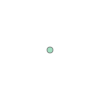

In [7]:
inR = rasterio.open(local_friction)
frictionD = inR.read()[0, :, :]
frictionD = frictionD * 1000
mcp = graph.MCP_Geometric(frictionD)

In [27]:
importlib.reload(ma)

all_rts = ma.get_linear_routes(
    inR,
    frictionD,
    inAdmin_centroids,
    inAdmin_centroids,
    "shapeName",
    "shapeName",
    verbose=True,
)
all_rts = all_rts.to_crs(3857)
all_rts["length_km"] = all_rts["geometry"].apply(lambda x: x.length / 1000)

13:39:16	Processing 0 of 47
13:39:24	Processing 1 of 47
13:39:34	Processing 2 of 47
13:39:45	Processing 3 of 47
13:39:55	Processing 4 of 47
13:40:02	Processing 5 of 47
13:40:11	Processing 6 of 47
13:40:20	Processing 7 of 47
13:40:27	Processing 8 of 47
13:40:33	Processing 9 of 47
13:40:40	Processing 10 of 47
13:40:46	Processing 11 of 47
13:40:56	Processing 12 of 47
13:41:02	Processing 13 of 47
13:41:09	Processing 14 of 47
13:41:16	Processing 15 of 47
13:41:22	Processing 16 of 47
13:41:30	Processing 17 of 47
13:41:36	Processing 18 of 47
13:41:42	Processing 19 of 47
13:41:49	Processing 20 of 47
13:41:55	Processing 21 of 47
13:42:01	Processing 22 of 47
13:42:09	Processing 23 of 47
13:42:15	Processing 24 of 47
13:42:21	Processing 25 of 47
13:42:28	Processing 26 of 47
13:42:37	Processing 27 of 47
13:42:45	Processing 28 of 47
13:42:52	Processing 29 of 47
13:42:59	Processing 30 of 47
13:43:05	Processing 31 of 47
13:43:11	Processing 32 of 47
13:43:17	Processing 33 of 47
13:43:24	Processing 34 o

In [28]:
# Map resulting route
centre = sel_country.unary_union.centroid
m = folium.Map(location=[centre.y, centre.x], zoom_start=4)
orig_map = inAdmin_centroids.iloc[0]
rts = folium.GeoJson(
    mapping(all_rts.unary_union),
    style_function=lambda feature: {"color": "red", "weight": 1},
)

folium.CircleMarker(
    location=[orig_map.geometry.y, orig_map.geometry.x],
    radius=2,
    weight=4,
    color="blue",
).add_to(m)

rts.add_to(m)

m

In [30]:
pd.pivot(all_rts, "origin", "destination", "cost")

destination         Baringo       Bomet      Bungoma        Busia  \
origin                                                              
Baringo                 NaN  247.384718   250.761691   300.902816   
Bomet            247.384718         NaN   210.030338   186.395056   
Bungoma          250.761691  210.030338          NaN    85.821950   
Busia            300.902816  186.395056    85.821950          NaN   
Elgeyo-Marakwet  171.907408  249.523784   151.929043   204.641645   
Embu             334.095587  338.277707   431.089396   458.583865   
Garissa          669.343485  620.470574   745.104811   772.599281   
Homa Bay         330.637303  132.292557   226.741244   169.648645   
Isiolo           510.929223  538.590397   614.226947   641.721417   
Kajiado          460.021691  410.709440   535.783017   563.277486   
Kakamega         247.051387  163.962614    62.294270    82.948442   
Kericho          196.928356   72.956960   186.791798   163.156516   
Kiambu           259.338573  214.143627   335.099899   362.594368   
Kilifi           703.185489  653.873238   778.946815   806.441284   
Kirinyaga        294.393400  311.285623   391.387209   418.881678   
Kisii            292.833044   67.037826   209.550786   185.915504   
Kisumu           260.320039   96.199358   118.046970    94.411688   
Kitui            546.094775  496.782524   621.856101   649.350570   
Kwale            682.076252  632.764001   757.837578   785.332047   
Laikipia         288.717754  351.540602   427.177152   454.671621   
Lamu             844.496786  795.623875   920.258113   947.752582   
Machakos         348.199034  299.326123   423.960360   451.454830   
Makueni          415.137884  365.825634   490.899211   518.393680   
Mandera          924.374790  952.035965  1027.672515  1055.166984   
Marsabit         685.560917  798.769974   872.906413   901.900994   
Meru             347.872337  375.533512   451.170062   478.664531   
Migori           339.981015  127.471235   255.096885   231.461602   
Mombasa          672.991174  623.678923   748.752500   776.246970   
Murang'a         284.619283  254.621708   360.380610   387.875079   
Nairobi          272.511007  223.198756   348.272333   375.766802   
Nakuru           172.341802  159.435555   247.224449   274.718918   
Nandi            209.330120  141.042959   110.773317   129.865043   
Narok            344.638670  120.441019   325.483889   301.848606   
Nyamira          263.568882   49.743356   188.639412   165.004130   
Nyandarua        199.320282  199.445059   275.081609   302.576078   
Nyeri            254.573226  275.930485   351.567035   379.061504   
Samburu          351.017324  476.885264   538.362820   580.016283   
Siaya            342.126324  180.097487   128.291443    66.561175   
Taita Taveta     558.907961  509.595710   634.669287   662.163756   
Tana River       699.270094  649.957843   775.031420   802.525889   
Tharaka          386.816938  397.708503   490.114662   517.609132   
Trans Nzoia      228.385039  236.788968    62.540412   133.554844   
Turkana          405.376446  556.571644   382.323088   453.337520   
Uasin Gishu      158.474065  183.745456    94.130266   144.271392   
Vihiga           270.566641  122.362940    87.667398    79.407495   
Wajir            649.813977  677.475152   753.111702   780.606171   
West Pokot       268.528961  388.689079   214.440523   285.454955   

destination      Elgeyo-Marakwet        Embu      Garissa     Homa Bay  \
origin                                                                   
Baringo               171.907408  334.095587   669.343485   330.637303   
Bomet                 249.523784  338.277707   620.470574   132.292557   
Bungoma               151.929043  431.089396   745.104811   226.741244   
Busia                 204.641645  458.583865   772.599281   169.648645   
Elgeyo-Marakwet              NaN  397.148982   725.925109   309.061771   
Embu                  397.148982         NaN   362.756177   438.705430   
Garissa               725.

In [33]:
pd.pivot(all_rts, "origin", "destination", "length_km")

destination         Baringo       Bomet      Bungoma        Busia  \
origin                                                              
Baringo                 NaN  212.279782   181.547957   233.654053   
Bomet            212.279784         NaN   216.603375   195.570698   
Bungoma          181.547961  216.603378          NaN    67.225092   
Busia            233.654053  195.570696    67.225092          NaN   
Elgeyo-Marakwet   86.592464  236.780225   127.746658   178.988134   
Embu             295.259395  367.809312   487.531780   522.248305   
Garissa          720.454157  658.503072   833.928018   868.644542   
Homa Bay         311.071623  121.695828   162.759362   114.597313   
Isiolo           443.621902  532.304809   657.801458   692.517982   
Kajiado          415.790140  353.295084   529.264001   563.980526   
Kakamega         174.503091  159.247603    43.996890    80.384336   
Kericho          187.650290   54.753129   192.295646   171.262969   
Kiambu           266.466200  210.724074   379.940061   414.656586   
Kilifi           737.726487  675.231431   851.200348   885.916873   
Kirinyaga        255.741576  338.346552   448.013961   482.730486   
Kisii            287.824280   65.491299   238.756730   217.724053   
Kisumu           261.946591   85.024334   131.579037   110.546360   
Kitui            502.085488  439.590432   615.559349   650.275874   
Kwale            769.908322  707.413266   883.382182   918.098707   
Laikipia         167.390884  269.034995   394.531643   429.248168   
Lamu             889.293119  827.342034  1002.766980  1037.483504   
Machakos         354.114524  292.163440   467.588385   502.304910   
Makueni          463.006952  400.511896   576.480813   611.197338   
Mandera          898.066609  986.749516  1112.246165  1146.962689   
Marsabit         405.667430  725.191156   590.253519   885.404329   
Meru             280.847586  369.530493   495.027142   529.743666   
Migori           348.926224  135.915297   290.159737   269.127060   
Mombasa          786.183689  723.688633   899.657550   934.374075   
Murang'a         279.561273  242.334677   393.035134   427.751659   
Nairobi          296.951137  234.456081   410.424997   445.141522   
Nakuru           151.936833  112.342204   264.322850   299.039375   
Nandi            118.879743  106.719088    95.397964   122.782175   
Narok            260.788179   80.479370   301.978001   280.945324   
Nyamira          247.445740   39.518105   201.414770   180.382093   
Nyandarua        185.341925  173.319137   298.815786   333.532311   
Nyeri            201.236033  268.011770   393.508418   428.224943   
Samburu          250.343564  401.205258   434.929653   561.418432   
Siaya            271.146845  160.119745   112.014208    57.829370   
Taita Taveta     635.332816  572.837761   748.806677   783.523202   
Tana River       672.379785  609.884729   785.853645   820.570170   
Tharaka          311.525869  414.724634   525.705425   560.421949   
Trans Nzoia      167.457716  253.877607    59.468411   132.039243   
Turkana          397.134140  588.665857   394.256661   466.827493   
Uasin Gishu       83.425265  194.346891    98.891754   150.997850   
Vihiga           216.801055  118.806931    97.796440    80.571197   
Wajir            641.913312  730.596218   856.092867   890.809392   
West Pokot       204.521885  354.928715   160.519519   233.090351   

destination      Elgeyo-Marakwet        Embu      Garissa     Homa Bay  \
origin                                                                   
Baringo                86.592463  295.259396   720.454151   311.071628   
Bomet                 236.780224  367.809318   658.503073   121.695828   
Bungoma               127.746657  487.531787   833.928017   162.759369   
Busia                 178.988133  522.248305   868.644534   114.597312   
Elgeyo-Marakwet              NaN  353.770081   783.810111   231.980353   
Embu                  353.770079         NaN   341.956372   460.826977   
Garissa               783.

In [ ]:
# Generate h3 grid around dedicated city
m = folium.Map(location=[row.geometry.y, row.geometry.x], zoom_start=4)

folium.CircleMarker(
    location=[y_range[0], x_range[0]], radius=2, weight=4, color="red"
).add_to(m)

folium.CircleMarker(
    location=[y_range[0], x_range[-1]], radius=2, weight=4, color="blue"
).add_to(m)

folium.CircleMarker(
    location=[y_range[-1], x_range[-1]], radius=2, weight=4, color="orange"
).add_to(m)

folium.CircleMarker(
    location=[y_range[-1], x_range[0]], radius=2, weight=4, color="green"
).add_to(m)


m

In [ ]:
x_range[0]